<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/Without%20Purcell%20Filter%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [ ]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 78.9 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit, minimize

In [ ]:
photon_list = np.array([0.0027809028825555213,
 0.0026145547910848515,
 0.0025759084899649558,
 0.0025300857393330913,
 0.0024721860424756076,
 0.002404658267884932,
 0.00232972434542873,
 0.002249191702467065,
 0.00216471175819369,
 0.0020777731073821333,
 0.0019896909924748828,
 0.001901601683921792,
 0.0018144559523372242,
 0.001729025223704284,
 0.0016459137710553046,
 0.0015655757637011499,
 0.0014883345171498746,
 0.0014144023272667757,
 0.0013438996421100558,
 0.0012768726076316098,
 0.0012133087588619728,
 0.001153150513574239,
 0.0010963065902604232,
 0.0010426615050069129,
 0.0009920831410228194,
 0.0009444290470273011,
 0.000899551184805238,
 0.0008572996458893036,
 0.0008175255168309781,
 0.0007800829247872276,
 0.0007448305681687934,
 0.0007116327390442251,
 0.000680359979521634,
 0.0006508894828826867,
 0.0006231052531051273,
 0.0005968981150239936,
 0.0005721656211988016,
 0.0005488118416939651,
 0.0005267470971361585,
 0.0005058877649865623,
 0.00048615582562322506,
 0.0004674786384050148,
 0.0004497885858590055,
 0.00043302276556545405,
 0.00041712266737155734,
 0.0004020336565742253,
 0.00038770559364585124,
 0.0003740911892611879,
 0.0003611466717131576,
 0.00034883132158072583])

Text(0, 0.5, 'Average Photon Number')

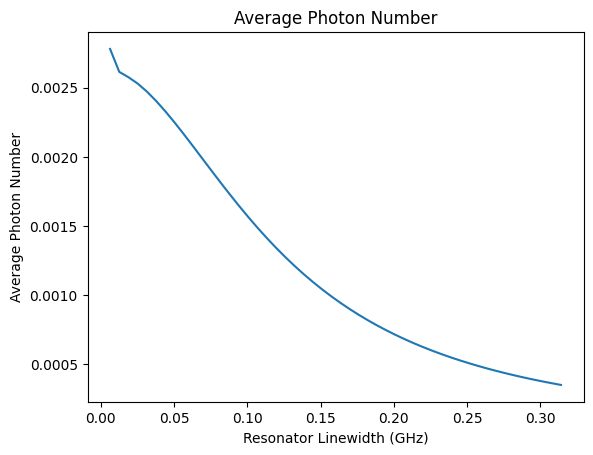

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, photon_list)

plt.title('Average Photon Number')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Average Photon Number')

# CP CPMG UDD XY4 XY8 XY16 Sequence

In [ ]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [ ]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [ ]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [ ]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [ ]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [ ]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Dressed Basis & Compare with Schrieffer - Wolff transformation

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
H0.eigenstates()

(array([-18.84955592,  18.78734013,  25.19495702,  62.70860687,
         69.23828458, 106.63099372, 113.28049203, 150.55444119,
        157.32163887, 194.77874452]),
 array([Quantum object: dims=[[2, 5], [1, 1]], shape=(10, 1), type='ket', dtype=Dense
        Qobj data =
        [[1.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]
         [0.]]                                                                       ,
        Quantum object: dims=[[2, 5], [1, 1]], shape=(10, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.        ]
         [ 0.09853762]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]
         [-0.99513333]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]]                                                              ,
        Quantum object: dims=[[2, 5], [1, 1]], shape=(10, 1), type='ket', dtype=Dense
        Qobj data =
        [

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


annihilate_dressed = + np.sqrt(1)*H0.eigenstates()[1][0]*H0.eigenstates()[1][2].dag() - np.sqrt(1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][3].dag() \
- np.sqrt(2)*H0.eigenstates()[1][2]*H0.eigenstates()[1][4].dag() - np.sqrt(2)*H0.eigenstates()[1][3]*H0.eigenstates()[1][5].dag() \
- np.sqrt(3)*H0.eigenstates()[1][4]*H0.eigenstates()[1][6].dag() - np.sqrt(3)*H0.eigenstates()[1][5]*H0.eigenstates()[1][7].dag() \
- np.sqrt(4)*H0.eigenstates()[1][6]*H0.eigenstates()[1][8].dag() + np.sqrt(4)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

eta = (g/detune)*(tensor(sp,a) - tensor(sm,a.dag()))

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed, (-eta).expm()*tensor(qeye(2),a.dag()*a)*eta.expm()]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
sx_bare

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

$$\left(\begin{array}{cc}0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\end{array}\right)$$

In [ ]:
sx_dressed

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00 -9.85376180e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.95133327e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.85376180e-02  0.00000000e+00 -1.36716890e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.85697129e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.36716890e-01  0.00000000e+00 -1.64391345e-01
   8.24771630e-17 -1.35376399e-02  0.00000000e+00  9.76780789e-01
  -1.09969551e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.64391345e-01 -1.75172167e-15
  -1.86484908e-01  0.00000000e+00 -2.28011959e-02 -1.68492342e-16
   9.68338252e-01  4.44089210e-16]
 [ 0.00000000e+00  0.00000000e+00  8.24771630e-17 -1.86484908e-01
   2.51941829e-16  0.00000000e+00  1.14396409e-17 -3.13852454e-02
  -8.01080421e-16  9.81956387e-01]
 [ 9.95133327e-01  0.00000000e+00 -1.35376399e-02  0.0000000

$$\left(\begin{array}{cc}0 & -0.099 & 0 & 0 & 0 & 0.995 & 0 & 0 & 0 & 0\\-0.099 & 0 & -0.137 & 0 & 0 & 0 & 0.986 & 0 & 0 & 0\\0 & -0.137 & 0 & -0.164 & 0 & -0.014 & 0 & 0.977 & 0 & 0\\0 & 0 & -0.164 & 0 & -0.186 & 0 & -0.023 & 0 & 0.968 & 0\\0 & 0 & 0 & -0.186 & 0 & 0 & 0 & -0.031 & 0 & 0.982\\0.995 & 0 & -0.014 & 0 & 0 & 0 & 0.098 & 0 & 0 & 0\\0 & 0.986 & 0 & -0.023 & 0 & 0.098 & 0 & 0.135 & 0 & 0\\0 & 0 & 0.977 & 0 & -0.031 & 0 & 0.135 & 0 & 0.163 & 0\\0 & 0 & 0 & 0.968 & 0 & 0 & 0 & 0.163 & 0 & 0.189\\0 & 0 & 0 & 0 & 0.982 & 0 & 0 & 0 & 0.189 & 0\end{array}\right)$$

In [ ]:
sy_dressed

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+0.00000000e+00j 0.+9.85376180e-02j 0.+0.00000000e+00j
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.-9.95133327e-01j
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.-9.85376180e-02j 0.+0.00000000e+00j 0.+1.36716890e-01j
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.-9.85697129e-01j 0.+0.00000000e+00j 0.+0.00000000e+00j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.-1.36716890e-01j 0.+0.00000000e+00j
  0.+1.64391345e-01j 0.-8.24771630e-17j 0.-1.35376399e-02j
  0.+0.00000000e+00j 0.-9.76780789e-01j 0.+1.09969551e-16j
  0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.64391345e-01j
  0.+0.00000000e+00j 0.+1.86484908e-01j 0.+0.00000000e+00j
  0.-2.28011959e-02j 0.-1.26320869e-16j 0.-9.68338252e-01j
  0.-4.44089210e-16j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+8.24771630e-17j
  0.-1.86484908e-01j 0.+0.00000000e+00j 

$$\left(\begin{array}{cc}0 & 0.099j & 0 & 0 & 0 & -0.995j & 0 & 0 & 0 & 0\\-0.099j & 0 & 0.137j & 0 & 0 & 0 & -0.986j & 0 & 0 & 0\\0 & -0.137j & 0 & 0.164j & 0 & -0.014j & 0 & -0.977j & 0 & 0\\0 & 0 & -0.164j & 0 & 0.186j & 0 & -0.023j & 0 & -0.968j & 0\\0 & 0 & 0 & -0.186j & 0 & 0 & 0 & -0.031j & 0 & -0.982j\\0.995j & 0 & 0.014j & 0 & 0 & 0 & -0.098j & 0 & 0 & 0\\0 & 0.986j & 0 & 0.023j & 0 & 0.098j & 0 & -0.135j & 0 & 0\\0 & 0 & 0.977j & 0 & 0.031j & 0 & 0.135j & 0 & -0.163j & 0\\0 & 0 & 0 & 0.968j & 0 & 0 & 0 & 0.163j & 0 & -0.189j\\0 & 0 & 0 & 0 & 0.982j & 0 & 0 & 0 & 0.189j & 0\end{array}\right)$$

In [ ]:
sz_dressed

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.80580676e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.96116135e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.62250449e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.72165527e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.44911183e-01
  -3.74961239e-16  0.00000000e+00  0.00000000e+00  3.27326835e-01
   1.70408548e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.74961239e-16
   9.28476691e-01  0.00000000e+00  0.00000000e+00 -1.85802301e-16
   3.71390676e-01  0.00000000e+00]
 [ 0.00000000e+00  1.96116135e-01  0.00000000e+00  0.0000000

$$\left(\begin{array}{cc}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0.981 & 0 & 0 & 0 & 0.196 & 0 & 0 & 0 & 0\\0 & 0 & 0.962 & 0 & 0 & 0 & 0.272 & 0 & 0 & 0\\0 & 0 & 0 & 0.945 & 0 & 0 & 0 & 0.327 & 0 & 0\\0 & 0 & 0 & 0 & 0.928 & 0 & 0 & 0 & 0.371 & 0\\0 & 0.196 & 0 & 0 & 0 & -0.981 & 0 & 0 & 0 & 0\\0 & 0 & 0.272 & 0 & 0 & 0 & -0.962 & 0 & 0 & 0\\0 & 0 & 0 & 0.327 & 0 & 0 & 0 & -0.945 & 0 & 0\\0 & 0 & 0 & 0 & 0.371 & 0 & 0 & 0 & -0.928 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1\end{array}\right)$$

In [ ]:
annihilate_dressed

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00  9.95133327e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.85376180e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.40752389e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.57436296e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.72407972e+00
  -1.15901519e-15  0.00000000e+00  0.00000000e+00  9.31362430e-02
   1.35488074e-15  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.13117656e-15
   1.99103734e+00  0.00000000e+00  0.00000000e+00  2.80556185e-17
   9.06966765e-02 -1.77635684e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.19740726e-31
  -1.33550221e-15  0.00000000e+00  0.00000000e+00 -1.78834183e-32
  -1.10321917e-16 -3.78215042e-01]
 [ 0.00000000e+00  0.00000000e+00  1.31495035e-03  0.000000

$$\left(\begin{array}{cc}0 & 0.995 & 0 & 0 & 0 & 0.099 & 0 & 0 & 0 & 0\\0 & 0 & 1.408 & 0 & 0 & 0 & 0.096 & 0 & 0 & 0\\0 & 0 & 0 & 1.724 & 0 & 0 & 0 & 0.093 & 0 & 0\\0 & 0 & 0 & 0 & 1.991 & 0 & 0 & 0 & 0.091 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -0.378\\0 & 0 & 0.001 & 0 & 0 & 0 & 1.005 & 0 & 0 & 0\\0 & 0 & 0 & 0.002 & 0 & 0 & 0 & 1.421 & 0 & 0\\0 & 0 & 0 & 0 & 0.003 & 0 & 0 & 0 & 1.740 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1.964\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{array}\right)$$

In [ ]:
annihilate_dressed.dag()

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 9.95133327e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.40752389e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.31495035e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.72407972e+00  1.13117656e-15
  -7.19740726e-31  0.00000000e+00  2.17409858e-03 -1.36962886e-15
   8.61046688e-31  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.15901519e-15  1.99103734e+00
  -1.33550221e-15  0.00000000e+00 -4.18719919e-17  2.93961066e-03
   1.56263150e-15  0.00000000e+00]
 [ 9.85376180e-02  0.00000000e+00  0.00000000e+00  0.000000

$$\left(\begin{array}{cc}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0.995 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1.408 & 0 & 0 & 0 & 0.001 & 0 & 0 & 0 & 0\\0 & 0 & 1.724 & 0 & 0 & 0 & 0.002 & 0 & 0 & 0\\0 & 0 & 0 & 1.991 & 0 & 0 & 0 & 0.003 & 0 & 0\\0.099 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0.096 & 0 & 0 & 0 & 1.005 & 0 & 0 & 0 & 0\\0 & 0 & 0.093 & 0 & 0 & 0 & 1.421 & 0 & 0 & 0\\0 & 0 & 0 & 0.091 & 0 & 0 & 0 & 1.740 & 0 & 0\\0 & 0 & 0 & 0 & -0.378 & 0 & 0 & 0 & 1.964 & 0\end{array}\right)$$

In [ ]:
number_dressed

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  9.90290338e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.80580676e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.98112522e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.36082763e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.97245559e+00
   2.49862990e-16  0.00000000e+00  0.00000000e+00  1.63663418e-01
   5.54513600e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.49862990e-16
   3.96423835e+00  0.00000000e+00  0.00000000e+00 -1.11677691e-16
   1.85695338e-01  0.00000000e+00]
 [ 0.00000000e+00  9.80580676e-02  0.00000000e+00  0.0000000

$$\left(\begin{array}{cc}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0.990 & 0 & 0 & 0 & 0.098 & 0 & 0 & 0 & 0\\0 & 0 & 1.981 & 0 & 0 & 0 & 0.136 & 0 & 0 & 0\\0 & 0 & 0 & 2.972 & 0 & 0 & 0 & 0.164 & 0 & 0\\0 & 0 & 0 & 0 & 3.964 & 0 & 0 & 0 & 0.186 & 0\\0 & 0.098 & 0 & 0 & 0 & 0.010 & 0 & 0 & 0 & 0\\0 & 0 & 0.136 & 0 & 0 & 0 & 1.019 & 0 & 0 & 0\\0 & 0 & 0 & 0.164 & 0 & 0 & 0 & 2.028 & 0 & 0\\0 & 0 & 0 & 0 & 0.186 & 0 & 0 & 0 & 3.036 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 4\end{array}\right)$$

In [ ]:
norm_list = []

for i in range(1000):
  for j in range(1000):


$ \eta = \frac{g}{\Delta} (\sigma_+ a - \sigma_- a^\dagger) $

$ \tilde{H} = e^{\eta} H e^{-\eta} $

In [ ]:
eta = (g/detune)*(tensor(sp,a) - tensor(sm,a.dag()))

sch = (-eta).expm()*tensor(qeye(2),a.dag()*a)*eta.expm()

sch

Quantum object: dims=[[2, 5], [2, 5]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99003329 0.         0.         0.         0.09933467
  0.         0.         0.         0.        ]
 [0.         0.         1.98013298 0.         0.         0.
  0.13954327 0.         0.         0.        ]
 [0.         0.         0.         2.9702988  0.         0.
  0.         0.1697617  0.         0.        ]
 [0.         0.         0.         0.         3.9605305  0.
  0.         0.         0.19470917 0.        ]
 [0.         0.09933467 0.         0.         0.         0.00996671
  0.         0.         0.         0.        ]
 [0.         0.         0.13954327 0.         0.         0.
  1.01986702 0.         0.         0.        ]
 [0.         0.         0.         0.1697617  0.         0.
  0.         2.0297012  0.         0.        ]
 [0.         0.        

$$\left(\begin{array}{cc}0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0.990 & 0 & 0 & 0 & 0.099 & 0 & 0 & 0 & 0\\0 & 0 & 1.980 & 0 & 0 & 0 & 0.140 & 0 & 0 & 0\\0 & 0 & 0 & 2.970 & 0 & 0 & 0 & 0.170 & 0 & 0\\0 & 0 & 0 & 0 & 3.961 & 0 & 0 & 0 & 0.195 & 0\\0 & 0.099 & 0 & 0 & 0 & 0.010 & 0 & 0 & 0 & 0\\0 & 0 & 0.140 & 0 & 0 & 0 & 1.020 & 0 & 0 & 0\\0 & 0 & 0 & 0.170 & 0 & 0 & 0 & 2.030 & 0 & 0\\0 & 0 & 0 & 0 & 0.195 & 0 & 0 & 0 & 3.039 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 4\end{array}\right)$$

In [ ]:
# Simulation

N_seq = 1

tlist = np.linspace(0, 400, 4000)
T_end_q = 400

A = 0.01 * 2 * np.pi
B = 0.10 * 2 * np.pi      # 25ns
kappa = 2 * np.pi * 0.05      # resonator linewidth in units of GHz
omega_qd = omega_qd0

result0 = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Average Photon Number')

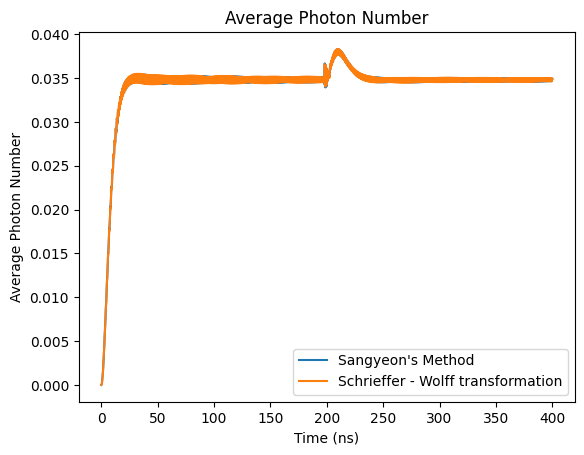

In [ ]:
# Plot Results

plt.plot(tlist, result0.expect[3], label="Sangyeon's Method")
plt.plot(tlist, result0.expect[4], label="Schrieffer - Wolff transformation")

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

# $\pi$-Pulse Coherent Error

change
detune btw qubit dressed freq & qubit dressed, B, kappa

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
coherence_list = []
z_list = []

## CPMG Coherent Error

In [ ]:
# Simulation

N_seq = 1

A = 2 * np.pi * 0.000
kappa = 2 * np.pi * 0.0000001      # resonator linewidth in units of GHz


for i in range(5):
  print(i)
  print()
  for j in range(50):

      B = 2 * np.pi * 0.010*(i+1)                   # 5ns
      omega_qd = omega_qd0 + 2*chi*0.005*(j+1)      # qubit frequency in units of GHz
      phi = 2 * np.pi / 8 * 0

      tlist = np.linspace(0, (int)((0.5*2*np.pi)/B)+1, (int)(1000*(0.5*2*np.pi)/B+1))
      T_end_q = (0.5*2*np.pi)/B

      rho0 = (psi0 + np.exp(1j*phi)*psi1)/np.sqrt(2)

      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      z_list.append(result.expect[2][-1])

      print(j)
      print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      print(result.expect[2][-1])
      print()

0

0
0.9998053267490805
0.015281225575910651

1
0.9998107803118631
0.014918620836276526

2
0.999820640264586
0.014239327855296609

3
0.9998342538287346
0.013244093910778002

4
0.9998506634502945
0.011934055185293606

5
0.999868615937604
0.010310751403499716

6
0.9998865695405675
0.008376188966023424

7
0.9999027328720346
0.006128943629990737

8
0.9999149659099589
0.003575387727438704

9
0.9999209236922489
0.00071651227490198

10
0.9999179954513226
-0.0024447468025546827

11
0.999903333772268
-0.005905006577950058

12
0.9998738734375636
-0.009660371393065479

13
0.9998263496167803
-0.013706360603650906

14
0.9997569581402334
-0.018057222699562607

15
0.9996624205238036
-0.022682973847488148

16
0.9995387883942093
-0.02758799147057688

17
0.9993820943986048
-0.03276730670951895

18
0.9991883272588205
-0.03821395017447097

19
0.9989519751952111
-0.043952567517538975

20
0.9986704161566121
-0.04993559150675434

21
0.9983383281766823
-0.056178024475480835

22
0.9979515895541562
-0.062667756

In [ ]:
coherence_list

[0.9998053267490805,
 0.9998107803118631,
 0.999820640264586,
 0.9998342538287346,
 0.9998506634502945,
 0.999868615937604,
 0.9998865695405675,
 0.9999027328720346,
 0.9999149659099589,
 0.9999209236922489,
 0.9999179954513226,
 0.999903333772268,
 0.9998738734375636,
 0.9998263496167803,
 0.9997569581402334,
 0.9996624205238036,
 0.9995387883942093,
 0.9993820943986048,
 0.9991883272588205,
 0.9989519751952111,
 0.9986704161566121,
 0.9983383281766823,
 0.9979515895541562,
 0.9975056999606489,
 0.9969963296693652,
 0.9964159171894393,
 0.9957639782067947,
 0.995034035552126,
 0.994222015214756,
 0.9933232444327145,
 0.9923337436542808,
 0.9912484062789949,
 0.9900640701886934,
 0.9887773234229941,
 0.9873812018634021,
 0.9858751754899648,
 0.9842535324841948,
 0.9825160664560744,
 0.9806551966729516,
 0.9786729003231025,
 0.9765667674251785,
 0.9743234258396746,
 0.9719540120104482,
 0.9694525615327768,
 0.966819930594148,
 0.9640445680902006,
 0.9611397828310405,
 0.9580920855565369

In [ ]:
z_list

[0.015281225575910651,
 0.014918620836276526,
 0.014239327855296609,
 0.013244093910778002,
 0.011934055185293606,
 0.010310751403499716,
 0.008376188966023424,
 0.006128943629990737,
 0.003575387727438704,
 0.00071651227490198,
 -0.0024447468025546827,
 -0.005905006577950058,
 -0.009660371393065479,
 -0.013706360603650906,
 -0.018057222699562607,
 -0.022682973847488148,
 -0.02758799147057688,
 -0.03276730670951895,
 -0.03821395017447097,
 -0.043952567517538975,
 -0.04993559150675434,
 -0.056178024475480835,
 -0.06266775606382034,
 -0.06939905192325185,
 -0.07636343440589115,
 -0.08359075971193752,
 -0.0910237621797887,
 -0.09867907001847073,
 -0.10654550781846997,
 -0.11461824424352972,
 -0.12288690869509726,
 -0.13135086817618497,
 -0.13999498590569362,
 -0.1488082301115043,
 -0.1578028723386633,
 -0.16695051046470946,
 -0.1762562322098972,
 -0.1856943934116613,
 -0.19528057734583215,
 -0.20498152352967422,
 -0.21478914267519836,
 -0.22474360273596064,
 -0.2347767408400546,
 -0.24489

Text(0, 0.5, 'Coherence')

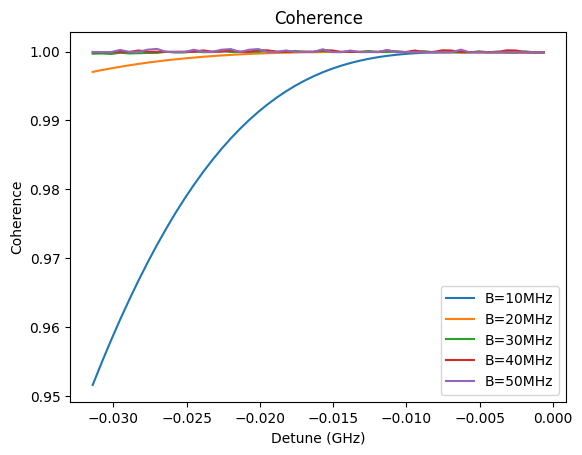

In [ ]:
# Plot Results

detune_list = np.array([2*chi*0.005*(j+1) for j in range(50)])
plt.plot(detune_list, coherence_list[0:50], label="B=10MHz")
plt.plot(detune_list, coherence_list[50:100], label="B=20MHz")
plt.plot(detune_list, coherence_list[100:150], label="B=30MHz")
plt.plot(detune_list, coherence_list[150:200], label="B=40MHz")
plt.plot(detune_list, coherence_list[200:250], label="B=50MHz")

plt.legend()
plt.title('Coherence')
plt.xlabel('Detune (GHz)')
plt.ylabel('Coherence')

(0.997, 1.001)

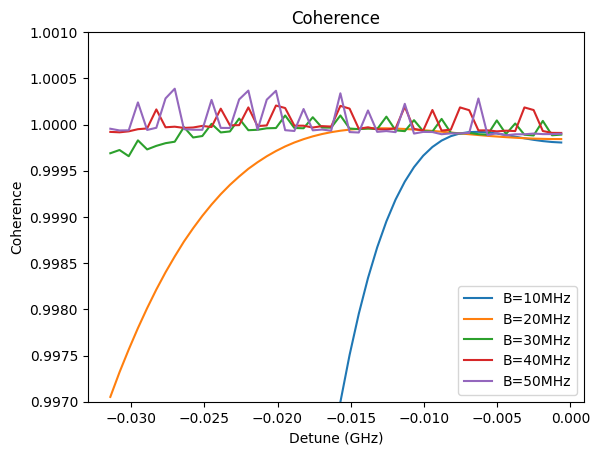

In [ ]:
# Plot Results

detune_list = np.array([2*chi*0.005*(j+1) for j in range(50)])
plt.plot(detune_list, coherence_list[0:50], label="B=10MHz")
plt.plot(detune_list, coherence_list[50:100], label="B=20MHz")
plt.plot(detune_list, coherence_list[100:150], label="B=30MHz")
plt.plot(detune_list, coherence_list[150:200], label="B=40MHz")
plt.plot(detune_list, coherence_list[200:250], label="B=50MHz")

plt.legend()
plt.title('Coherence')
plt.xlabel('Detune (GHz)')
plt.ylabel('Coherence')
plt.ylim(0.997, 1.001)

Text(0, 0.5, 'Z')

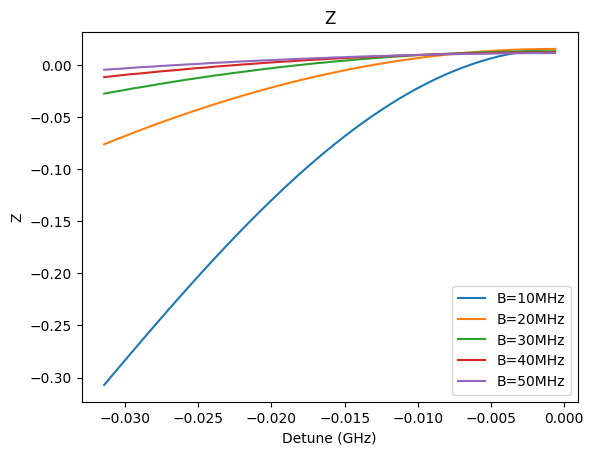

In [ ]:
# Plot Results

detune_list = np.array([2*chi*0.005*(j+1) for j in range(50)])
plt.plot(detune_list, z_list[0:50], label="B=10MHz")
plt.plot(detune_list, z_list[50:100], label="B=20MHz")
plt.plot(detune_list, z_list[100:150], label="B=30MHz")
plt.plot(detune_list, z_list[150:200], label="B=40MHz")
plt.plot(detune_list, z_list[200:250], label="B=50MHz")

plt.legend()
plt.title('Z')
plt.xlabel('Detune (GHz)')
plt.ylabel('Z')

# Photon Number
change
detune btw qubit dressed freq & qubit dressed, B, kappa

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
photon_list = []

## Photon Number

In [ ]:
# Simulation

N_seq = 0

A = 2 * np.pi * 0.001
B = 2 * np.pi * 0.1

for i in range(50):

      kappa = 2 * np.pi * 0.001 * (i+1)
      omega_qd = omega_qd0

      tlist = np.linspace(0, 500, 5000)
      T_end_q = 5


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      photon_list.append(np.mean(result.expect[3][4000:]))

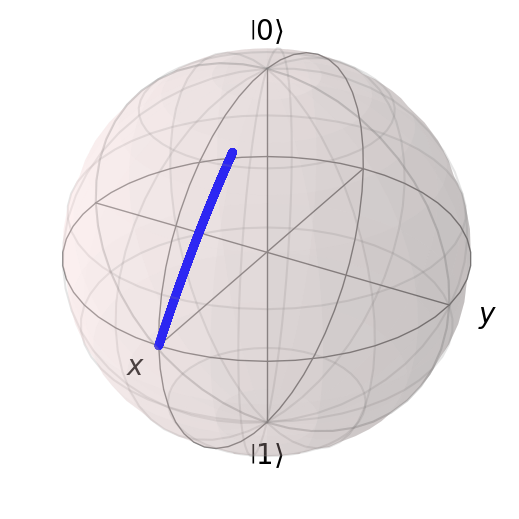

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

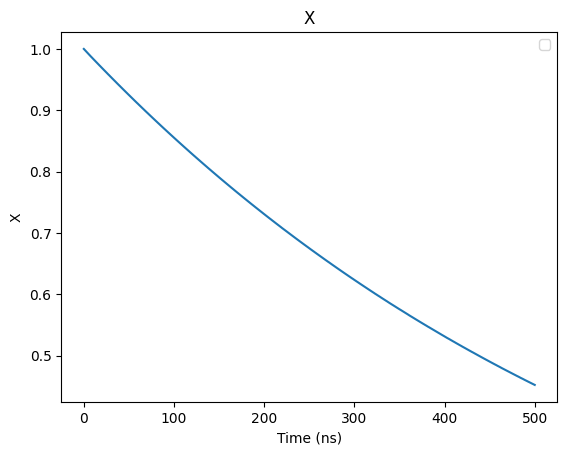

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

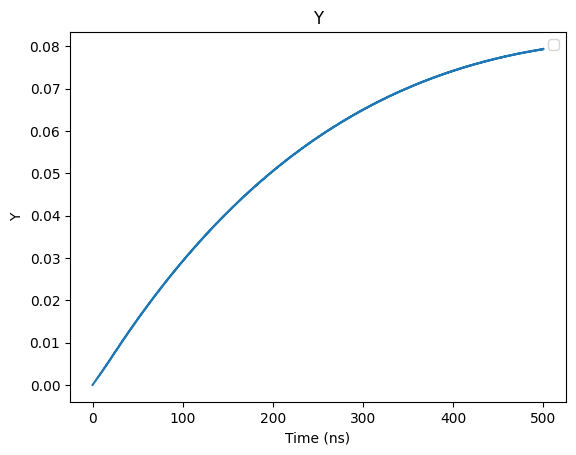

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

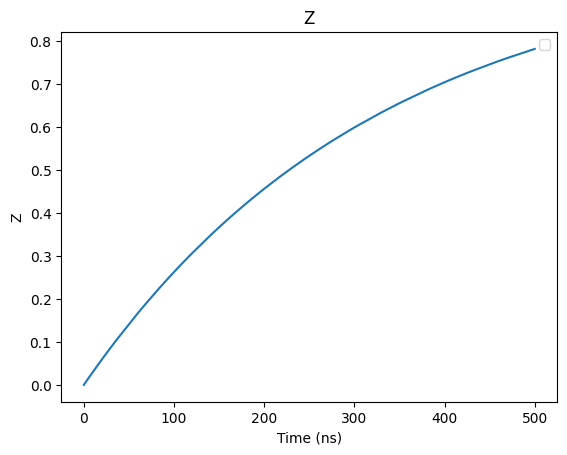

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Average Photon Number')

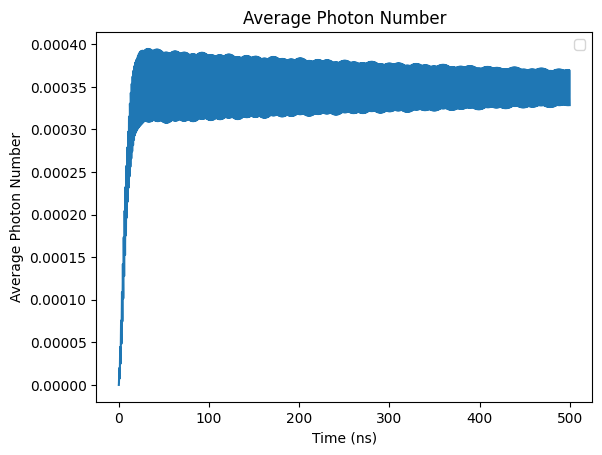

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
photon_list

[0.0027809028825555213,
 0.0026145547910848515,
 0.0025759084899649558,
 0.0025300857393330913,
 0.0024721860424756076,
 0.002404658267884932,
 0.00232972434542873,
 0.002249191702467065,
 0.00216471175819369,
 0.0020777731073821333,
 0.0019896909924748828,
 0.001901601683921792,
 0.0018144559523372242,
 0.001729025223704284,
 0.0016459137710553046,
 0.0015655757637011499,
 0.0014883345171498746,
 0.0014144023272667757,
 0.0013438996421100558,
 0.0012768726076316098,
 0.0012133087588619728,
 0.001153150513574239,
 0.0010963065902604232,
 0.0010426615050069129,
 0.0009920831410228194,
 0.0009444290470273011,
 0.000899551184805238,
 0.0008572996458893036,
 0.0008175255168309781,
 0.0007800829247872276,
 0.0007448305681687934,
 0.0007116327390442251,
 0.000680359979521634,
 0.0006508894828826867,
 0.0006231052531051273,
 0.0005968981150239936,
 0.0005721656211988016,
 0.0005488118416939651,
 0.0005267470971361585,
 0.0005058877649865623,
 0.00048615582562322506,
 0.0004674786384050148,
 0

# Maximum Photon Number (fixed steady state photon number 0.01)
change
detune btw qubit dressed freq & qubit dressed, B, kappa

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
maxphoton_list2 = []

## Max Photon Number

In [ ]:
# Simulation

N_seq = 1

for j in range(5):
  for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[i])
      B = 2 * np.pi * 0.01 * (j+1)

      kappa = 2 * np.pi * 0.001 * (i+1)
      omega_qd = omega_qd0

      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      photon_list.append(np.max(result.expect[3][2500 + 10*(int)(0.5/(0.01 * (j+1))):]))

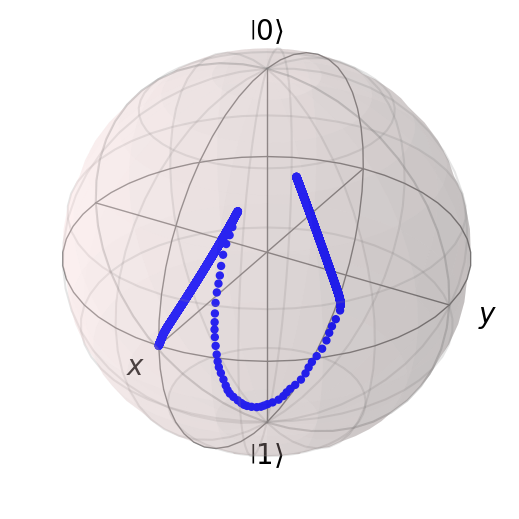

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

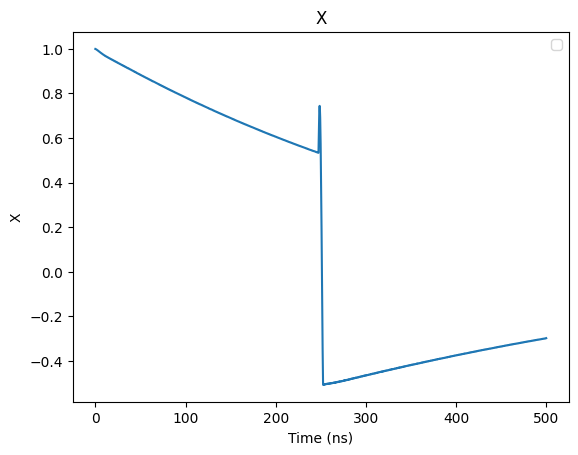

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

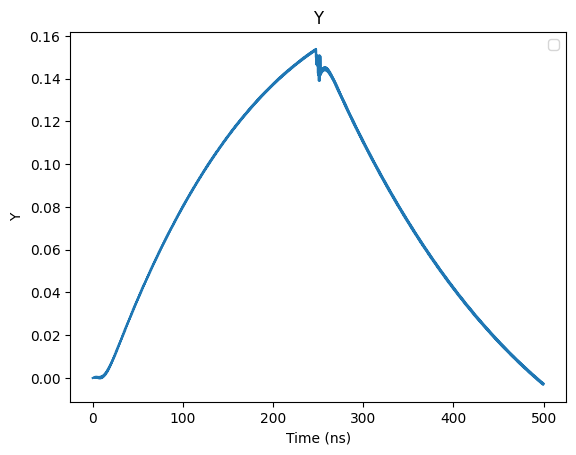

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

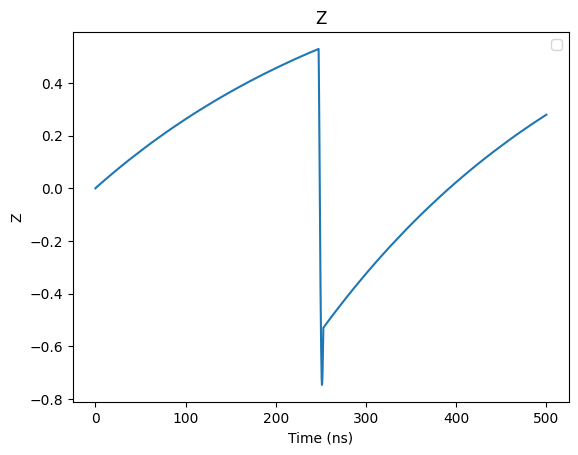

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Average Photon Number')

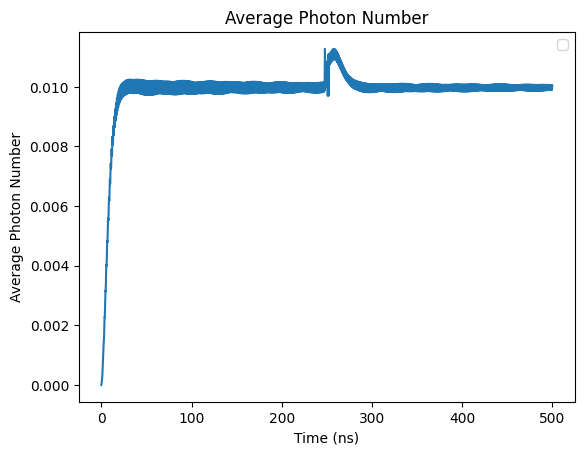

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
photon_list[50:]

[0.04707115940286025,
 0.037690946353709315,
 0.031019735135092697,
 0.026529170276131185,
 0.023273483696382765,
 0.020798549897538127,
 0.018860898326307107,
 0.017332005749590033,
 0.016110739969814207,
 0.015120231801374638,
 0.014312355566396172,
 0.013650960421510122,
 0.013105862392109148,
 0.012653659534815936,
 0.012278530278956533,
 0.011959509489145611,
 0.011693981469051151,
 0.01146954439203445,
 0.011279320410861254,
 0.011118783875275075,
 0.01097908265089333,
 0.010859886032187238,
 0.01075799308223358,
 0.010672093059499885,
 0.010600387873892034,
 0.0105378441178803,
 0.01048326647504721,
 0.010436019317702118,
 0.010395174421767059,
 0.010359122900681268,
 0.010327329631272824,
 0.010299283393292832,
 0.010274618321047266,
 0.010252572541811097,
 0.010233052442777274,
 0.010215534884551736,
 0.010200253604356665,
 0.010185787506095292,
 0.010172851183096234,
 0.010161494911509361,
 0.01015170363476001,
 0.010142065256233295,
 0.010133222771420647,
 0.0101250777440529

In [ ]:
maxphoton_list2 = np.array([0.04707115940286025,
 0.037690946353709315,
 0.031019735135092697,
 0.026529170276131185,
 0.023273483696382765,
 0.020798549897538127,
 0.018860898326307107,
 0.017332005749590033,
 0.016110739969814207,
 0.015120231801374638,
 0.014312355566396172,
 0.013650960421510122,
 0.013105862392109148,
 0.012653659534815936,
 0.012278530278956533,
 0.011959509489145611,
 0.011693981469051151,
 0.01146954439203445,
 0.011279320410861254,
 0.011118783875275075,
 0.01097908265089333,
 0.010859886032187238,
 0.01075799308223358,
 0.010672093059499885,
 0.010600387873892034,
 0.0105378441178803,
 0.01048326647504721,
 0.010436019317702118,
 0.010395174421767059,
 0.010359122900681268,
 0.010327329631272824,
 0.010299283393292832,
 0.010274618321047266,
 0.010252572541811097,
 0.010233052442777274,
 0.010215534884551736,
 0.010200253604356665,
 0.010185787506095292,
 0.010172851183096234,
 0.010161494911509361,
 0.01015170363476001,
 0.010142065256233295,
 0.010133222771420647,
 0.010125077744052972,
 0.010117547660201173,
 0.010110498674101515,
 0.010103959395870695,
 0.010097784803182495,
 0.010091982278839286,
 0.010088203657480158,
 0.07355286916923123,
 0.05768702587039832,
 0.046838277676537574,
 0.03975454880006053,
 0.03470668769516116,
 0.030878890233923113,
 0.0278529699259425,
 0.025405561142991383,
 0.023396442214476672,
 0.02173013284724111,
 0.02033241205027946,
 0.019147406681188812,
 0.01813532223440644,
 0.017269410400061903,
 0.016522615104047993,
 0.01587111615467652,
 0.015306748596566819,
 0.014801784212785074,
 0.01434961449711932,
 0.013944240676541445,
 0.013579596359083833,
 0.01325439838484676,
 0.012959234471639401,
 0.012694479324547663,
 0.012455992159622706,
 0.012240850913064719,
 0.012047215555026932,
 0.011871519140443251,
 0.011712058174479251,
 0.011568474893085736,
 0.011437956103585922,
 0.011319195862631793,
 0.011211618523045645,
 0.011114113658452052,
 0.01102503927486328,
 0.010943704897818402,
 0.01086971681656964,
 0.010802153801524259,
 0.010740442908738844,
 0.010684289014990104,
 0.01063359340542274,
 0.01058615741961584,
 0.010542593642267103,
 0.010501265575158326,
 0.01046452032918091,
 0.010430696102737629,
 0.010400143487260914,
 0.010371365194843475,
 0.010344795785842874,
 0.010320233581872382,
 0.08126895224215033,
 0.06310434770405904,
 0.050876503681842614,
 0.04296877478617857,
 0.0373764163550665,
 0.033144470467941174,
 0.029806216514338842,
 0.027116274706893474,
 0.024912797480983358,
 0.02308536319396353,
 0.021552816038563148,
 0.020256760310685736,
 0.01915365044037214,
 0.018209082335932006,
 0.01738855718684816,
 0.016679979033596096,
 0.016061241869854203,
 0.015516517134689775,
 0.015033517717882363,
 0.014611207830343061,
 0.014235533760931698,
 0.01390038750192587,
 0.01360199325920325,
 0.013331444522890885,
 0.013092866031220738,
 0.012878536334101194,
 0.012687547486957995,
 0.0125122765101507,
 0.012353453899182137,
 0.012209970149852492,
 0.012075118739872234,
 0.011951591209518045,
 0.011835112673918104,
 0.01172685267093363,
 0.011625412015805085,
 0.011530555392755411,
 0.01144204390671184,
 0.01136066575479333,
 0.01128349892735025,
 0.011211405825055072,
 0.011142910895121634,
 0.011080030282626933,
 0.011021382580779154,
 0.010966001469780258,
 0.01091431962071677,
 0.010866139470304821,
 0.010820499310272604,
 0.01077826748676245,
 0.010737853768515411,
 0.01070023997684854,
 0.08431837355337701,
 0.06514489572234539,
 0.05236487508869765,
 0.04414576625076402,
 0.03834639792582844,
 0.03397169620971309,
 0.03052380199780624,
 0.02774429358183717,
 0.025478195322076024,
 0.023586883100950216,
 0.022012908406834293,
 0.02067954836337964,
 0.01954007121190453,
 0.018565109159393575,
 0.017721591351212495,
 0.016988897326875207,
 0.016350574960023755,
 0.015790875999095674,
 0.01529438785193938,
 0.014854839238968123,
 0.014464108536529111,
 0.01412142888386089,
 0.013811554523392059,
 0.01353383585486353,
 0.013285185407228582,
 0.013066049971840014,
 0.012864763452137749,
 0.012684286415836373,
 0.0125187354657796,
 0.01236631484053354,
 0.012229785698748023,
 0.012101705264515329,
 0.011985142467626613,
 0.011879012419525298,
 0.011778934866940304,
 0.01168578483657978,
 0.011601875696838815,
 0.011522987922043728,
 0.011449036785480428,
 0.01137858163891116,
 0.011315474934189102,
 0.011256680223876261,
 0.011200079958650442,
 0.011147363037440414,
 0.011096817336474185,
 0.01104893525366423,
 0.011003045303214061,
 0.010960431463862299,
 0.010919254741651318,
 0.010880324526449627,
 0.08508147463178693,
 0.06548694337224291,
 0.05252853347421652,
 0.04424263444882246,
 0.038406204730354776,
 0.03401190989220056,
 0.030554044206202276,
 0.027762823196261402,
 0.025485057027389485,
 0.02359348790754573,
 0.022010430685953528,
 0.020673004601873872,
 0.019531677434498452,
 0.01855301303260376,
 0.017706934393273394,
 0.016971713796972727,
 0.016328216482987427,
 0.015766315149178332,
 0.01526987869745723,
 0.014828351626312136,
 0.014435775532809246,
 0.014089786941918744,
 0.013780046188258807,
 0.013498852994148118,
 0.013246749210244723,
 0.013024756262966983,
 0.01282161279674317,
 0.012639043228356284,
 0.012472057584519055,
 0.012318286374219924,
 0.012180559250730357,
 0.012050049387161046,
 0.01193097020190712,
 0.011823541283930929,
 0.011722334157691828,
 0.011627375709542942,
 0.011541634773004706,
 0.011462187351564852,
 0.011386358447814287,
 0.011315479214893488,
 0.011248601591313634,
 0.011188723351162624,
 0.01113176613123042,
 0.011077842901719882,
 0.011026804662526027,
 0.010978367922444552,
 0.010932902542971227,
 0.010891550155880123,
 0.01085218698587906,
 0.010814686682049135,
 0.0864577385029333,
 0.0664760464499566,
 0.05329431488572288,
 0.04486450280635073,
 0.03892829392300822,
 0.03446322146277041,
 0.03095431601886035,
 0.028116700581798375,
 0.025805051029791977,
 0.02388066388701859,
 0.02227830164268309,
 0.02092108444313599,
 0.019761549358555584,
 0.018769161154830606,
 0.017911423136684188,
 0.017167354516672024,
 0.016514939471944184,
 0.01594089201092494,
 0.015439403858682975,
 0.014993278269511202,
 0.014595997952667411,
 0.014243832295685861,
 0.013930480587324028,
 0.013643098511163111,
 0.013391582337076876,
 0.013166435859889703,
 0.01296156373281877,
 0.012776289506757488,
 0.01260363825544941,
 0.012451592473956287,
 0.012309561603637404,
 0.012179376968097757,
 0.012059356982950593,
 0.011947922076394713,
 0.011844493362718941,
 0.011751597967603666,
 0.011663309395074609,
 0.011580002984562316,
 0.011503979768738182,
 0.01143408712245163,
 0.011367226162505835,
 0.011304112767487422,
 0.011244405446534728,
 0.011190792868240264,
 0.011140127017522724,
 0.011091876626717546,
 0.011045998216906775,
 0.011002130105890804,
 0.010960509238161891,
 0.010922318874350153,
 0.08762429122092133,
 0.06731379343047333,
 0.05392266246020421,
 0.045360804297551675,
 0.03933171191607263,
 0.03479827861426734,
 0.03123616903661479,
 0.02836279680937029,
 0.026019943854220556,
 0.024076633690807318,
 0.02245345413078135,
 0.0210803955027248,
 0.019910453361496643,
 0.01890781414349674,
 0.018043150137314192,
 0.01729319672043935,
 0.016639299544549454,
 0.016063243662924987,
 0.015554374693637135,
 0.015107794672366661,
 0.014710785004795885,
 0.014359545913974984,
 0.01404193012537601,
 0.013760348589884069,
 0.013511796438078668,
 0.013286543128565784,
 0.0130837750456992,
 0.012899520021181816,
 0.012732353295068876,
 0.012578058201350535,
 0.012440136797676069,
 0.012309742727942096,
 0.012193777150808058,
 0.012085164815498308,
 0.011983451551477493,
 0.011894194262471222,
 0.01180843363582062,
 0.011726616777954802,
 0.011655732381094538,
 0.011587208228606156,
 0.011522315004963604,
 0.011462830011076612,
 0.011409616891899265,
 0.011357882024709573,
 0.011308531797766603,
 0.011262552910594706,
 0.01122194566191114,
 0.01118301874540983,
 0.011145106402826056,
 0.01110828571243164,
 0.08698791469591063,
 0.06668748130136991,
 0.053405812563776064,
 0.04493516036321861,
 0.038979618466758126,
 0.03454235670466926,
 0.030979346406008624,
 0.0281393599612575,
 0.025849871415313287,
 0.02389386044659472,
 0.022311683946886988,
 0.020948922681126535,
 0.0197648677794972,
 0.01876984227709264,
 0.017929761106314515,
 0.01718151716054452,
 0.01652557349540965,
 0.0159333523461315,
 0.015448829971655727,
 0.014984505183877311,
 0.014584338976467975,
 0.014244275900870474,
 0.013916857106515418,
 0.013628328557251955,
 0.01339177716921742,
 0.013158680620563827,
 0.01294229711780413,
 0.012767249715368913,
 0.012592870314438885,
 0.012440153475897334,
 0.012296099088932439,
 0.012153790307130138,
 0.012034594623890041,
 0.011922968303478726,
 0.011826718924473349,
 0.01172346935208939,
 0.011636466005531096,
 0.011552241303812692,
 0.011473522536665165,
 0.01140927810035361,
 0.011343488332821275,
 0.01128002287394054,
 0.011220278656339552,
 0.01115762230575188,
 0.011107009883841099,
 0.011065834530013615,
 0.011018372991514438,
 0.010973842925073873,
 0.010927763305154187,
 0.010888062481580717,
 0.0870677885170485,
 0.06677775316979387,
 0.053386316380877964,
 0.044887882317090885,
 0.03891920704751429,
 0.03443162889813177,
 0.030907980477682628,
 0.028108067899212767,
 0.025782116322475238,
 0.02385274124169753,
 0.02221421893310077,
 0.020873649481788843,
 0.01969598980998045,
 0.018730248548146495,
 0.017847825447026396,
 0.01710365281943812,
 0.01647577974284294,
 0.015902986016628547,
 0.015379965667407031,
 0.014937142489370111,
 0.014540731741999345,
 0.014199384005400386,
 0.013877434903853916,
 0.01359505675888691,
 0.013343418682571065,
 0.013119269266098105,
 0.012916356380275431,
 0.012732152744366183,
 0.01256348138834926,
 0.012410912273732934,
 0.012269067543724848,
 0.012142909260810143,
 0.012031379150098736,
 0.011914303559278737,
 0.011814696376558857,
 0.011721688285264778,
 0.01163277078452609,
 0.011554760397097904,
 0.011480657908071854,
 0.011410064465042752,
 0.01134321930249567,
 0.011290422502969417,
 0.011228522048391148,
 0.011180846716237303,
 0.011124421993051845,
 0.011081503968565502,
 0.011038710734471997,
 0.010992182165526311,
 0.010953031308257618,
 0.010920749655087436,
 0.08925303592236164,
 0.06846102365047847,
 0.05479518166437846,
 0.046065455390392675,
 0.03992367058078865,
 0.03530936569202357,
 0.03168296608616658,
 0.028760498863251764,
 0.02637550412673506,
 0.024405024584183626,
 0.022753690401867435,
 0.02135511223708459,
 0.020167103102833435,
 0.01914698659387814,
 0.018269202557460774,
 0.01750819669750515,
 0.01684490139495419,
 0.016264287483911115,
 0.01575026407396148,
 0.015293773340748025,
 0.01489000162340127,
 0.014536643262179518,
 0.014216925082000845,
 0.013935204014001033,
 0.013679840035410997,
 0.013455627637245542,
 0.01324781712472371,
 0.013062677052870397,
 0.01289286544002385,
 0.012738731788838773,
 0.012595742300626694,
 0.012468506241612274,
 0.012349166233277229,
 0.012241126249313334,
 0.012140756511596087,
 0.012046750504370375,
 0.011962831994113748,
 0.01188382760960857,
 0.011808192384055134,
 0.01174211827427419,
 0.011678638577183324,
 0.011618654357967745,
 0.011563989803734383,
 0.011514476519129832,
 0.01146656764696265,
 0.011420351309246166,
 0.011380554586696517,
 0.011342342083453957,
 0.011305750883935387,
 0.011270177748837911])

Text(0, 0.5, 'Maximum Photon Number')

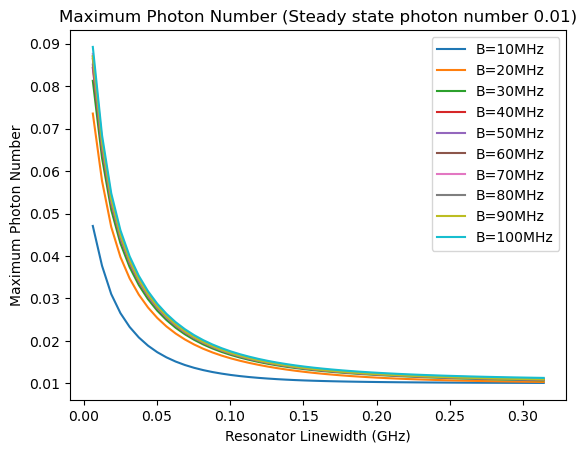

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, maxphoton_list2[0:50], label="B=10MHz")
plt.plot(kappa_list, maxphoton_list2[50:100], label="B=20MHz")
plt.plot(kappa_list, maxphoton_list2[100:150], label="B=30MHz")
plt.plot(kappa_list, maxphoton_list2[150:200], label="B=40MHz")
plt.plot(kappa_list, maxphoton_list2[200:250], label="B=50MHz")
plt.plot(kappa_list, maxphoton_list2[250:300], label="B=60MHz")
plt.plot(kappa_list, maxphoton_list2[300:350], label="B=70MHz")
plt.plot(kappa_list, maxphoton_list2[350:400], label="B=80MHz")
plt.plot(kappa_list, maxphoton_list2[400:450], label="B=90MHz")
plt.plot(kappa_list, maxphoton_list2[450:], label="B=100MHz")

plt.legend()
plt.title('Maximum Photon Number (Steady state photon number 0.01)')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Maximum Photon Number')

# Maximum Photon Number (fixed steady state photon number 0.001)
change
detune btw qubit dressed freq & qubit dressed, B, kappa

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
maxphoton_list3 = []

## Max Photon Number

In [ ]:
# Simulation

N_seq = 1

for j in range(10):
  print(j)
  for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.001/photon_list[i])
      B = 2 * np.pi * 0.01 * (j+1)

      kappa = 2 * np.pi * 0.001 * (i+1)
      omega_qd = omega_qd0

      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      maxphoton_list3.append(np.max(result.expect[3][2500 + 10*(int)(0.5/(0.01 * (j+1))):]))

0
1
2
3
4
5
6
7
8
9


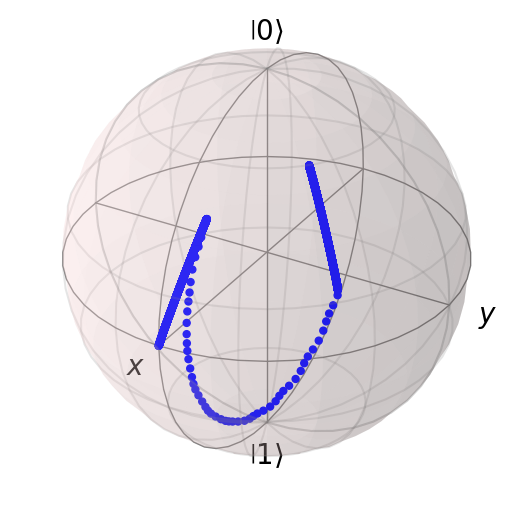

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

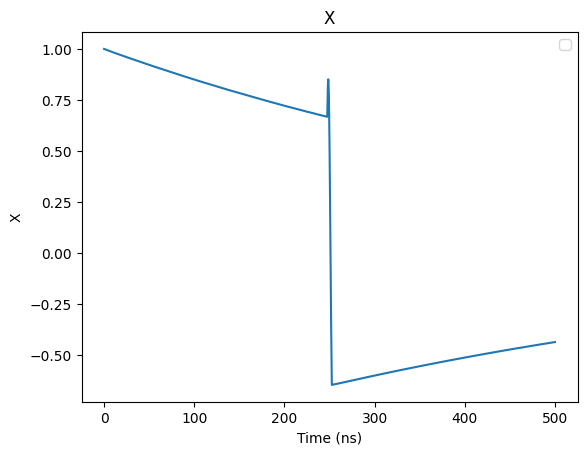

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

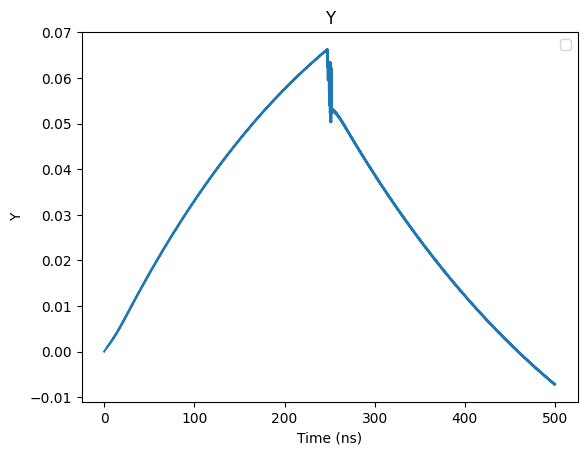

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

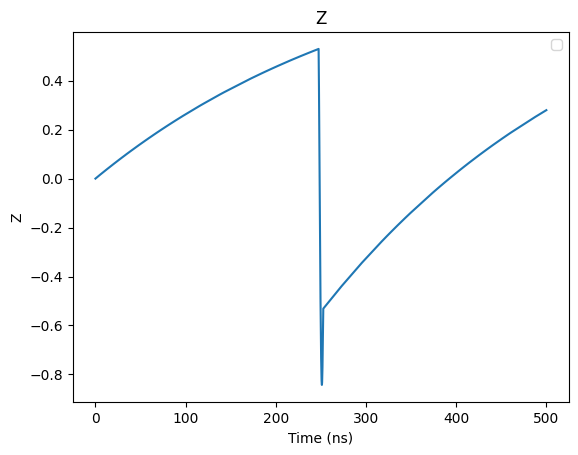

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

Text(0, 0.5, 'Average Photon Number')

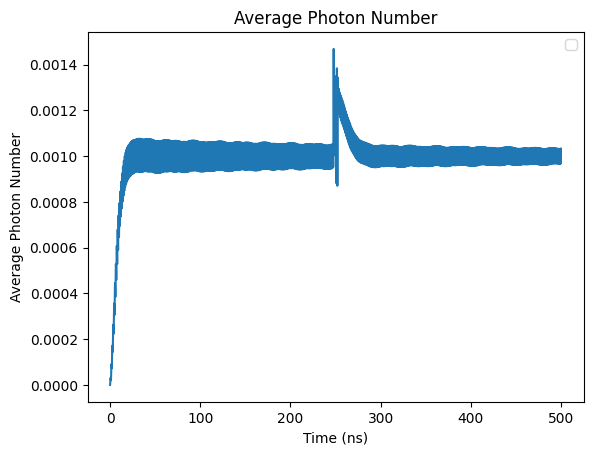

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
maxphoton_list3

[0.00468842900155485,
 0.0037625753747433516,
 0.003099164921640702,
 0.00265389669080218,
 0.002331612892853287,
 0.0020869317547929866,
 0.0018958755738809772,
 0.001744337851155286,
 0.001622792072018894,
 0.00152525806714399,
 0.0014455075967643772,
 0.0013802573303484565,
 0.0013263810146334836,
 0.0012825087528229283,
 0.0012460818886188096,
 0.0012154516537434602,
 0.0011897836413706753,
 0.0011678534767766476,
 0.0011498173238895582,
 0.0011346492592542567,
 0.001121750295642604,
 0.0011107125093176183,
 0.0011013078949536606,
 0.0010930033802947475,
 0.0010862741554265878,
 0.0010800700227793594,
 0.0010751254079901437,
 0.0010706722443691934,
 0.0010668135287416104,
 0.0010634630226395868,
 0.0010605574891820056,
 0.001058036455616266,
 0.0010559688648590308,
 0.0010538947995551641,
 0.001052205820850061,
 0.0010507226829033051,
 0.0010495919079505892,
 0.0010484383324216337,
 0.0010474270320863961,
 0.0010465273491104036,
 0.0010457323866429516,
 0.001045017948354611,
 0.001

In [ ]:
maxphoton_list3 = [0.00468842900155485,
 0.0037625753747433516,
 0.003099164921640702,
 0.00265389669080218,
 0.002331612892853287,
 0.0020869317547929866,
 0.0018958755738809772,
 0.001744337851155286,
 0.001622792072018894,
 0.00152525806714399,
 0.0014455075967643772,
 0.0013802573303484565,
 0.0013263810146334836,
 0.0012825087528229283,
 0.0012460818886188096,
 0.0012154516537434602,
 0.0011897836413706753,
 0.0011678534767766476,
 0.0011498173238895582,
 0.0011346492592542567,
 0.001121750295642604,
 0.0011107125093176183,
 0.0011013078949536606,
 0.0010930033802947475,
 0.0010862741554265878,
 0.0010800700227793594,
 0.0010751254079901437,
 0.0010706722443691934,
 0.0010668135287416104,
 0.0010634630226395868,
 0.0010605574891820056,
 0.001058036455616266,
 0.0010559688648590308,
 0.0010538947995551641,
 0.001052205820850061,
 0.0010507226829033051,
 0.0010495919079505892,
 0.0010484383324216337,
 0.0010474270320863961,
 0.0010465273491104036,
 0.0010457323866429516,
 0.001045017948354611,
 0.0010443723199146395,
 0.0010438020922431065,
 0.001043110273023247,
 0.0010428146312260376,
 0.0010422137786139654,
 0.0010418088185440832,
 0.0010414846737342009,
 0.0010410985734007844,
 0.007415041052094173,
 0.005812197085038514,
 0.004717252415267046,
 0.00400293314490686,
 0.00349575819307697,
 0.0031110794647032747,
 0.0028072026212000276,
 0.002562880536188111,
 0.0023632373773301283,
 0.0021980338241647775,
 0.0020592837187672144,
 0.0019419645422986806,
 0.0018417267462772669,
 0.0017556413209986383,
 0.0016810205551948277,
 0.0016163011915113277,
 0.0015597027619206347,
 0.001509683010991615,
 0.00146465819046651,
 0.0014242716507080122,
 0.001388047370683611,
 0.0013559091281683947,
 0.0013262664724839042,
 0.0013000899189848467,
 0.0012765299346165178,
 0.0012553165880410699,
 0.001235979522559053,
 0.001219120570141929,
 0.0012032440471426487,
 0.0011891248688807418,
 0.001176188226206498,
 0.0011648931933573108,
 0.0011542467972506958,
 0.001144801097414976,
 0.0011364637869804577,
 0.0011282715700674242,
 0.0011212657564548666,
 0.0011148492817705496,
 0.00110886996589234,
 0.0011037382683216721,
 0.0010987635219326568,
 0.001094367308623705,
 0.0010904247746628512,
 0.00108669325719085,
 0.0010833307534933773,
 0.0010801483533219186,
 0.0010774468194911693,
 0.0010748931154517963,
 0.0010725646253963268,
 0.0010704326936189393,
 0.008258588256734008,
 0.006411111271126478,
 0.0051715494302871316,
 0.004371956528678582,
 0.00380503912093571,
 0.0033743022495014924,
 0.0030351110823583272,
 0.002763621182026219,
 0.002541939893238223,
 0.002357771431883017,
 0.0022028036676099124,
 0.0020726507874068295,
 0.0019614660107006875,
 0.0018656968679187978,
 0.0017828027133979423,
 0.0017113764171297293,
 0.001648267098232284,
 0.0015948022841969138,
 0.0015470169762443356,
 0.0015045894698917097,
 0.0014674708946637578,
 0.0014338973342049011,
 0.0014041594564829073,
 0.001376874147580883,
 0.0013531337746347238,
 0.0013320316953988175,
 0.0013128380243280099,
 0.0012954386616531978,
 0.001279640294635739,
 0.0012652119041915342,
 0.001252042458252808,
 0.0012400020164294574,
 0.0012284643680034917,
 0.0012176989467088488,
 0.0012073398835083413,
 0.001197976006931761,
 0.00118938373173138,
 0.0011814931668827707,
 0.0011735617427599161,
 0.001166555873688541,
 0.0011601579800805462,
 0.001153999417506296,
 0.0011479625442994159,
 0.0011425680735731116,
 0.0011374112286975226,
 0.0011328274789655945,
 0.0011282063400447333,
 0.0011240177638545366,
 0.0011201370916988508,
 0.0011165505859426232,
 0.008529499167758215,
 0.006598773797667613,
 0.005305242193231514,
 0.004479929996576111,
 0.003894875027318197,
 0.003451090455974848,
 0.0031033405319782137,
 0.002822750917203168,
 0.0025957842741288883,
 0.0024062406677790933,
 0.0022478892373064435,
 0.0021137963539060965,
 0.0019996644080407704,
 0.001900745949320086,
 0.001815482571391503,
 0.001741238493278071,
 0.0016776654167711014,
 0.0016216655724619977,
 0.0015722457391500822,
 0.0015288021006422338,
 0.0014896492947979905,
 0.0014560120090664618,
 0.0014246672483502853,
 0.0013959494594946859,
 0.0013713409021682329,
 0.0013497301856940512,
 0.0013292893179040575,
 0.0013109761932120548,
 0.0012952703526910153,
 0.001279461035900462,
 0.0012659983925407757,
 0.0012525541882359066,
 0.0012414657201212525,
 0.0012298730534603703,
 0.0012207694578031236,
 0.0012120722465373515,
 0.0012046521820664896,
 0.0011967827890503762,
 0.0011906799304427364,
 0.0011835937594081945,
 0.0011776203148507445,
 0.0011721557653588503,
 0.0011665273278148184,
 0.0011620591603047434,
 0.0011565960892755223,
 0.0011520610055150353,
 0.00114774749766554,
 0.0011436719893596096,
 0.0011398122097577177,
 0.0011361701853936108,
 0.008410440243840533,
 0.006466459582668643,
 0.005184872631458776,
 0.004372081476346482,
 0.003799599081739445,
 0.003368003141413048,
 0.0030282264545705415,
 0.002755543924364797,
 0.002533373131266025,
 0.0023486663453572,
 0.002194549802666272,
 0.0020639465619240616,
 0.0019524161144723804,
 0.001856259586155675,
 0.001773070300681168,
 0.0017007045217836453,
 0.001637621880368938,
 0.001582512109200816,
 0.0015350011973790172,
 0.0014930060090146836,
 0.0014545808810126951,
 0.001420544222901162,
 0.001390617348651799,
 0.0013628146640208354,
 0.0013386300137669387,
 0.001315276087458992,
 0.0012960693044005783,
 0.0012780774311666485,
 0.0012616303070464628,
 0.0012469117007939798,
 0.0012333147408244024,
 0.0012208364051499922,
 0.001209011196785217,
 0.0011983893048792078,
 0.0011885132826974258,
 0.0011792944740227664,
 0.0011708076941440752,
 0.001162758985649262,
 0.0011555809439465002,
 0.0011485575901505445,
 0.0011424895739749427,
 0.0011364440216373982,
 0.0011316670783237004,
 0.0011266676052638332,
 0.0011224776233977887,
 0.0011183478102365333,
 0.0011143668459381543,
 0.0011106477895060955,
 0.0011071887339421543,
 0.001104117198825036,
 0.008635260934118429,
 0.006645005598743866,
 0.005336065892903354,
 0.004495960472041654,
 0.003907814773125885,
 0.003461927677065532,
 0.0031121273033269782,
 0.0028310225071750666,
 0.002601843456869365,
 0.0024117702233984605,
 0.002252631718210628,
 0.002117467864293698,
 0.002002647120252775,
 0.0019035927886217306,
 0.0018179466066074056,
 0.001743184219407343,
 0.0016781854737889948,
 0.001622234827201483,
 0.0015725598334193419,
 0.0015289981520781434,
 0.0014897596822207046,
 0.0014547131633769988,
 0.0014231771322654018,
 0.0013948348114146245,
 0.0013693074479756919,
 0.001347314500380198,
 0.001326988874676287,
 0.001308459331489044,
 0.001291847454306029,
 0.0012761980948060463,
 0.001262014071796265,
 0.0012490960459667902,
 0.001237103943122751,
 0.0012256366868375974,
 0.0012155184022947167,
 0.0012062050933131926,
 0.0011971685787603157,
 0.0011897592093750387,
 0.0011829811654009812,
 0.001176263844066579,
 0.0011698559006009838,
 0.0011642762797110478,
 0.0011587758574383453,
 0.0011539378772391486,
 0.0011491133889336119,
 0.0011449344463244095,
 0.0011405346867205963,
 0.0011366120261561772,
 0.001133168147795859,
 0.0011294716984316421,
 0.008911324070271278,
 0.006852555708937477,
 0.00549152035195394,
 0.004620373261118242,
 0.0040057808020672585,
 0.003543031009434996,
 0.0031803013875276753,
 0.0028904320757930967,
 0.002652216586126442,
 0.00245778471208044,
 0.002293791333937134,
 0.0021546682954152584,
 0.00203650276074732,
 0.0019354443795626076,
 0.0018481212884906184,
 0.0017724771534315677,
 0.0017079058879877424,
 0.001650516764962784,
 0.0016010368664582085,
 0.0015571729270003423,
 0.0015175859864495274,
 0.0014825683298993646,
 0.0014513415480207213,
 0.0014246918405417777,
 0.0014003065678683145,
 0.0013785932784804661,
 0.0013586926248716769,
 0.0013409128855894922,
 0.0013247895539363647,
 0.001309982923165534,
 0.001297563152455975,
 0.0012862069859424122,
 0.0012757976448927774,
 0.0012671882100989268,
 0.001258694161671089,
 0.0012511119650456357,
 0.0012443920243866858,
 0.0012378779284673994,
 0.0012325509229374227,
 0.0012272550658028718,
 0.0012222700208260923,
 0.001218403575200495,
 0.00121460495448367,
 0.0012113785924140034,
 0.0012086429188596435,
 0.0012059982241615966,
 0.001203436693243736,
 0.001201282145160465,
 0.0011993046091628215,
 0.0011959309380822766,
 0.008618976888887832,
 0.006613522165933022,
 0.005316410308357442,
 0.004476618977315498,
 0.0038783276394448304,
 0.0034356415845913195,
 0.0030875087293084228,
 0.0028079965256273664,
 0.0025805578378375613,
 0.0023915539155695683,
 0.0022336462733731567,
 0.0020991189497047273,
 0.0019851192710504395,
 0.001886533883186402,
 0.0018010336151279606,
 0.0017273092522546286,
 0.001662034963872823,
 0.0016061761932752256,
 0.0015569960406299013,
 0.0015133864364050714,
 0.0014741553493203324,
 0.0014396103004342003,
 0.001411861113334812,
 0.001380363410001585,
 0.0013580491791413904,
 0.0013316242211977869,
 0.0013112963928212503,
 0.0012928062135071593,
 0.0012760264550904109,
 0.0012625671687238513,
 0.0012466585797369593,
 0.0012336991786082345,
 0.0012218076254490809,
 0.0012108450446822272,
 0.001200555498800115,
 0.001191010139128913,
 0.00118226593377445,
 0.0011742882019656483,
 0.0011666394305368012,
 0.001162070067653692,
 0.0011531512690300936,
 0.0011470761565951283,
 0.0011419808219106677,
 0.0011369894896153675,
 0.0011324431408417258,
 0.0011280091382131483,
 0.0011241109148616665,
 0.0011204068173753642,
 0.0011167198221998097,
 0.0011133632657268804,
 0.008597352426641,
 0.006568318602467052,
 0.005253860593055378,
 0.004418895258202867,
 0.003845242388034275,
 0.0033926208062236597,
 0.0030464563541144777,
 0.0027688316096202955,
 0.0025435314807236756,
 0.0023564720609278882,
 0.0022001979900664373,
 0.002068558821018777,
 0.0019555396235248755,
 0.0018586720314692129,
 0.0017753974285071167,
 0.0017066544809856044,
 0.0016387646113991076,
 0.0015844752992138773,
 0.0015400121069188,
 0.001494064064666231,
 0.0014563015532384103,
 0.001422760641110259,
 0.001392751325048211,
 0.0013674258428275426,
 0.0013440657332355935,
 0.001321909580338392,
 0.0012998502073114102,
 0.0012826067707060304,
 0.0012663847624748575,
 0.0012536304884035547,
 0.001238930155316493,
 0.001226578203224436,
 0.0012153109360508302,
 0.0012050808500827436,
 0.0011956929593325866,
 0.001186546953006715,
 0.0011785477630385545,
 0.001171716497592147,
 0.001165073107915821,
 0.001159362046458971,
 0.001154983187163265,
 0.0011489168249706296,
 0.0011440711007993246,
 0.0011396635240935218,
 0.0011365473923488397,
 0.00113190837208903,
 0.0011285801916790792,
 0.001124748495563588,
 0.0011216537202372358,
 0.001119846178168508,
 0.009248174169453798,
 0.0071110096983374215,
 0.005698437462670749,
 0.004791003071746073,
 0.0041508518119808095,
 0.0036675202171521574,
 0.0032902180774605355,
 0.0029888107968367625,
 0.0027427770675671746,
 0.0025388989096477585,
 0.002367512077843869,
 0.0022237926405009717,
 0.0021013193738633968,
 0.001996373209619938,
 0.0019057409143495641,
 0.0018283081187968927,
 0.0017615512092629963,
 0.0017029300232054472,
 0.0016512246739942083,
 0.0016053533378127907,
 0.001564912455327122,
 0.0015297289436412371,
 0.0014985511429850018,
 0.0014711438448263947,
 0.0014460704919650395,
 0.0014237949054081644,
 0.0014038640242051816,
 0.0013864301274707687,
 0.0013716217223626794,
 0.0013576303992799451,
 0.00134600109585188,
 0.0013349152729122294,
 0.0013252155265432509,
 0.0013164938341940914,
 0.0013089362806477317,
 0.0013021643714702731,
 0.0012964087487404145,
 0.0012916453845294015,
 0.0012876146452892104,
 0.0012849569770013109,
 0.0012830224239329087,
 0.0012814093860378467,
 0.0012795901694848586,
 0.0012778922698593917,
 0.0012757033413249472,
 0.001274101244797733,
 0.0012725138165097319,
 0.0012704169880793563,
 0.0012686829112194117,
 0.0012669862726055474]

(0.001, 0.01)

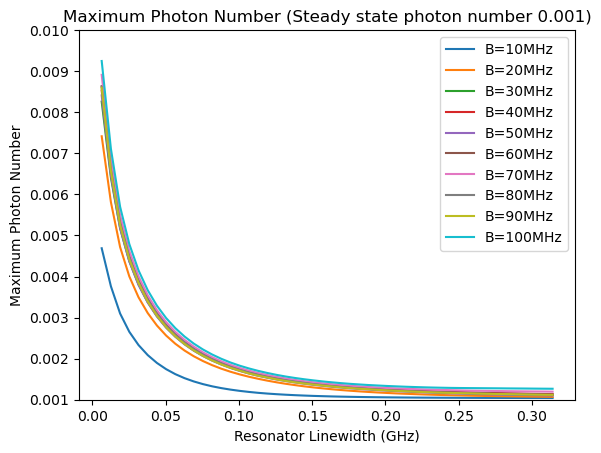

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, maxphoton_list3[0:50], label="B=10MHz")
plt.plot(kappa_list, maxphoton_list3[50:100], label="B=20MHz")
plt.plot(kappa_list, maxphoton_list3[100:150], label="B=30MHz")
plt.plot(kappa_list, maxphoton_list3[150:200], label="B=40MHz")
plt.plot(kappa_list, maxphoton_list3[200:250], label="B=50MHz")
plt.plot(kappa_list, maxphoton_list3[250:300], label="B=60MHz")
plt.plot(kappa_list, maxphoton_list3[300:350], label="B=70MHz")
plt.plot(kappa_list, maxphoton_list3[350:400], label="B=80MHz")
plt.plot(kappa_list, maxphoton_list3[400:450], label="B=90MHz")
plt.plot(kappa_list, maxphoton_list3[450:500], label="B=100MHz")

plt.legend()
plt.title('Maximum Photon Number (Steady state photon number 0.001)')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Maximum Photon Number')
plt.ylim(0.001, 0.01)

In [ ]:
result.expect[2][-1]

0.2795931381532807

In [ ]:
np.sqrt(result.expect[0][-1]**2+result.expect[1][-1])

0.5885000211160379

# Coherence

XY4

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
coherence_list = []
z_list = []

In [ ]:
ramsey_coherence_list = []

In [ ]:
N_seq = 0

omega_qd = omega_qd0

for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[i])
      B = 2 * np.pi * 0.01

      kappa = 2 * np.pi * 0.001 * (i+1)


      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500

      rho0 = (psi0 + psi1)/np.sqrt(2)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        rho0,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))

In [ ]:
ramsey_coherence_list

[0.9064079232366217,
 0.8336370549495579,
 0.774589214102931,
 0.7227306418843162,
 0.6768739411453287,
 0.6365273942531932,
 0.6012213349837188,
 0.5704510590287839,
 0.5437131619944641,
 0.5205241400405594,
 0.5004332506203164,
 0.48302975345910437,
 0.46803439611547937,
 0.45493099345787913,
 0.44353364796110795,
 0.43359123742574035,
 0.42488588643323716,
 0.4172291470716255,
 0.4104846536048781,
 0.40446345213051965,
 0.3990677515871819,
 0.39419740878892107,
 0.38976453022602425,
 0.38569441527244913,
 0.38193432049062864,
 0.3784112470476102,
 0.37508750077098274,
 0.3719241558516471,
 0.368889296099535,
 0.3659690617975985,
 0.3631162190278151,
 0.36032038490794305,
 0.357563232202263,
 0.3547458526613925,
 0.3520357923014589,
 0.3493339749996418,
 0.34663431773712966,
 0.3439373539414904,
 0.34122681544887057,
 0.33890739282758015,
 0.3361857434151934,
 0.33344644723878103,
 0.3306900544577285,
 0.32791525391502824,
 0.325121253743614,
 0.32230967781973024,
 0.3194797619050177

In [ ]:
ramsey_coherence_list = np.array([0.9064079232366217,
 0.8336370549495579,
 0.774589214102931,
 0.7227306418843162,
 0.6768739411453287,
 0.6365273942531932,
 0.6012213349837188,
 0.5704510590287839,
 0.5437131619944641,
 0.5205241400405594,
 0.5004332506203164,
 0.48302975345910437,
 0.46803439611547937,
 0.45493099345787913,
 0.44353364796110795,
 0.43359123742574035,
 0.42488588643323716,
 0.4172291470716255,
 0.4104846536048781,
 0.40446345213051965,
 0.3990677515871819,
 0.39419740878892107,
 0.38976453022602425,
 0.38569441527244913,
 0.38193432049062864,
 0.3784112470476102,
 0.37508750077098274,
 0.3719241558516471,
 0.368889296099535,
 0.3659690617975985,
 0.3631162190278151,
 0.36032038490794305,
 0.357563232202263,
 0.3547458526613925,
 0.3520357923014589,
 0.3493339749996418,
 0.34663431773712966,
 0.3439373539414904,
 0.34122681544887057,
 0.33890739282758015,
 0.3361857434151934,
 0.33344644723878103,
 0.3306900544577285,
 0.32791525391502824,
 0.325121253743614,
 0.32230967781973024,
 0.31947976190501776,
 0.31663376284477773,
 0.31377128187709746,
 0.3108947736544877])

## CPMG Coherent Error

In [ ]:
# Simulation

N_seq = 4

omega_qd = omega_qd0
phi = 2 * np.pi / 8 * 0


for j in range(2, 5, 1):
  print(j)
  for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[i])
      B = 2 * np.pi * 0.010*(j+1)

      kappa = 2 * np.pi * 0.001 * (i+1)


      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500

      rho0 = (psi0 + np.exp(1j*phi)*psi1)/np.sqrt(2)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        rho0,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      z_list.append(result.expect[2][-1])

2
3
4


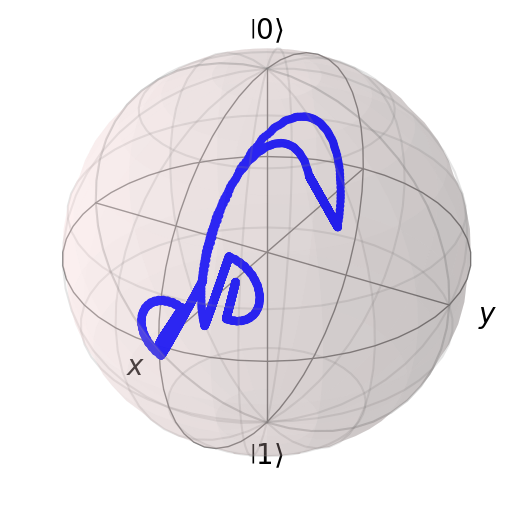

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

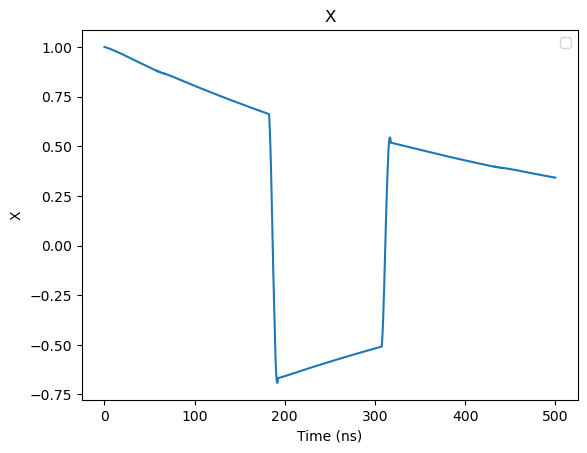

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

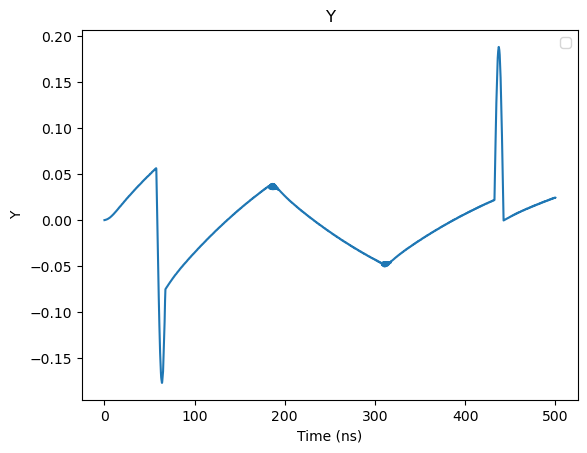

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

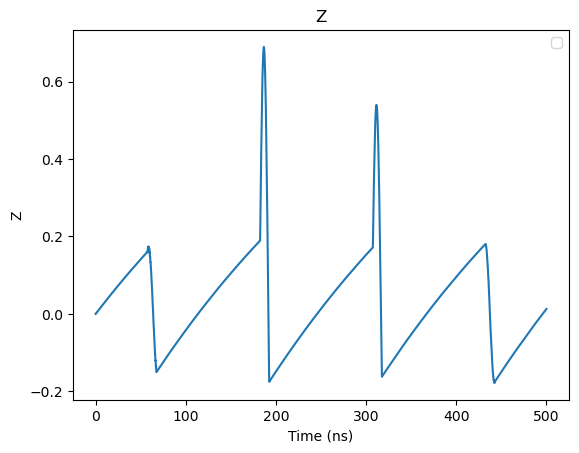

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

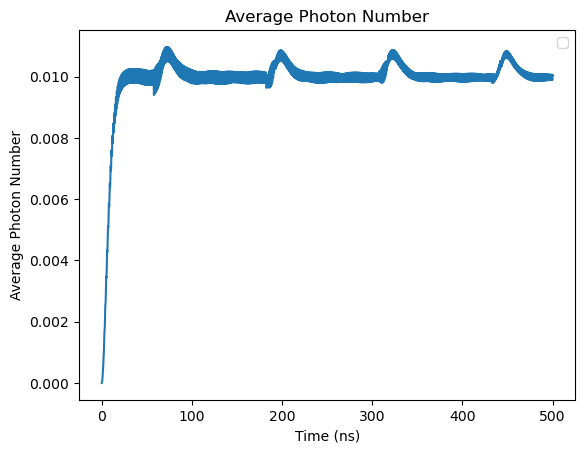

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
coherence_list = np.array([0.8270124949836956,
 0.7529396290788457,
 0.7069511708820577,
 0.6696774864438634,
 0.6375161264618769,
 0.6103206495218668,
 0.5876912703750513,
 0.5682120565979245,
 0.5520142917487202,
 0.538429404650712,
 0.5269554169475325,
 0.5172439527372142,
 0.5089958713237214,
 0.5019048126963546,
 0.4958496397790985,
 0.49053518252463835,
 0.4858815677045647,
 0.4817872485288532,
 0.47815361243555454,
 0.47490199702798347,
 0.4719645044778437,
 0.4692996122911503,
 0.46684544106699966,
 0.46460330434002933,
 0.4624759313894886,
 0.4604292890923153,
 0.45852346190183485,
 0.4567077295300297,
 0.45496507488359295,
 0.4532763475545133,
 0.4516382785052024,
 0.4500262372809536,
 0.4484344543311199,
 0.4468848262862063,
 0.4453322768347282,
 0.44378157090599696,
 0.44223204176059655,
 0.4406974994393571,
 0.43916481674230146,
 0.4375990425258521,
 0.4360705996040443,
 0.43450901292977934,
 0.4329954100319407,
 0.43143677149703136,
 0.4298554666806726,
 0.4282869271061423,
 0.4267005456138674,
 0.42511488436655037,
 0.4235299891201537,
 0.4219355345213408,
 0.7781646574899809,
 0.7121241112025823,
 0.6673859903009007,
 0.631407228230799,
 0.6015273761196357,
 0.576495564131317,
 0.5553035890122595,
 0.5373158802350193,
 0.5226184511434601,
 0.5098425806134966,
 0.49873047754061606,
 0.4894500008326836,
 0.48132224365975895,
 0.47419355515973155,
 0.4679671901191685,
 0.46226691597944913,
 0.45735639820087765,
 0.45291927409688476,
 0.44865138190847537,
 0.44505595391246805,
 0.44160993641261026,
 0.4382482793670529,
 0.4352762740704821,
 0.43244165599867573,
 0.42959993684617676,
 0.4268226134033547,
 0.4243644608341099,
 0.4217838210713084,
 0.41935513536365837,
 0.4167962020480085,
 0.4143774400022733,
 0.41197967314932404,
 0.4096468684632985,
 0.4072845210746585,
 0.40475305413878265,
 0.40247593152762884,
 0.400159884269595,
 0.39773819387715975,
 0.39529752188009915,
 0.39287986489925,
 0.39060915875048813,
 0.3881668577120903,
 0.38562720936391465,
 0.38333578439151494,
 0.38094616904810497,
 0.3785937427550127,
 0.37609285485213273,
 0.37348615865730683,
 0.3712752931116849,
 0.36872624659595726,
 0.7818449172543586,
 0.7022037545624851,
 0.6572887447451206,
 0.6218056962733091,
 0.5925750137633882,
 0.5675933097447505,
 0.5472504441455008,
 0.5299220331245055,
 0.5151093849279492,
 0.5024163931883204,
 0.4917593951375131,
 0.4823577933777848,
 0.4742233624557569,
 0.46690902233152254,
 0.46058925972046577,
 0.454965464862359,
 0.4499709862857679,
 0.4453598353303108,
 0.44115172448109946,
 0.43715943453588635,
 0.4336232251973154,
 0.4300896102961617,
 0.42682383787758965,
 0.4238085469322956,
 0.42071960732804353,
 0.41783837331417517,
 0.4149893469219749,
 0.4123139484402009,
 0.40949941836360476,
 0.40683080167720304,
 0.4041577921633902,
 0.4014936567101257,
 0.39887322220162796,
 0.3963692336722765,
 0.3936829949888842,
 0.3909108503262627,
 0.38835202571349997,
 0.38563916820440325,
 0.3831001848270334,
 0.3804447373522737,
 0.3777451714226552,
 0.3750271650430322,
 0.37235769319787476,
 0.3697322357120829,
 0.3670185423426734,
 0.364328189277171,
 0.3616299051145786,
 0.3597698782223541,
 0.3562579566316832,
 0.35342317076118324,
 0.783191892445704,
 0.6995848308693585,
 0.653778442150023,
 0.6185387100402708,
 0.5892292381654992,
 0.5647095145991061,
 0.5443217775109699,
 0.5267140170661792,
 0.5120641677222705,
 0.4994189266632274,
 0.4889794880819422,
 0.4793653647429532,
 0.471218083575931,
 0.4639752177535426,
 0.4575447102766319,
 0.4519223873701316,
 0.44677807754911203,
 0.4421145048426384,
 0.4377739860166895,
 0.43391083823914683,
 0.429939918717648,
 0.4264562680288699,
 0.4232479816099225,
 0.4200920280177987,
 0.4169971685163683,
 0.4138326417833537,
 0.4108381643047409,
 0.40805713200749316,
 0.4053818456830365,
 0.40241650346900437,
 0.39962012939363717,
 0.396865099869289,
 0.39401858118053773,
 0.3913641568225405,
 0.38854516545318835,
 0.3858088175038302,
 0.3832167966995762,
 0.38059519706604883,
 0.37749709027399386,
 0.37484458248942804,
 0.3721371785719544,
 0.36936945600661,
 0.36670646649548494,
 0.3639768284919793,
 0.3610415269382884,
 0.3581537171035546,
 0.35518964313625784,
 0.3526447831948909,
 0.3496122779895948,
 0.34663970871224464,
 0.7849400290186183,
 0.699389569687103,
 0.6534760995423625,
 0.6179579333956929,
 0.5892473007760135,
 0.5663880339668598,
 0.5440048787216964,
 0.5285243829062648,
 0.5118194882998272,
 0.4987916115695195,
 0.4879533796225478,
 0.4785384823881775,
 0.47027713213663763,
 0.4629393200367179,
 0.45641750946740356,
 0.4506398462481276,
 0.44540633283903175,
 0.4404595144551121,
 0.43614792865612956,
 0.4320730860379094,
 0.42820697499104726,
 0.4245901114519247,
 0.4210708279678409,
 0.41791488614034683,
 0.41463604192404474,
 0.4116235838033852,
 0.40857269667327406,
 0.40577381863293294,
 0.40261562319463,
 0.399776696888101,
 0.397169100085703,
 0.39429704748295225,
 0.39151259151112344,
 0.388556297626337,
 0.3858134882992155,
 0.38298250224845504,
 0.3802125188143179,
 0.37712440196390623,
 0.37435011032417626,
 0.3716344722426305,
 0.3687066558136136,
 0.3657601677331432,
 0.3629657560281436,
 0.3599697632822008,
 0.3570778556958581,
 0.35445456257547525,
 0.3513576030226198,
 0.3486273354592559,
 0.3457216122169008,
 0.34252067749450205])

In [ ]:
z_list = np.array([-0.015440381804108937,
 -0.007170788147843018,
 -0.006139887332491527,
 -0.0071692625363959294,
 -0.008623665340119354,
 -0.009893532427128076,
 -0.01100034319064996,
 -0.011908655329033277,
 -0.012738600042245935,
 -0.013676473320512349,
 -0.014661842778743642,
 -0.015301704003052427,
 -0.016044795776250606,
 -0.016891529414863982,
 -0.017668452591571765,
 -0.018386874245800412,
 -0.018883214164109548,
 -0.019484770243576807,
 -0.019948788635519934,
 -0.020420945201981646,
 -0.020810760406005758,
 -0.02103775166088511,
 -0.021282342318460108,
 -0.021455781425795004,
 -0.021492295846503598,
 -0.021692220624236553,
 -0.021731144643047987,
 -0.02172111914953172,
 -0.021553241673494507,
 -0.021517578887554158,
 -0.021374141797468393,
 -0.02112980973275975,
 -0.02082342944147948,
 -0.02057967172191065,
 -0.020170240409651107,
 -0.019826262460136506,
 -0.01941982689817864,
 -0.01900887578826312,
 -0.01842810955695468,
 -0.01797017117915655,
 -0.017458416884102334,
 -0.01684611205087261,
 -0.01631033492724277,
 -0.015669238862608667,
 -0.015045785584260056,
 -0.014440855511568252,
 -0.013671121042628456,
 -0.01298823280596189,
 -0.012286655090514433,
 -0.011531147467222693,
 -0.0015105766775689998,
 0.010683149482727475,
 0.011904021435420499,
 0.010016683473411205,
 0.007337870124402165,
 0.004967516309101664,
 0.002707990016995276,
 0.0008890506951641834,
 -0.0006950776148872758,
 -0.002115300991511257,
 -0.0033067496743731826,
 -0.004316269715566606,
 -0.005165070800047922,
 -0.005900433034196917,
 -0.006463545904889519,
 -0.007041749504711829,
 -0.007519034620699623,
 -0.007901994597930081,
 -0.00802600635657243,
 -0.008368260476043752,
 -0.008433308118571108,
 -0.00871632777284549,
 -0.00862127144229995,
 -0.00866103657172729,
 -0.00871551549396225,
 -0.008636764216844896,
 -0.008370178575279314,
 -0.00832878695922681,
 -0.007952011617383983,
 -0.007704296960108633,
 -0.007520820667855785,
 -0.007163943818276317,
 -0.006819904475940696,
 -0.006399717265359541,
 -0.006037450126209148,
 -0.005600917891495664,
 -0.005186806443378988,
 -0.004792929370698175,
 -0.00421791637219277,
 -0.0037485972958108058,
 -0.003074224683121996,
 -0.002611595220893885,
 -0.0020203103504809724,
 -0.001399216727769614,
 -0.0008409342748784753,
 -0.00018605453561748334,
 0.0005114194891463635,
 0.0011637454709729582,
 0.001868130474623548,
 0.002636208238974944,
 0.01221817213488059,
 0.020570009783361324,
 0.019830588347900677,
 0.01726900932530566,
 0.014829272741562673,
 0.012431684428608926,
 0.010273043191681977,
 0.008321138833827766,
 0.0067380921279744195,
 0.005205980802049981,
 0.003889789513662812,
 0.0027772381878448035,
 0.001852887886821179,
 0.0010554363488254666,
 0.00022794014475052097,
 -0.0003373596763192802,
 -0.0007823332570150662,
 -0.0013588645593703144,
 -0.0016464091589670638,
 -0.0018346563932301722,
 -0.0019937829963915365,
 -0.0022375363848742284,
 -0.0022093876282944943,
 -0.002449590082249644,
 -0.0022261769842869396,
 -0.002237484349256769,
 -0.0022539588711831915,
 -0.0019953615156007728,
 -0.001775633567418729,
 -0.001725306115945464,
 -0.0014374983765465027,
 -0.001304067447082528,
 -0.0008804247648598432,
 -0.0004853413072044801,
 -0.00021551801588294662,
 0.00018595937517373556,
 0.0006646079047777951,
 0.0010166044785482136,
 0.0014285518521932204,
 0.0019107205092797153,
 0.0024184731926308383,
 0.002937227625730063,
 0.003570212729821001,
 0.004054233087129513,
 0.004613432567304365,
 0.0052678246943052755,
 0.005915998591655691,
 0.0064428060132642835,
 0.007130013672550118,
 0.007839679666052465,
 0.0227794925550898,
 0.025473992258399546,
 0.0230027233825733,
 0.020232498959331047,
 0.017631774037685014,
 0.015280879613240251,
 0.013459672580450527,
 0.011896843506257788,
 0.010220488080580311,
 0.008822564301579763,
 0.007477815136284959,
 0.006670465050908651,
 0.005584284595497692,
 0.004882312165443399,
 0.004228452526849327,
 0.003573785670750934,
 0.0030462722529290614,
 0.0025640728342331857,
 0.0022721441854782498,
 0.002014311250555967,
 0.0017500270421358139,
 0.001776986571565013,
 0.0015151673180826921,
 0.0013836688046225559,
 0.0014456959024538082,
 0.0013876801706228731,
 0.0015138864160924666,
 0.0015890029884512448,
 0.0018499229676855746,
 0.0020262356618886194,
 0.002150128162113981,
 0.0023523240105458795,
 0.0026329693312996338,
 0.0029731786181043662,
 0.0032690983172727274,
 0.0035944516330852837,
 0.003892795304113229,
 0.004237820210149184,
 0.004787859334491627,
 0.00515438525659903,
 0.005620345051377416,
 0.005996578224482475,
 0.006673003499750819,
 0.007261004496415855,
 0.007663972628281604,
 0.008385081185699372,
 0.008930676390503735,
 0.009468737036023444,
 0.010193828206040657,
 0.010753518992990077,
 0.02702754800942463,
 0.027105254793174348,
 0.02413023015002701,
 0.021356181158848946,
 0.01905722420951584,
 0.01722962806448945,
 0.015245899916357112,
 0.013663985166007224,
 0.012100212909300282,
 0.011116716155943533,
 0.00977766480061697,
 0.008812428794318709,
 0.007826405402591049,
 0.007386828077541344,
 0.006599764804805676,
 0.006122937601899094,
 0.0055849795952926705,
 0.00514905205465843,
 0.004728160689014987,
 0.004582137378339246,
 0.0043985094711334995,
 0.004245114866630364,
 0.0040400975413847715,
 0.003903959855677708,
 0.0038584227161356966,
 0.003907744317506961,
 0.0038733471382564784,
 0.004078710161520653,
 0.0040435808608377645,
 0.004367892486385981,
 0.0044897021042671886,
 0.0047381797465867225,
 0.004985978863422105,
 0.005294498971706869,
 0.0055928702413725224,
 0.0059315020970515785,
 0.0062808231503912034,
 0.006578729616763146,
 0.007017113447484701,
 0.007464307792433765,
 0.007926271630076113,
 0.008406118446045897,
 0.008828596757186289,
 0.0093053436065559,
 0.009782088706731466,
 0.010370542981908079,
 0.010938378450947053,
 0.011482768398407808,
 0.012082954140230426,
 0.012725950127492922])

Text(0, 0.5, 'Final Coherence')

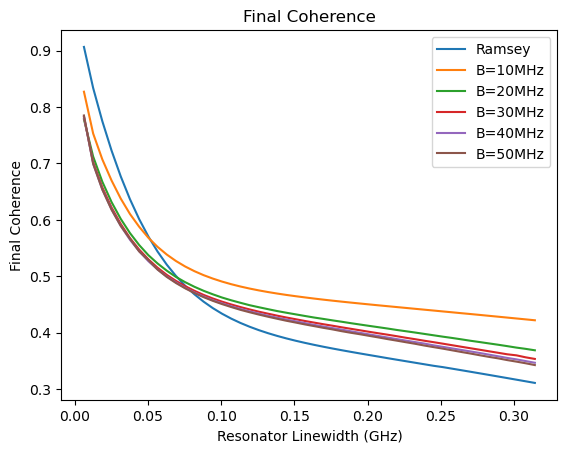

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])

plt.plot(kappa_list, ramsey_coherence_list, label="Ramsey")
#plt.plot(kappa_list, np.exp(-0.01*kappa_list/2*500), label="Only T1")

plt.plot(kappa_list, coherence_list[0:50], label="B=10MHz")
plt.plot(kappa_list, coherence_list[50:100], label="B=20MHz")
plt.plot(kappa_list, coherence_list[100:150], label="B=30MHz")
plt.plot(kappa_list, coherence_list[150:200], label="B=40MHz")
plt.plot(kappa_list, coherence_list[200:250], label="B=50MHz")


plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

Text(0, 0.5, 'Final Z')

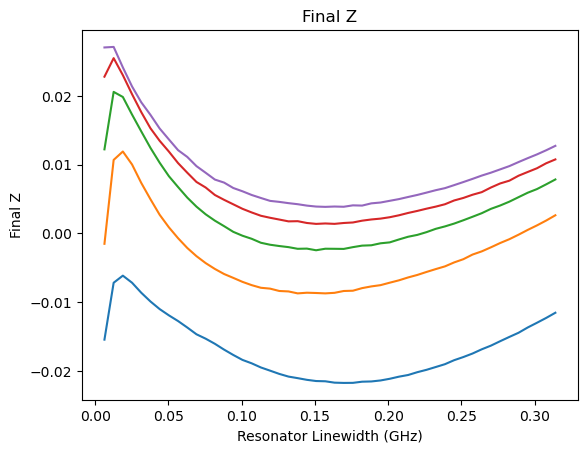

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, z_list[0:50], label="B=10MHz")
plt.plot(kappa_list, z_list[50:100], label="B=20MHz")
plt.plot(kappa_list, z_list[100:150], label="B=30MHz")
plt.plot(kappa_list, z_list[150:200], label="B=40MHz")
plt.plot(kappa_list, z_list[200:250], label="B=50MHz")

plt.title('Final Z')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Z')

# Coherence

XY8

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

In [ ]:
coherence_list = []
z_list = []

In [ ]:
ramsey_coherence_list = []

In [ ]:
N_seq = 0

omega_qd = omega_qd0

for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[i])
      B = 2 * np.pi * 0.01

      kappa = 2 * np.pi * 0.001 * (i+1)


      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500

      rho0 = (psi0 + psi1)/np.sqrt(2)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        rho0,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))

In [ ]:
ramsey_coherence_list

NameError: name 'ramsey_coherence_list' is not defined

In [ ]:
ramsey_coherence_list = np.array([0.9064079232366217,
 0.8336370549495579,
 0.774589214102931,
 0.7227306418843162,
 0.6768739411453287,
 0.6365273942531932,
 0.6012213349837188,
 0.5704510590287839,
 0.5437131619944641,
 0.5205241400405594,
 0.5004332506203164,
 0.48302975345910437,
 0.46803439611547937,
 0.45493099345787913,
 0.44353364796110795,
 0.43359123742574035,
 0.42488588643323716,
 0.4172291470716255,
 0.4104846536048781,
 0.40446345213051965,
 0.3990677515871819,
 0.39419740878892107,
 0.38976453022602425,
 0.38569441527244913,
 0.38193432049062864,
 0.3784112470476102,
 0.37508750077098274,
 0.3719241558516471,
 0.368889296099535,
 0.3659690617975985,
 0.3631162190278151,
 0.36032038490794305,
 0.357563232202263,
 0.3547458526613925,
 0.3520357923014589,
 0.3493339749996418,
 0.34663431773712966,
 0.3439373539414904,
 0.34122681544887057,
 0.33890739282758015,
 0.3361857434151934,
 0.33344644723878103,
 0.3306900544577285,
 0.32791525391502824,
 0.325121253743614,
 0.32230967781973024,
 0.31947976190501776,
 0.31663376284477773,
 0.31377128187709746,
 0.3108947736544877])

## CPMG Coherent Error

In [ ]:
# Simulation

N_seq = 8

omega_qd = omega_qd0
phi = 2 * np.pi / 8 * 0


for j in range(1,5,1):
  print(j)
  for i in range(50):

      A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[i])
      B = 2 * np.pi * 0.010*(j+1)

      kappa = 2 * np.pi * 0.001 * (i+1)


      tlist = np.linspace(0, 500, 5000)
      T_end_q = 500

      rho0 = (psi0 + np.exp(1j*phi)*psi1)/np.sqrt(2)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
        rho0,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      z_list.append(result.expect[2][-1])

1
2
3
4


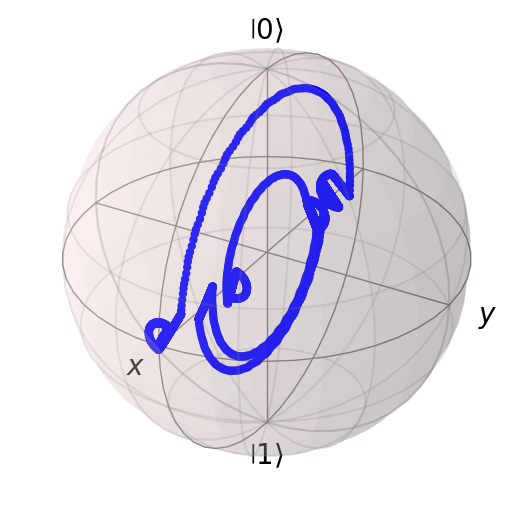

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

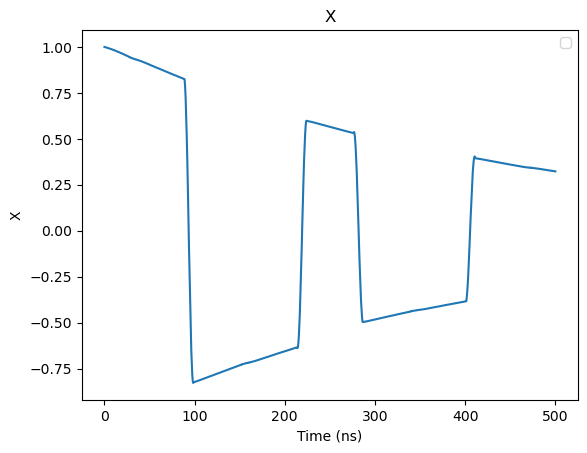

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

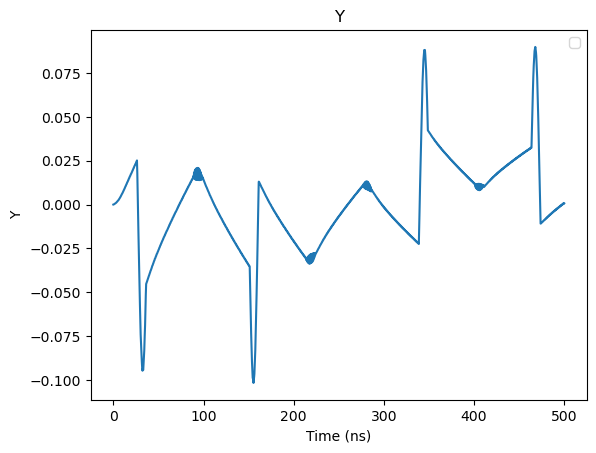

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

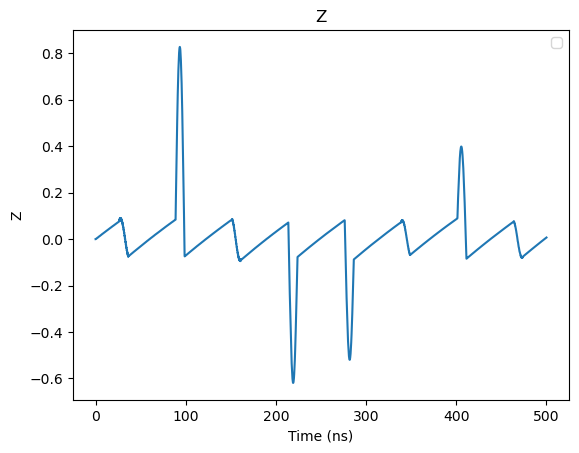

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

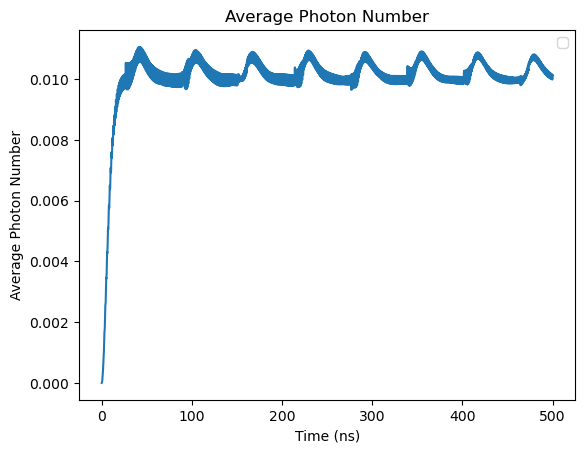

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
coherence_list = np.array([0.6352074353137231,
 0.6302001926581868,
 0.6085637989354397,
 0.5848934232648051,
 0.5645205624081788,
 0.5480421419676106,
 0.5346850746014937,
 0.5236685800481196,
 0.5143836535435381,
 0.5062984167580157,
 0.4989377130522144,
 0.49197325868862996,
 0.48549563296460385,
 0.47929435870632187,
 0.47328066559264004,
 0.467419633472681,
 0.4616608951538719,
 0.45600475763138454,
 0.45043500676505144,
 0.4449364414039106,
 0.4394951375233066,
 0.4341460260082906,
 0.4288251548739898,
 0.42352089916172503,
 0.4183711280362538,
 0.41321818084171913,
 0.40808958617145435,
 0.4030862296077935,
 0.3980420539699153,
 0.39314092331245476,
 0.3882343727328594,
 0.38337788575652115,
 0.3785611605707915,
 0.3738161295585584,
 0.3690616176995867,
 0.3643257377052889,
 0.3597219888540405,
 0.35515102090751205,
 0.35059884004380987,
 0.34609352003365623,
 0.341644841344497,
 0.33722351900407127,
 0.3328317861731191,
 0.32851268309325615,
 0.3242343565799506,
 0.3199617982035404,
 0.31579633780436295,
 0.3116233173038787,
 0.3075278026863135,
 0.30338692894506514,
 0.3476321107579461,
 0.4405697700330929,
 0.47302173641426937,
 0.4832784166511843,
 0.48602064663645844,
 0.4853132920820615,
 0.4835257924759942,
 0.48114961514773413,
 0.4780809038227316,
 0.47502472135196055,
 0.4714572771227514,
 0.4679114773725293,
 0.464353312046766,
 0.46054716810219326,
 0.45663436221960035,
 0.45281989009991985,
 0.4488655573776668,
 0.4448765095265933,
 0.4408424275571896,
 0.43681459072912965,
 0.43269319803161943,
 0.4285614395024367,
 0.424404492476528,
 0.42027346637671126,
 0.41609023813509155,
 0.41191905482804375,
 0.4078334789749723,
 0.403594142668271,
 0.39935517890227507,
 0.3952258264882474,
 0.39106772904506104,
 0.3868420114969128,
 0.3827561491016292,
 0.37851107198855144,
 0.37436328726924567,
 0.3702142991301428,
 0.3660923216170632,
 0.36206256680254584,
 0.358004945430856,
 0.35397668522359005,
 0.34993108344023854,
 0.34584153697170467,
 0.34187544144708465,
 0.3378220054367548,
 0.3339274540397861,
 0.3298961306574894,
 0.3260751449266998,
 0.32217751985624576,
 0.31829990803957253,
 0.3143484662643063,
 0.41455309876245877,
 0.416874035337563,
 0.4404509515874393,
 0.4561624931367739,
 0.4655111470321606,
 0.47022709670771917,
 0.47230952369366536,
 0.4725418001406851,
 0.4713788413110384,
 0.4695273305301797,
 0.4672437405398612,
 0.4645066208571138,
 0.4614232570243307,
 0.4582012480011393,
 0.45483930086807994,
 0.45133738043168237,
 0.44821994114727887,
 0.4441491917479344,
 0.4404007035278481,
 0.4376295042422726,
 0.4328938789311961,
 0.4293231296865453,
 0.42514802184472705,
 0.42121212107285283,
 0.41726138449406647,
 0.41356072297006,
 0.40936262476411056,
 0.4052257920457137,
 0.4012145471386871,
 0.3976544721242812,
 0.3932063629852829,
 0.3900992518198837,
 0.3856889598881907,
 0.38123601868365903,
 0.37720844463193376,
 0.3731873943840143,
 0.36927246095436317,
 0.36582218942953715,
 0.36173708720970593,
 0.35732057833612185,
 0.3534162874450393,
 0.3494598335872573,
 0.34605510524029026,
 0.34159075216947415,
 0.3377465983128439,
 0.3339594357352527,
 0.3300117003150989,
 0.326312980360726,
 0.3229202719638994,
 0.31862160749442914,
 0.4239813981987928,
 0.4002001968513417,
 0.42203414412400847,
 0.44156269942591453,
 0.45500314699225386,
 0.4636478643757038,
 0.46672992017837145,
 0.46906713642226344,
 0.4683850515007109,
 0.4672873399733986,
 0.46724043075531674,
 0.4634349678520982,
 0.4603861115972051,
 0.45758417225314574,
 0.4544423313755562,
 0.45108976448683097,
 0.44804541414651883,
 0.44421534585579553,
 0.4407013273117772,
 0.43711393498064965,
 0.4333939126447409,
 0.429823658805008,
 0.4269776222937226,
 0.42212315770540004,
 0.41822611668969223,
 0.41436669125481174,
 0.41050550887377657,
 0.4065943856911662,
 0.4027629190279354,
 0.39872723551498385,
 0.3951764568535644,
 0.3908631611937023,
 0.3869688362625359,
 0.3830596272131089,
 0.3790930780642637,
 0.3750539324159792,
 0.3712824095631862,
 0.36711146497058467,
 0.3633028503449811,
 0.35946851429642795,
 0.3556143582663872,
 0.3517045758182635,
 0.34774870855234363,
 0.3439287712172386,
 0.341213788588154,
 0.336349330328244,
 0.33245435603435347,
 0.32862511443090003,
 0.32493363997475117,
 0.3211387393509201,
 0.4030971992131957,
 0.3779728402461713,
 0.40354090071695403,
 0.42743385715771903,
 0.44359010679995053,
 0.45454628207029796,
 0.4599816187164218,
 0.46268341862539475,
 0.46392860944574205,
 0.4638085502219169,
 0.46259637569540946,
 0.46077011867436346,
 0.4610327324605772,
 0.45776538714972836,
 0.4531620056963009,
 0.4512159894470706,
 0.44912906545147246,
 0.44375232279907095,
 0.44045744117395336,
 0.4384650094289299,
 0.43483537012810874,
 0.4298384683699784,
 0.42621027634854713,
 0.4236346867800736,
 0.42126396902214786,
 0.41619523144538,
 0.414773934119127,
 0.40969715713210886,
 0.4037529814937287,
 0.4014605946696291,
 0.39595888659382983,
 0.393202555590049,
 0.38822306359225567,
 0.3842333721143773,
 0.38158299964501774,
 0.37768600923094786,
 0.3738657150627333,
 0.3686743837613073,
 0.36496737067384427,
 0.3610126459050123,
 0.35828061326615074,
 0.35460103991503933,
 0.3495218821640131,
 0.34566873179299806,
 0.34163733128340995,
 0.3380199532260451,
 0.33412813612015924,
 0.3315599908041731,
 0.32662680560214963,
 0.3230076534188568])

In [ ]:
z_list = np.array([0.04529757422241905,
 0.03249138304518805,
 0.02112084976523194,
 0.012112115107782389,
 0.005810383556989716,
 0.001590361202249567,
 -0.0012051380944589428,
 -0.0029674562541412318,
 -0.0041066254780824036,
 -0.004668522348298539,
 -0.005323769507816097,
 -0.0054001921808420695,
 -0.005261300284427752,
 -0.005187643789465754,
 -0.005155830503804428,
 -0.004825546495895395,
 -0.004627274670375315,
 -0.004405374713114028,
 -0.0042542947515955745,
 -0.003975232595126127,
 -0.0037771996706534093,
 -0.0035215751150518785,
 -0.003391652002342059,
 -0.0031809149503998686,
 -0.0031244161852143743,
 -0.0028640148224420535,
 -0.0026011012830033453,
 -0.0025589712782338393,
 -0.0023858936873269515,
 -0.0023123386446170643,
 -0.0022540194089730615,
 -0.002052654553002261,
 -0.0020410209768823642,
 -0.002075695191448074,
 -0.001922187651001064,
 -0.0021139784029325774,
 -0.0017459747284019741,
 -0.0017573096534762706,
 -0.0017561548093195914,
 -0.001686252813443934,
 -0.0016544758007836931,
 -0.0015727101308245718,
 -0.0015759263455019789,
 -0.001530297079160899,
 -0.0015307910376399384,
 -0.0015537124450768739,
 -0.0013867100147125322,
 -0.0015015286147751878,
 -0.001462965468917204,
 -0.0015078675433081088,
 0.08052057410119752,
 0.05685243037516045,
 0.03313407698590575,
 0.015770343181193767,
 0.005055633721921315,
 -0.0011915132782842192,
 -0.004181079082932228,
 -0.005545673295849281,
 -0.005761442849867755,
 -0.005610251251154108,
 -0.005031153666391084,
 -0.004454178199787184,
 -0.004005215221693563,
 -0.0032236890058030326,
 -0.0027935977060210755,
 -0.0022893372375076913,
 -0.0017508496018718688,
 -0.0013517965676138868,
 -0.0009166377801426089,
 -0.0006108157793901592,
 -0.00044317628191379595,
 -0.0002348013329654521,
 -2.041184717638656e-05,
 0.00024622580718246814,
 0.0004128950127490418,
 0.0005154379549240995,
 0.0008342923447555311,
 0.0007897097318064939,
 0.0010323582694994754,
 0.0011411478042189806,
 0.0012388551035209866,
 0.0014732691875397796,
 0.0014904390584344735,
 0.0016036051384994503,
 0.0016392751101277298,
 0.001692300286392943,
 0.001802513771203198,
 0.0016955702475010136,
 0.0018862077430038824,
 0.001974623871939638,
 0.0020491009448851583,
 0.002151228189257355,
 0.0022098738429283723,
 0.002320566322562069,
 0.0023250039551885385,
 0.0024090078320677336,
 0.0025292142331619495,
 0.002593354590392899,
 0.0026114469278774827,
 0.002811667091587427,
 0.0843544853219722,
 0.04204865954419805,
 0.01983766113421864,
 0.007532430863736838,
 0.001330092724450472,
 -0.001594213485276257,
 -0.0027015804051174225,
 -0.0028762088115962875,
 -0.002462503725396669,
 -0.0022886823645186113,
 -0.001234395962592141,
 -0.0008065342833698867,
 -0.00012877710751656076,
 0.00042944351947710776,
 0.0008650355841355601,
 0.0014537360451157407,
 0.0018448128271589237,
 0.002218641580935486,
 0.002479882458309867,
 0.0025022925605713334,
 0.002880778076225574,
 0.0030274604971304627,
 0.003269993588363508,
 0.003335070177942681,
 0.003411621677630069,
 0.0035432009200665584,
 0.00345436606468441,
 0.003631200452618653,
 0.003917288810399309,
 0.003826660736433347,
 0.003892490829296922,
 0.003787821478814259,
 0.003888108403679977,
 0.00401507918534324,
 0.004003593775434787,
 0.004157865300500183,
 0.0040443967760541545,
 0.0038821393252469758,
 0.004098605196119704,
 0.004148683422956243,
 0.004288515526926336,
 0.004211755219947607,
 0.004148269869258879,
 0.004402542299543955,
 0.00438460354057682,
 0.004451225464742129,
 0.004475702996187519,
 0.004695561360948414,
 0.0046154542079776635,
 0.00464861030781698,
 0.003483149732565138,
 0.005918289347707348,
 0.0029359245471492273,
 0.0009022805029957017,
 0.00029631719598266596,
 -0.00010089682259220855,
 6.396865382519893e-05,
 0.0009138637988986564,
 0.0011986707547792983,
 0.001922183183390927,
 0.0024832445002753722,
 0.003219893645118138,
 0.0034235465499686275,
 0.0038981640167291315,
 0.004408531173279864,
 0.004537381662573565,
 0.004776823474411698,
 0.004997638946192829,
 0.005167034360744638,
 0.005418200461117015,
 0.005444058611289515,
 0.0053537272457174065,
 0.005661545924201055,
 0.005568185603013602,
 0.0056784278840569784,
 0.005737138383481253,
 0.00585521313044531,
 0.005873258878754963,
 0.006025344469991048,
 0.0056851141306787905,
 0.005678440481934503,
 0.005672880021492478,
 0.00573467090043627,
 0.005687141838016847,
 0.005681279395763852,
 0.005603255559911524,
 0.005651659364381623,
 0.00569897541568671,
 0.005550775137798309,
 0.005700520698075638,
 0.005691006006809073,
 0.005856634243234885,
 0.0056690270337564855,
 0.005732773224599252,
 0.005766124739845987,
 0.005795913646759022,
 0.005832877603977042,
 0.005988805825000422,
 0.006011934452345261,
 0.0059581107921943596,
 -0.02718561288563377,
 -0.008371627352437135,
 -0.00243160396315787,
 -5.4484290823208704e-05,
 0.0013777440766294278,
 0.0029257630563350816,
 0.003426778130297217,
 0.00463455437933104,
 0.0048373494520102265,
 0.005555181415555268,
 0.0060234640998294686,
 0.006265179659973628,
 0.00645470245988431,
 0.006577297099002135,
 0.0071070174796575136,
 0.007141963332199037,
 0.007263143000415449,
 0.0075111464372369045,
 0.007489310808269327,
 0.0075686029569502974,
 0.007568124108727114,
 0.007599775004068169,
 0.007369183227393327,
 0.0075971045115058615,
 0.007660881777519002,
 0.007599083950505898,
 0.0074223524262592745,
 0.007335590380342633,
 0.00727969400698003,
 0.007288839542792225,
 0.007183323915567924,
 0.007175673446105139,
 0.007117394156893279,
 0.006964963428563266,
 0.00689390185769997,
 0.007023776552722944,
 0.007045525696035218,
 0.0070676627150925205,
 0.006924145550104063,
 0.006995219268565994,
 0.0068124798144888095,
 0.00678792502331074,
 0.006808513977582387,
 0.00687107463730069,
 0.006820608253474682,
 0.0067672375064503085,
 0.006819960515492219,
 0.007052343699155235,
 0.00693732854228614,
 0.006885316320087353])

Text(0, 0.5, 'Final Coherence')

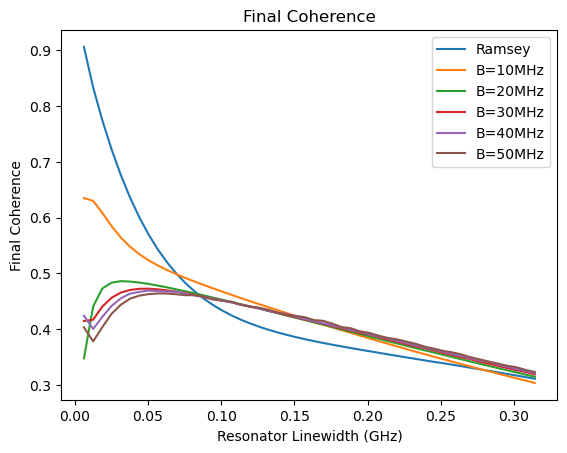

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])

plt.plot(kappa_list, ramsey_coherence_list, label="Ramsey")

plt.plot(kappa_list, coherence_list[0:50], label="B=10MHz")
plt.plot(kappa_list, coherence_list[50:100], label="B=20MHz")
plt.plot(kappa_list, coherence_list[100:150], label="B=30MHz")
plt.plot(kappa_list, coherence_list[150:200], label="B=40MHz")
plt.plot(kappa_list, coherence_list[200:250], label="B=50MHz")


plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

Text(0, 0.5, 'Final Z')

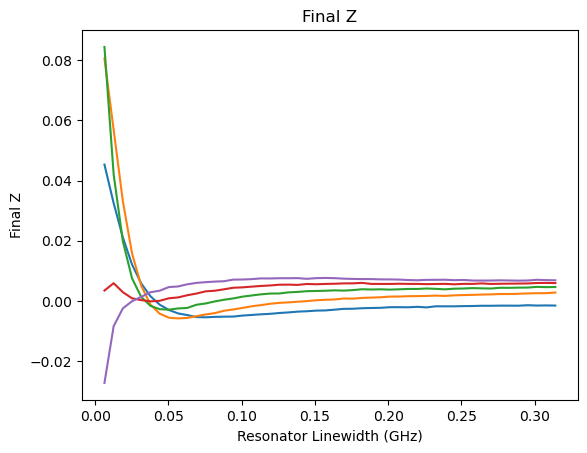

In [ ]:
# Plot Results

kappa_list = np.array([2 * np.pi * 0.001 * (i+1) for i in range(50)])
plt.plot(kappa_list, z_list[0:50], label="B=10MHz")
plt.plot(kappa_list, z_list[50:100], label="B=20MHz")
plt.plot(kappa_list, z_list[100:150], label="B=30MHz")
plt.plot(kappa_list, z_list[150:200], label="B=40MHz")
plt.plot(kappa_list, z_list[200:250], label="B=50MHz")

plt.title('Final Z')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Z')

# Time Evolution

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## Coherence

In [ ]:
ramsey_coherence_list = [0.7979400509614878,
 0.6304292058892816,
 0.49808051987729046,
 0.39351293035242785,
 0.3108947736549328,
 0.24561854288790483,
 0.19404391804374138,
 0.15329473859699533,
 0.12109859419325929,
 0.09566989946545093]

XY4_coherence_list = [0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

XY8_coherence_list = [0.8147510957171269,
 0.6530925476430962,
 0.5170193168826012,
 0.4100490342196163,
 0.3230076534188568,
 0.25706560213688,
 0.2033970513287975,
 0.16207121540087407,
 0.13067360001810388,
 0.10309201272085616]

In [ ]:
# Simulation

ramsey_coherence_list = []
ramsey_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      ramsey_z_list.append(result.expect[2][-1])

0
1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
ramsey_coherence_list

[0.7979400509615002,
 0.6304292058892603,
 0.49808051987729623,
 0.39351293035209917,
 0.3108947736544877]

In [ ]:
# Simulation

XY4_coherence_list = []
XY4_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY4_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY4_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
XY4_coherence_list

[0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

In [ ]:
# Simulation

XY8_coherence_list = []
XY8_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY8_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY8_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
XY8_coherence_list

[0.8147510957171269,
 0.6530925476430962,
 0.5170193168826012,
 0.4100490342196163,
 0.3230076534188568,
 0.25706560213688,
 0.2033970513287975,
 0.16207121540087407,
 0.13067360001810388,
 0.10309201272085616]

In [ ]:
# Simulation

Func1_coherence_list = []
Func1_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(5):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func1_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 30, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      Func1_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      Func1_z_list.append(result.expect[2][-1])

0
1
2
3
4


In [ ]:
Func1_coherence_list

[0.8508885989324918,
 0.6796932325418568,
 0.5401544893635492,
 0.4288925520842308,
 0.344337242986249]

In [ ]:
Func1_z_list

[0.08844327397690216,
 0.27562228588715,
 0.04062043912648263,
 0.032656513026209436,
 0.02877146878632685]

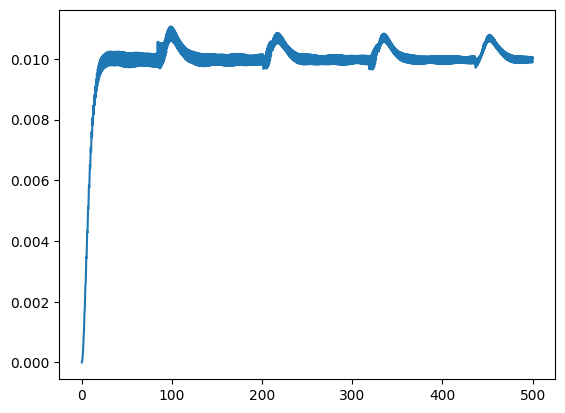

In [ ]:
plt.plot(tlist, result.expect[3])

Text(0, 0.5, 'Final Coherence')

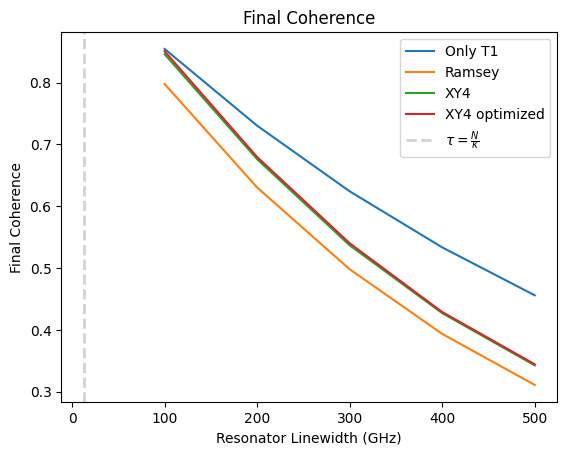

In [ ]:
# Plot Results

tau_list = np.array([100 * (i+1) for i in range(5)])

plt.plot(tau_list, np.exp(-2*np.pi*0.05*0.01*tau_list/2), label="Only T1")
plt.plot(tau_list, ramsey_coherence_list[:5], label="Ramsey")
plt.plot(tau_list, XY4_coherence_list[:5], label="XY4")
plt.plot(tau_list, Func1_coherence_list[:5], label="XY4 optimized")
plt.axvline(12.7, 0, 1, color='lightgray', linestyle='--', linewidth=2, label=r"$\tau = \frac{N}{\kappa}$")

plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

In [ ]:
[0.8559883379131454,
 0.7263142039183907,
 0.6162032545144935,
 0.5227863532837486,
 0.4435336479579692,
 0.37628971610408235,
 0.3192382149686423,
 0.27083916752730414,
 0.22978023404039888,
 0.1949493664805667]

In [ ]:
[0.9186255315056223,
 0.7572420169844762,
 0.6342286516415331,
 0.5361951518408581,
 0.45641750946740356,
 0.38784202156535313,
 0.3308602585230697,
 0.2811104378885798,
 0.23949471974070377,
 0.20425671095568662]

In [ ]:
[0.8361296445059695,
 0.6874035654631373,
 0.565123164929658,
 0.4645854872179838,
 0.3819343424700549,
 0.31398641251088444,
 0.25812595875996336,
 0.21220306591482765,
 0.17445040458073802,
 0.14341461031836406]

In [ ]:
[0.8961030649039956,
 0.7394568036395673,
 0.6080016907398377,
 0.5008811096961293,
 0.41463604192404474,
 0.3421591681146991,
 0.28227481562823964,
 0.23354876091584212,
 0.19420732904853036,
 0.1604193301037232]

In [ ]:
[0.7979400509614878,
 0.6304292058892816,
 0.49808051987729046,
 0.39351293035242785,
 0.3108947736549328,
 0.24561854288790483,
 0.19404391804374138,
 0.15329473859699533,
 0.12109859419325929,
 0.09566989946545093]

In [ ]:
[0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

# Time Evolution

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## Coherence

In [ ]:
# Simulation

ramsey_coherence_list = []
ramsey_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[14])
B = 2 * np.pi * 0.01
kappa = 2 * np.pi * 0.015
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      ramsey_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
ramsey_coherence_list = [0.7263142039183907,
 0.6162032545144935,
 0.5227863532837486,
 0.4435336479579692,
 0.37628971610408235,
 0.3192382149686423,
 0.27083916752730414,
 0.22978023404039888,
 0.1949493664805667]

In [ ]:
ramsey_coherence_list

[0.8559883379131454,
 0.7263142039183907,
 0.6162032545144935,
 0.5227863532837486,
 0.4435336479579692,
 0.37628971610408235,
 0.3192382149686423,
 0.27083916752730414,
 0.22978023404039888,
 0.1949493664805667]

In [ ]:
ramsey_z_list

[0.08730624223585577,
 0.16705745226901156,
 0.2398415432414351,
 0.3062665565696653,
 0.36688801451783015,
 0.42221290208035683,
 0.4727039151327598,
 0.518783327205495,
 0.5608365231013087,
 0.5992152247991385]

In [ ]:
# Simulation

XY4_coherence_list = []
XY4_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[14])
B = 2 * np.pi * 0.01
kappa = 2 * np.pi * 0.015
omega_qd = omega_qd0


for j in range(9):
      print(j)

      tlist = np.linspace(0, 100*(j+2), 1000*(j+2))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY4_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY4_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8


In [ ]:
XY4_coherence_list

[0.7747491403149286,
 0.681453537695822,
 0.5735559814662113,
 0.49145488666352527,
 0.42091147917030286,
 0.35956627072829705,
 0.3082334583986283,
 0.2642993871763225,
 0.22657194405412084]

In [ ]:
# Simulation

XY8_coherence_list = []
XY8_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[14])
B = 2 * np.pi * 0.01
kappa = 2 * np.pi * 0.015
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+2), 1000*(j+2))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY8_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY8_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
XY8_coherence_list

[0.7298528543748287,
 0.6410472096815846,
 0.5634619979002752,
 0.48304344530661186,
 0.3985110169914093,
 0.33454887913429676,
 0.2842098303862978,
 0.24233509564676917,
 0.2069164876876565,
 0.17648189573453105]

Text(0, 0.5, 'Final Coherence')

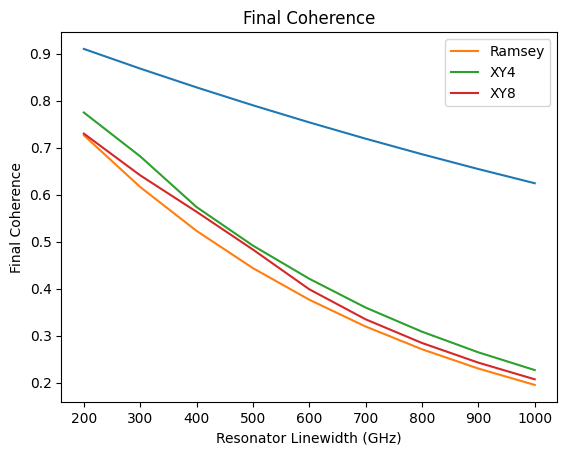

In [ ]:
# Plot Results

tau_list = np.array([100 * (i+2) for i in range(9)])

plt.plot(tau_list, np.exp(- 2 * np.pi * 0.015 * 0.01 * tau_list/2))
plt.plot(tau_list, ramsey_coherence_list, label="Ramsey")
plt.plot(tau_list, XY4_coherence_list, label="XY4")
plt.plot(tau_list, XY8_coherence_list[:9], label="XY8")


plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

In [ ]:
# Simulation

ramsey_coherence_list = []
ramsey_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.025
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      ramsey_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
ramsey_coherence_list

[0.8361296445059695,
 0.6874035654631373,
 0.565123164929658,
 0.4645854872179838,
 0.3819343424700549,
 0.31398641251088444,
 0.25812595875996336,
 0.21220306591482765,
 0.17445040458073802,
 0.14341461031836406]

In [ ]:
ramsey_z_list

[0.14120262144891957,
 0.26260081086825265,
 0.3668387055018746,
 0.4563419046869768,
 0.5331932103233473,
 0.5991810177843925,
 0.6558409321172374,
 0.7044914987936859,
 0.7462648844349263,
 0.7821332210992734]

In [ ]:
# Simulation

XY4_coherence_list = []
XY4_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.025
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY4_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY4_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


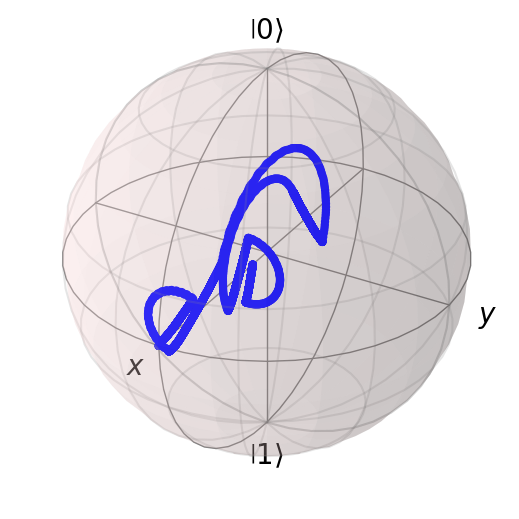

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

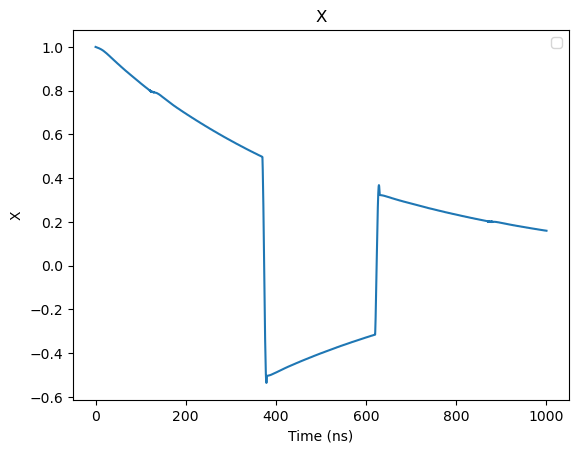

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

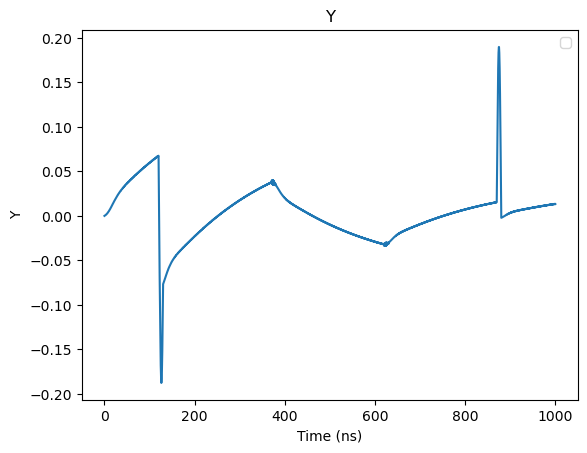

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

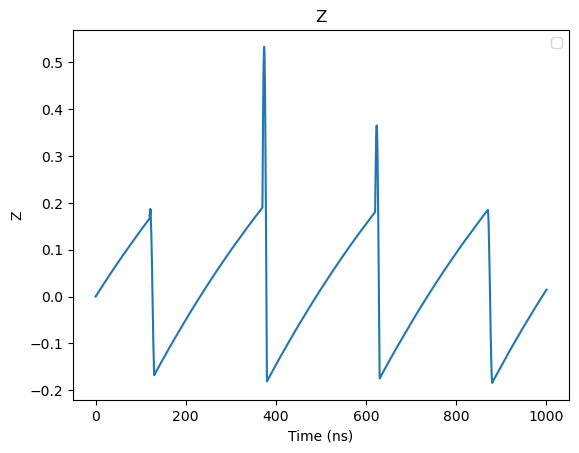

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

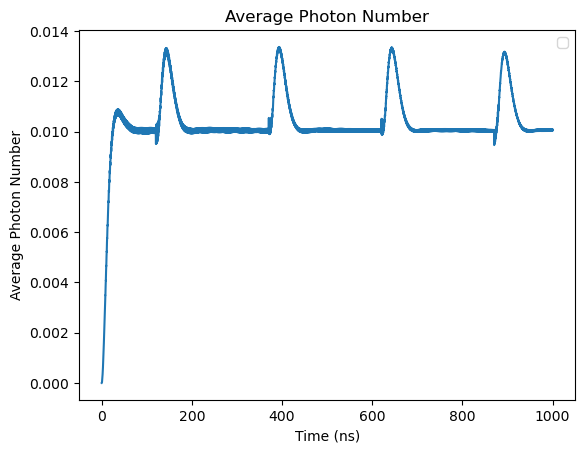

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
XY4_coherence_list

[0.8961030649039956,
 0.7394568036395673,
 0.6080016907398377,
 0.5008811096961293,
 0.41463604192404474,
 0.3421591681146991,
 0.28227481562823964,
 0.23354876091584212,
 0.19420732904853036,
 0.1604193301037232]

In [ ]:
XY4_z_list

[-0.0038207416451627708,
 0.005870183291323483,
 -0.005656933338837871,
 -0.007688002231889781,
 0.0038584227161356966,
 0.006743639994563766,
 0.0010695676472902416,
 0.003967039079812033,
 0.012273392417714992,
 0.014587156490036078]

In [ ]:
# Simulation

XY8_coherence_list = []
XY8_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.025
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY8_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY8_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


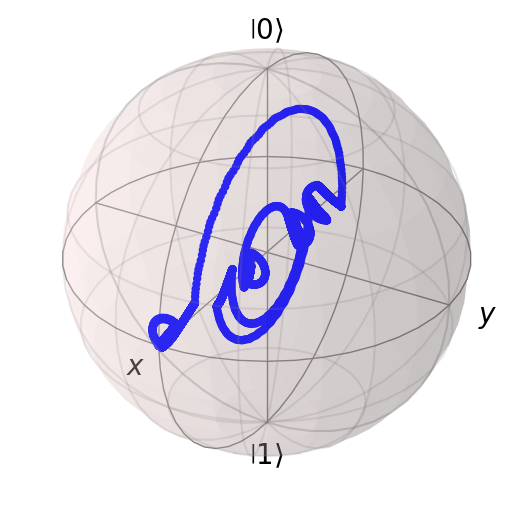

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

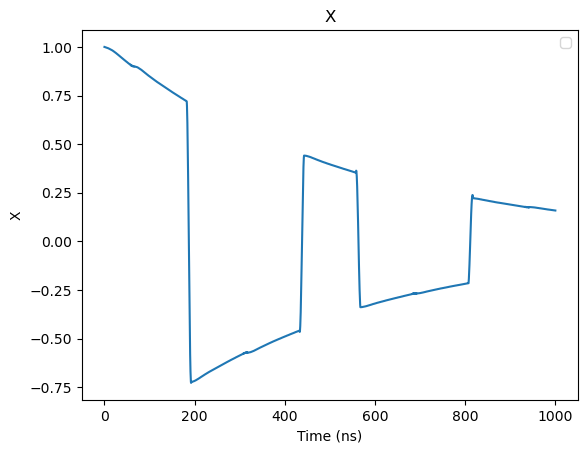

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

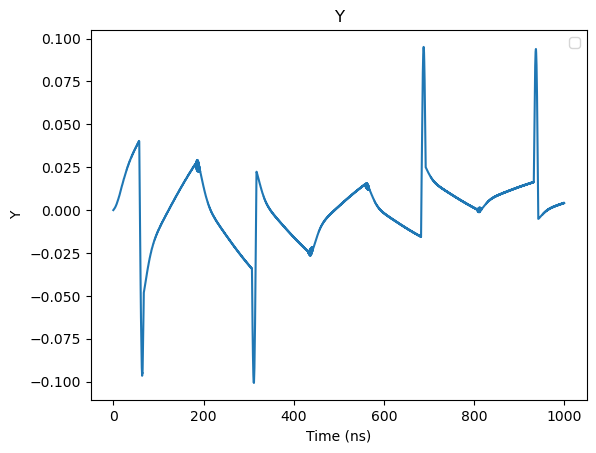

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

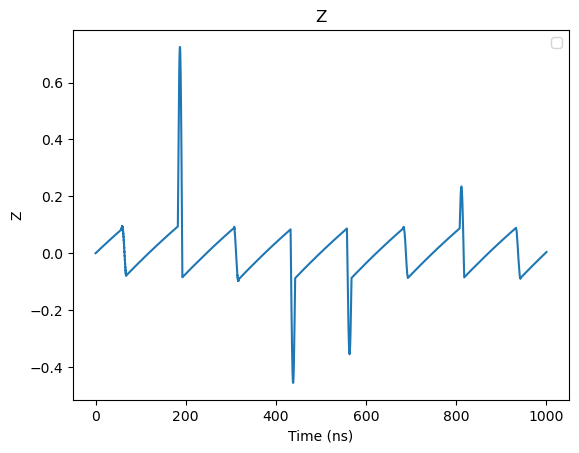

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

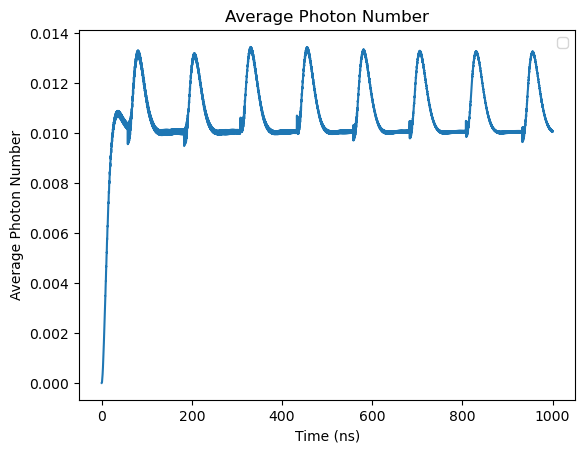

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
XY8_coherence_list

[0.8947058991505313,
 0.7635438492226153,
 0.6257144448927404,
 0.5139778065558922,
 0.42126396902214786,
 0.34589773249466665,
 0.2839504568781188,
 0.23381442850305614,
 0.19353069688945448,
 0.15886454232277453]

In [ ]:
XY8_z_list

[-0.012163574469563211,
 0.002883247460868093,
 0.010166215948011372,
 -0.00033038654715074735,
 0.007660881777519002,
 -0.0001315233759794608,
 -0.0016637591216356986,
 0.0017604737528598676,
 0.00032764645626529916,
 0.003977754792985633]

Text(0, 0.5, 'Final Coherence')

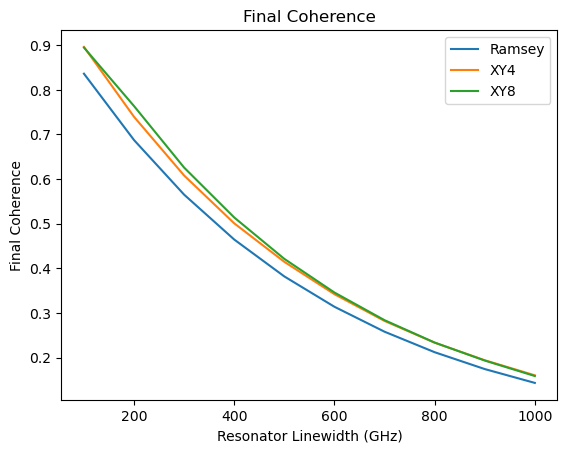

In [ ]:
# Plot Results

tau_list = np.array([100 * (i+1) for i in range(5)])

plt.plot(tau_list, ramsey_coherence_list, label="Ramsey")
plt.plot(tau_list, XY4_coherence_list, label="XY4")
plt.plot(tau_list, XY8_coherence_list, label="XY8")


plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

In [ ]:
# Simulation

ramsey_coherence_list = []
ramsey_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      ramsey_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      ramsey_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


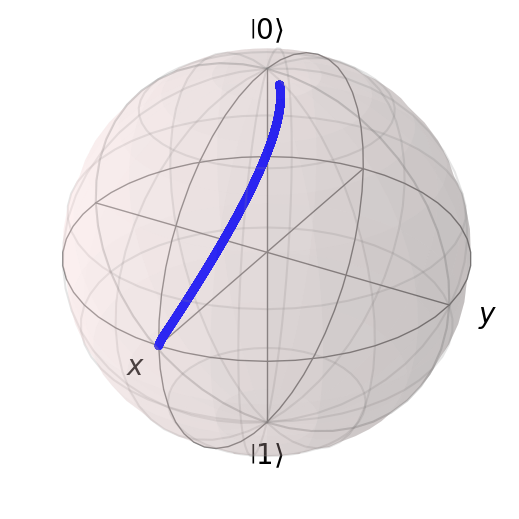

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

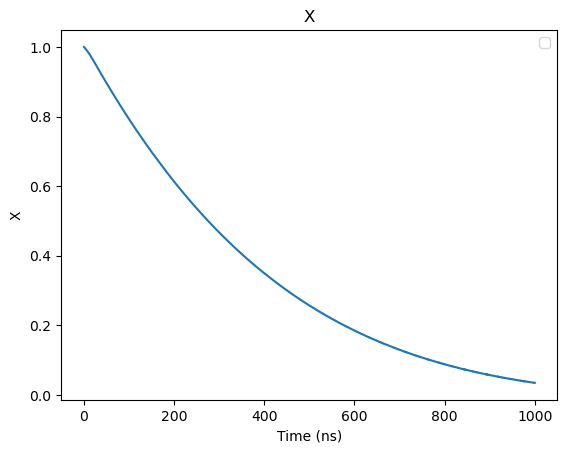

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

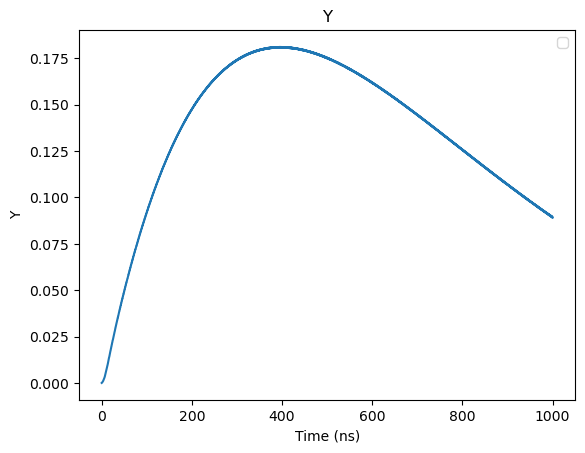

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

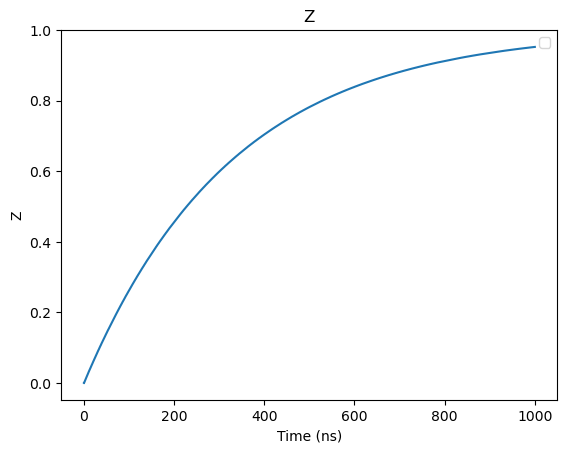

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

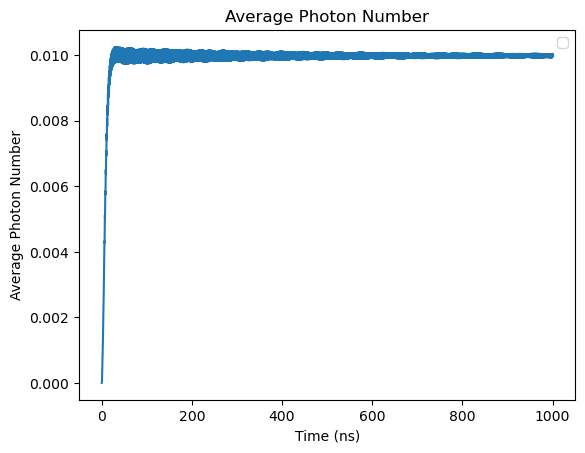

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
ramsey_coherence_list

[0.8361296445059695,
 0.6874035654631373,
 0.565123164929658,
 0.4645854872179838,
 0.3819343424700549,
 0.31398641251088444,
 0.25812595875996336,
 0.21220306591482765,
 0.17445040458073802,
 0.14341461031836406,
 0.7979400509614878,
 0.6304292058892816,
 0.49808051987729046,
 0.39351293035242785,
 0.3108947736549328,
 0.24561854288790483,
 0.19404391804374138,
 0.15329473859699533,
 0.12109859419325929,
 0.09566989946545093]

In [ ]:
ramsey_z_list

[0.14120262144891957,
 0.26260081086825265,
 0.3668387055018746,
 0.4563419046869768,
 0.5331932103233473,
 0.5991810177843925,
 0.6558409321172374,
 0.7044914987936859,
 0.7462648844349263,
 0.7821332210992734,
 0.26232445167049484,
 0.4560796406542949,
 0.5989441381511614,
 0.7042845507158644,
 0.7819567149545668,
 0.8392278068464847,
 0.8814562580976897,
 0.9125930915575051,
 0.9355515802934308,
 0.9524798167634325]

In [ ]:
# Simulation

XY4_coherence_list = []
XY4_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY4_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY4_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


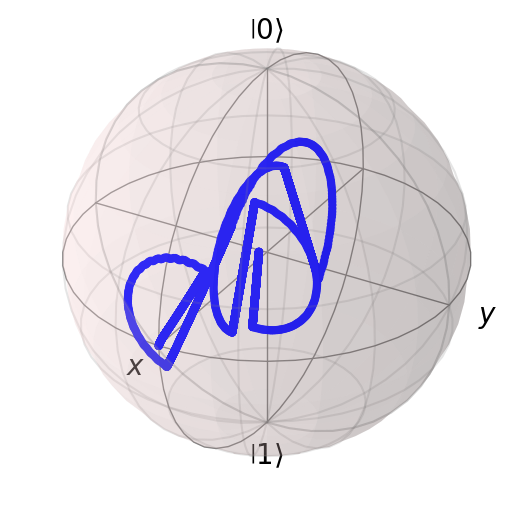

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

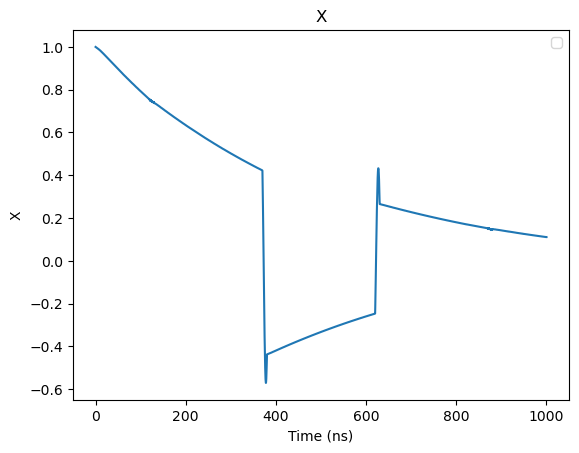

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

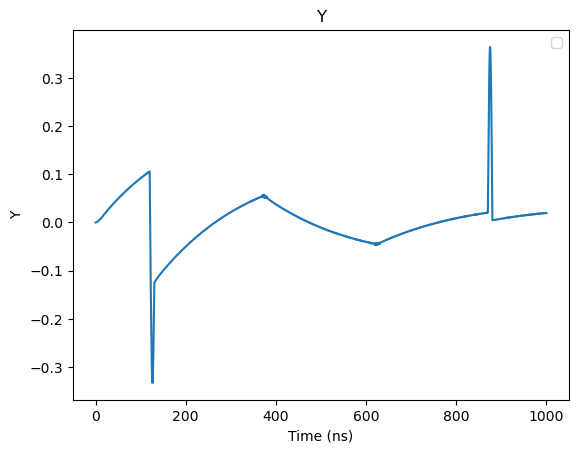

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

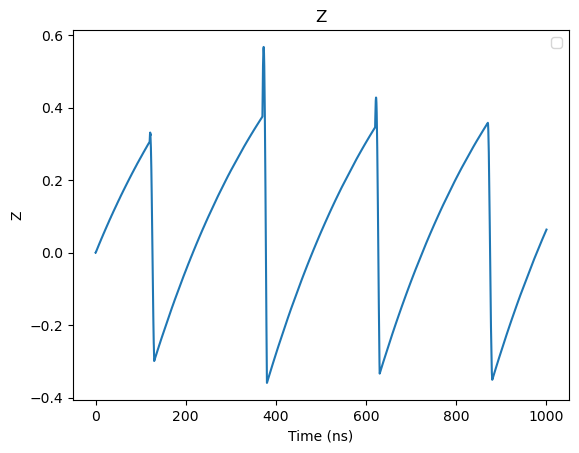

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

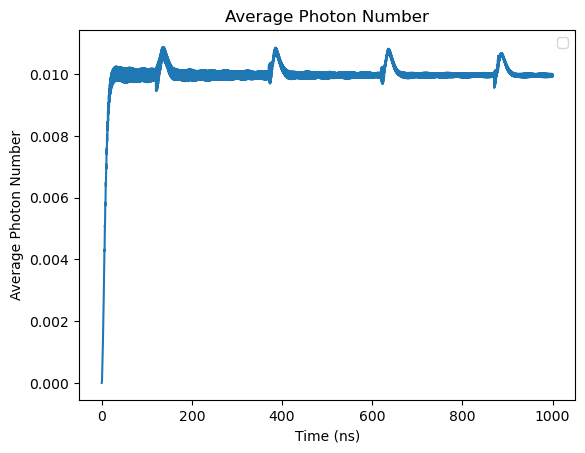

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
XY4_coherence_list

[0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

In [ ]:
XY4_z_list

[-0.00541618684295417,
 0.0028060747300979786,
 -0.004084457185967526,
 -0.0007991706409873179,
 0.012725950127492922,
 0.020566897631451534,
 0.025645682013064768,
 0.03720156056414734,
 0.05159612072162106,
 0.06354676742957178]

In [ ]:
XY4_coherence_list = [0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

In [ ]:
XY4_z_list = [-0.00541618684295417,
 0.0028060747300979786,
 -0.004084457185967526,
 -0.0007991706409873179,
 0.012725950127492922,
 0.020566897631451534,
 0.025645682013064768,
 0.03720156056414734,
 0.05159612072162106,
 0.06354676742957178]

In [ ]:
# Simulation

XY8_coherence_list = []
XY8_z_list = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY8_coherence_list.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY8_z_list.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


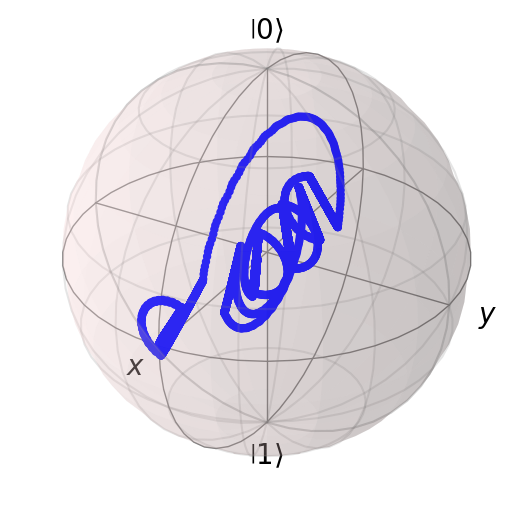

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'X')

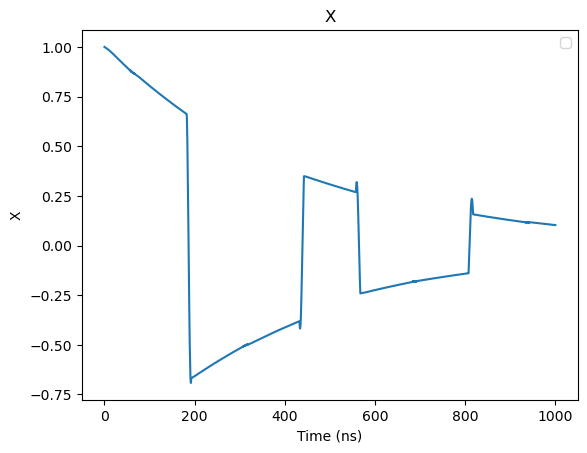

In [ ]:
# Plot Results

plt.plot(tlist, x_rot)

plt.legend()
plt.title('X')
plt.xlabel('Time (ns)')
plt.ylabel('X')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Y')

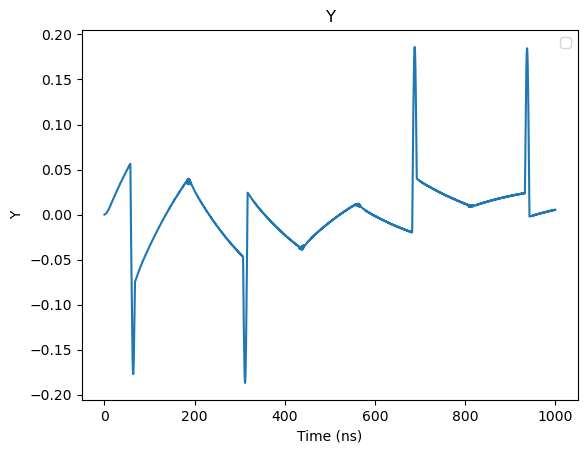

In [ ]:
# Plot Results

plt.plot(tlist, y_rot)

plt.legend()
plt.title('Y')
plt.xlabel('Time (ns)')
plt.ylabel('Y')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Z')

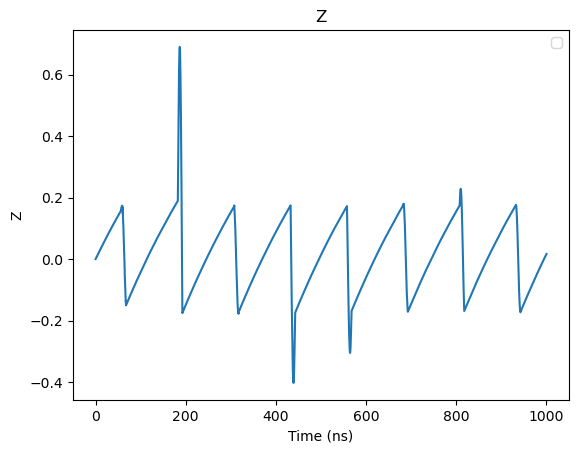

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Time (ns)')
plt.ylabel('Z')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Average Photon Number')

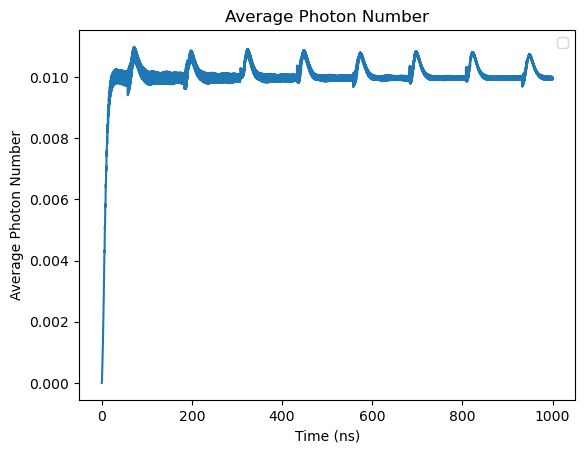

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[3])

plt.legend()
plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
XY8_coherence_list

[0.8147510957171269,
 0.6530925476430962,
 0.5170193168826012,
 0.4100490342196163,
 0.3230076534188568,
 0.25706560213688,
 0.2033970513287975,
 0.16207121540087407,
 0.13067360001810388,
 0.10309201272085616]

In [ ]:
XY8_z_list

[-0.01282289792086113,
 0.0010929292782702576,
 0.008386438408025233,
 0.000580695643011486,
 0.006885316320087353,
 0.0036254120854323298,
 0.004821504611187191,
 0.009562904519118592,
 0.011952944333728349,
 0.01653591034668895]

In [ ]:
# Simulation

XY4_coherence_list_1 = []
XY4_z_list_1 = []


N_seq = 0

A = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
B = 2 * np.pi * 0.05
kappa = 2 * np.pi * 0.050
omega_qd = omega_qd0


for j in range(10):
      print(j)

      tlist = np.linspace(0, 100*(j+1), 1000*(j+1))
      T_end_q = 100*(j+1)


      result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 30, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
        e_ops = op_list,
      )

      x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
      y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

      XY4_coherence_list_1.append(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
      XY4_z_list_1.append(result.expect[2][-1])

0
1
2
3
4
5
6
7
8
9


In [ ]:
XY4_coherence_list_1

[0.8502866698574696,
 0.6790799873738719,
 0.5398828801842592,
 0.428879442977538,
 0.3443289910042567,
 0.2777279380728927,
 0.2188442326916755,
 0.1749027727967959,
 0.142367941311737,
 0.1147854590024279]

In [ ]:
XY4_z_list_1

[0.05536551148468092,
 0.04515296006994864,
 0.04063565159439134,
 0.032671073550809664,
 0.02868671864701563,
 0.030917159762998615,
 0.03664193823245171,
 0.04427557401753066,
 0.05327743970121374,
 0.06345943367341708]

ValueError: x and y must have same first dimension, but have shapes (10,) and (13,)

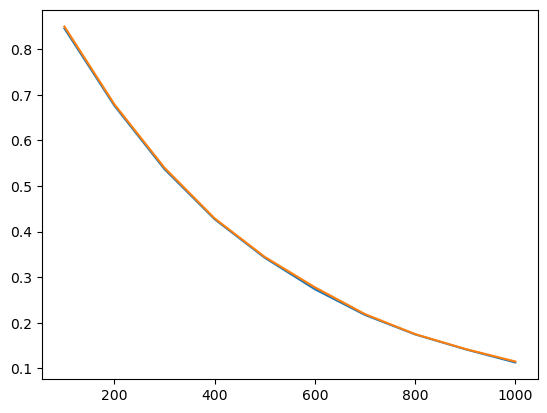

In [ ]:
# Plot Results

tau_list = np.array([100 * (i+1) for i in range(10)])

#plt.plot(tau_list, ramsey_coherence_list[10:], label="Ramsey")
plt.plot(tau_list, XY4_coherence_list, label="XY4")
plt.plot(tau_list, XY4_coherence_list_1, label="XY4 optimized")
plt.plot(tau_list, XY8_coherence_list, label="XY8")


plt.legend()
plt.title('Final Coherence')
plt.xlabel('Resonator Linewidth (GHz)')
plt.ylabel('Final Coherence')

In [ ]:
[0.8559883379131454,
 0.7263142039183907,
 0.6162032545144935,
 0.5227863532837486,
 0.4435336479579692,
 0.37628971610408235,
 0.3192382149686423,
 0.27083916752730414,
 0.22978023404039888,
 0.1949493664805667]

In [ ]:
[0.9186255315056223,
 0.7572420169844762,
 0.6342286516415331,
 0.5361951518408581,
 0.45641750946740356,
 0.38784202156535313,
 0.3308602585230697,
 0.2811104378885798,
 0.23949471974070377,
 0.20425671095568662]

In [ ]:
[0.8361296445059695,
 0.6874035654631373,
 0.565123164929658,
 0.4645854872179838,
 0.3819343424700549,
 0.31398641251088444,
 0.25812595875996336,
 0.21220306591482765,
 0.17445040458073802,
 0.14341461031836406]

In [ ]:
[0.8961030649039956,
 0.7394568036395673,
 0.6080016907398377,
 0.5008811096961293,
 0.41463604192404474,
 0.3421591681146991,
 0.28227481562823964,
 0.23354876091584212,
 0.19420732904853036,
 0.1604193301037232]

In [ ]:
[0.7979400509614878,
 0.6304292058892816,
 0.49808051987729046,
 0.39351293035242785,
 0.3108947736549328,
 0.24561854288790483,
 0.19404391804374138,
 0.15329473859699533,
 0.12109859419325929,
 0.09566989946545093]

In [ ]:
[0.8461193184217569,
 0.6761669016549343,
 0.5368429870729445,
 0.4270891421627179,
 0.34252067749450205,
 0.2734052750762597,
 0.2169924617538448,
 0.17430296411376198,
 0.14175713958522154,
 0.11262449976040168]

# Sequence Optimization

B=0.05

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.6761669016549343

[ 3.5  7.5 12.5 17.5]
0.6767459747348207

[ 3.5  7.5 12.5 17.5]nt cost: -0.6767459747348207]
0.6767459747348207

[ 3.5  8.5 12.5 17.5]
0.6763425396757529

[ 3.5  8.5 12.5 17.5]nt cost: -0.6763425396757529]
0.6763425396757529

[ 3.5  7.5 13.5 17.5]
0.67737916148403

[ 3.5  7.5 13.5 17.5]nt cost: -0.67737916148403]
0.67737916148403

[ 3.5  7.5 13.5 18.5]
0.6771482452729268

[ 3.5  7.5 13.5 18.5]nt cost: -0.6771482452729268]
0.6771482452729268

[ 4.0933882   7.08659172 14.1488396  17.26337537]
0.6779896463927202

[ 4.0933882   7.08659172 14.1488396  17.26337537]]
0.6779896463927202

[ 4.04672095  6.57354732 14.95405697 16.96972149]
0.6815749791405575

[ 4.04672095  6.57354732 14.95405697 16.96972149]]
0.6815749791405575

[ 3.50306328  5.74039653 15.04938525 16.93495632]
0.6796552314573331

[ 3.50306328  5.74039653 15.04938525 16.93495632]]
0.6796552314573331

[ 4.04672095  6.57354732 15.12536512 17.4394592 ]
0.678641512256432

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.681662521083845
       x: [ 4.047e+00  6.575e+00  1.495e+01  1.697e+01]
    nfev: 48
   maxcv: 0.0

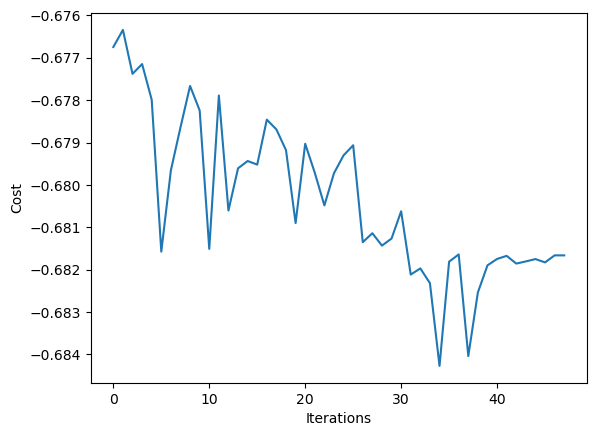

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.6764831019837306

[ 5.  8. 12. 16.]
0.677680438200853

[ 5.  8. 12. 16.]urrent cost: -0.677680438200853]
0.677680438200853

[ 5.  9. 12. 16.]
0.6770726912119199

[ 5.  9. 12. 16.]urrent cost: -0.6770726912119199]
0.6770726912119199

[ 5.  8. 13. 16.]
0.6790423555923989

[ 5.  8. 13. 16.]urrent cost: -0.6790423555923989]
0.6790423555923989

[ 5.  8. 13. 17.]
0.6785702704177047

[ 5.  8. 13. 17.]urrent cost: -0.6785702704177047]
0.6785702704177047

[ 5.60780416  7.6914892  13.69135055 15.76035525]
0.6792884370340586

[ 5.60780416  7.6914892  13.69135055 15.76035525]]
0.6792884370340586

[ 4.8844329   7.42323881 14.29248044 15.55198395]
0.678957695831612

[ 4.8844329   7.42323881 14.29248044 15.55198395]
0.678957695831612

[ 5.5402158   8.16740243 13.7886604  15.66304541]
0.6770531640602606

[ 5.5402158   8.16740243 13.7886604  15.66304541]]
0.6770531640602606

[ 5.93851111  6.77946475 13.64577282 15.99861346]
0.6750015439868333

[ 5.93851111  6.77946475 

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6823622399594185
       x: [ 5.668e+00  7.646e+00  1.368e+01  1.552e+01]
    nfev: 45
   maxcv: 0.0

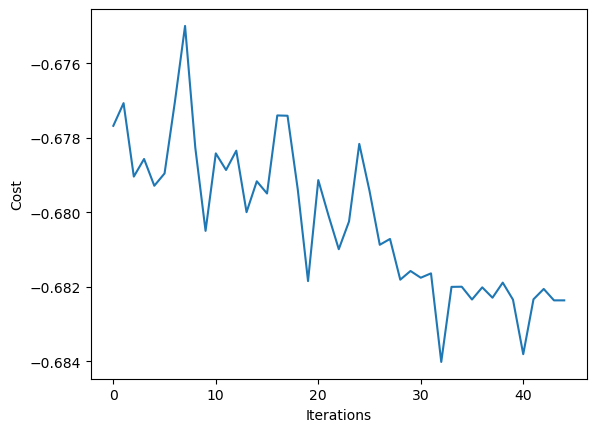

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 400
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 5. 15. 25. 35.]
[ 5. 15. 25. 35.]
0.5008811096961293

[ 6. 15. 25. 35.]
0.5010190761842074

[ 6. 15. 25. 35.]urrent cost: -0.5010190761842074]
0.5010190761842074

[ 6. 16. 25. 35.]
0.5008528624877758

[ 6. 16. 25. 35.]urrent cost: -0.5008528624877758]
0.5008528624877758

[ 6. 15. 26. 35.]
0.5016330893628249

[ 6. 15. 26. 35.]urrent cost: -0.5016330893628249]
0.5016330893628249

[ 6. 15. 26. 36.]
0.5021586487978996

[ 6. 15. 26. 36.]urrent cost: -0.5021586487978996]
0.5021586487978996

[ 6.16491485 14.80132055 26.73394554 36.62821454]
0.5035087551782229

[ 6.16491485 14.80132055 26.73394554 36.62821454]]
0.5035087551782229

[ 5.70363365 15.25216608 27.47303868 36.82237761]
0.5036370815634196

[ 5.70363365 15.25216608 27.47303868 36.82237761]]
0.5036370815634196

[ 5.3437457  14.90530746 27.46000935 36.82237761]
0.5041226036938707

[ 5.3437457  14.90530746 27.46000935 36.82237761]]
0.5041226036938707

[ 5.37096549 14.10334773 27.9853461  37.10546943]
0.5046648662201282

[ 5.37096549 14

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5051113815492592
       x: [ 5.143e+00  1.386e+01  2.781e+01  3.804e+01]
    nfev: 51
   maxcv: 0.0

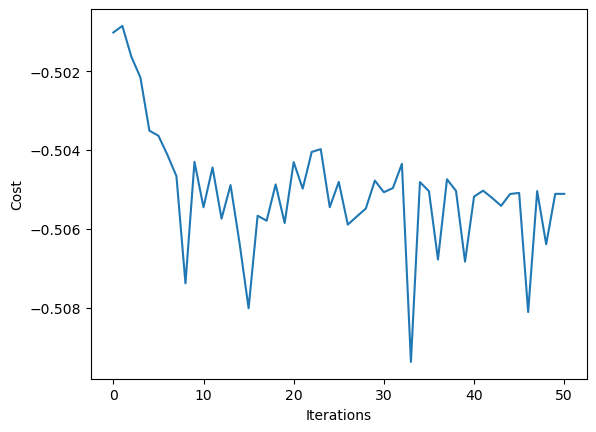

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 400
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 13, 22, 31])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4 13 22 31]
[ 4. 13. 22. 31.]
0.5043792816527477

[ 5. 13. 22. 31.]
0.5007149466748422

[ 5. 13. 22. 31.]urrent cost: -0.5007149466748422]
0.5007149466748422

[ 4. 14. 22. 31.]
0.5021329086065519

[ 4. 14. 22. 31.]urrent cost: -0.5021329086065519]
0.5021329086065519

[ 4. 13. 23. 31.]
0.5026968555690053

[ 4. 13. 23. 31.]urrent cost: -0.5026968555690053]
0.5026968555690053

[ 4. 13. 22. 32.]
0.5052728517770577

[ 4. 13. 22. 32.]urrent cost: -0.5052728517770577]
0.5052728517770577

[ 3.22057595 12.52218419 21.64213879 32.19006724]
0.5003087249028388

[ 3.22057595 12.52218419 21.64213879 32.19006724]]
0.5003087249028388

[ 4.47379832 12.87817377 21.90875797 32.04846046]
0.5010216378526736

[ 4.47379832 12.87817377 21.90875797 32.04846046]]
0.5010216378526736

[ 4.         13.14986578 21.79989941 32.        ]
0.5020377135337352

[ 4.         13.14986578 21.79989941 32.        ]]
0.5020377135337352

[ 3.88834737 13.09470159 22.4775565  32.02247414]
0.5011478786934263

[ 3.88834737 13.094

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5017043035499199
       x: [ 4.000e+00  1.300e+01  2.200e+01  3.200e+01]
    nfev: 40
   maxcv: 0.0

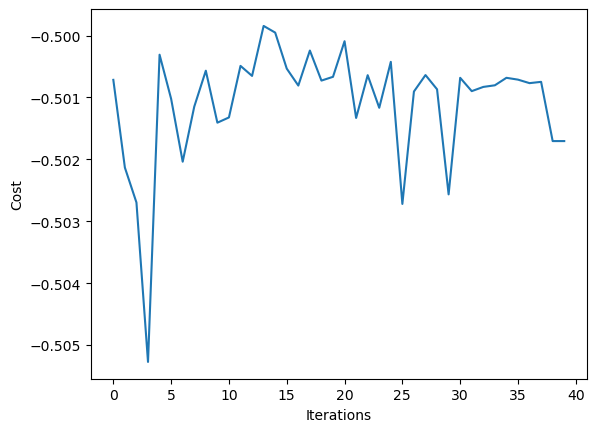

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.2235705331470543

[ 3.5  7.5 12.5 17.5]
0.22863392104983143

[ 3.5  7.5 12.5 17.5]nt cost: -0.22863392104983143]
0.22863392104983143

[ 3.5  8.5 12.5 17.5]
0.2269342320869845

[ 3.5  8.5 12.5 17.5]nt cost: -0.2269342320869845]
0.2269342320869845

[ 3.5  7.5 13.5 17.5]
0.23182031569320383

[ 3.5  7.5 13.5 17.5]nt cost: -0.23182031569320383]
0.23182031569320383

[ 3.5  7.5 13.5 18.5]
0.22890346944919332

[ 3.5  7.5 13.5 18.5]nt cost: -0.22890346944919332]
0.22890346944919332

[ 4.23709876  7.2525691  13.96385692 17.07538238]
0.23624099130113768

[ 4.23709876  7.2525691  13.96385692 17.07538238]8]
0.23624099130113768

[ 4.58831428  6.90975561 14.60652689 16.48707813]
0.23741809423381524

[ 4.58831428  6.90975561 14.60652689 16.48707813]4]
0.23741809423381524

[ 5.27723846  6.7511822  14.90380333 17.12884496]
0.2350441261493805

[ 5.27723846  6.7511822  14.90380333 17.12884496]]
0.2350441261493805

[ 4.58831428  7.35091607 14.84185103 16.487078

[ 4.72849903  8.40135644 15.02325845 15.52608537]74]
0.24490399850705574

[ 4.72851463  8.40141573 15.02335356 15.52614931]
0.24491431497062346

[ 4.72851463  8.40141573 15.02335356 15.52614931]46]
0.24491431497062346

[ 4.72851463  8.40141573 15.02335356 15.52614931]
0.24491431497062346



In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.24491431497062346
       x: [ 4.729e+00  8.401e+00  1.502e+01  1.553e+01]
    nfev: 60
   maxcv: 0.0

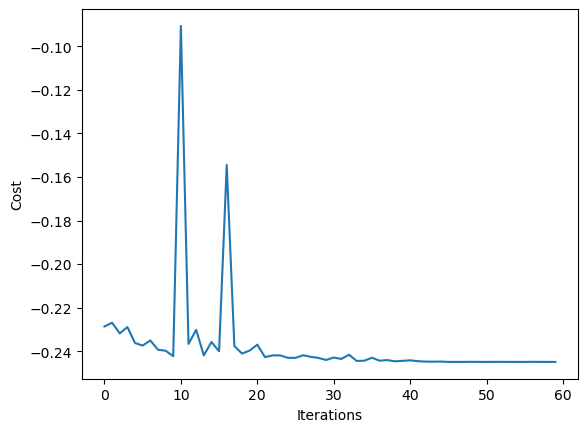

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 200
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.2304605058728664

[ 5.  8. 12. 16.]
0.2339438745457754

[ 5.  8. 12. 16.]urrent cost: -0.2339438745457754]
0.2339438745457754

[ 5.  9. 12. 16.]
0.23297990283460596

[ 5.  9. 12. 16.]urrent cost: -0.23297990283460596]
0.23297990283460596

[ 5.  8. 13. 16.]
0.2366912402995083

[ 5.  8. 13. 16.]urrent cost: -0.2366912402995083]
0.2366912402995083

[ 5.  8. 13. 17.]
0.23544794436002048

[ 5.  8. 13. 17.]urrent cost: -0.23544794436002048]
0.23544794436002048

[ 5.7400225   7.79520952 13.58366273 15.73586862]
0.2390638655098502

[ 5.7400225   7.79520952 13.58366273 15.73586862]]
0.2390638655098502

[ 5.84330833  7.492354   14.44681552 15.3452565 ]
0.23448498158241682

[ 5.84330833  7.492354   14.44681552 15.3452565 ]2]
0.23448498158241682

[ 5.56121868  8.23030757 13.7034936  15.61603775]
0.2394002519514398

[ 5.56121868  8.23030757 13.7034936  15.61603775]]
0.2394002519514398

[ 6.40534335  8.70960469 13.57883619 15.82143577]
0.24042926968746445

[ 6.40534

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.24248166464589865
       x: [ 6.511e+00  9.048e+00  1.408e+01  1.560e+01]
    nfev: 54
   maxcv: 0.0

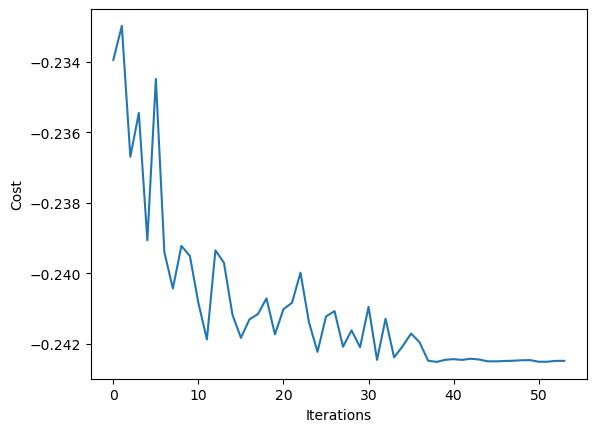

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 2.5  7.5 12.5 17.5]
[ 2.5  7.5 12.5 17.5]
0.1694675921629949

[ 3.5  7.5 12.5 17.5]
0.17487672442246793

[ 3.5  7.5 12.5 17.5]nt cost: -0.17487672442246793]
0.17487672442246793

[ 3.5  8.5 12.5 17.5]
0.17472982926485917

[ 3.5  8.5 12.5 17.5]nt cost: -0.17472982926485917]
0.17472982926485917

[ 3.5  7.5 13.5 17.5]
0.17611454231631726

[ 3.5  7.5 13.5 17.5]nt cost: -0.17611454231631726]
0.17611454231631726

[ 3.5  7.5 13.5 18.5]
0.1751152918430882

[ 3.5  7.5 13.5 18.5]nt cost: -0.1751152918430882]
0.1751152918430882

[ 4.45904513  7.47395533 13.71946648 17.32283179]
0.1789365206953466

[ 4.45904513  7.47395533 13.71946648 17.32283179]]
0.1789365206953466

[ 5.29878074  7.42402779 14.14018287 16.98320101]
0.17710440732254662

[ 5.29878074  7.42402779 14.14018287 16.98320101]2]
0.17710440732254662

[ 4.87891294  7.44899156 13.92982468 17.1530164 ]
0.17820772077538305

[ 4.87891294  7.44899156 13.92982468 17.1530164 ]5]
0.17820772077538305

[ 4.45225841  7.22404746 13.71946648 17.322831

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.1818973870964571
       x: [ 4.849e+00  7.764e+00  1.405e+01  1.731e+01]
    nfev: 57
   maxcv: 0.0

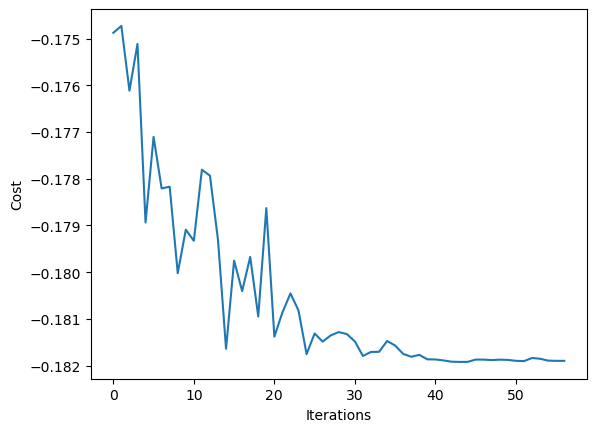

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 200
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 8, 12, 16])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4  8 12 16]
[ 4.  8. 12. 16.]
0.17256596436780483

[ 5.  8. 12. 16.]
0.1748925447984698

[ 5.  8. 12. 16.]urrent cost: -0.1748925447984698]
0.1748925447984698

[ 5.  9. 12. 16.]
0.17479631330033024

[ 5.  9. 12. 16.]urrent cost: -0.17479631330033024]
0.17479631330033024

[ 5.  8. 13. 16.]
0.17483569346935293

[ 5.  8. 13. 16.]urrent cost: -0.17483569346935293]
0.17483569346935293

[ 5.  8. 12. 17.]
0.1770414658353576

[ 5.  8. 12. 17.]urrent cost: -0.1770414658353576]
0.1770414658353576

[ 5.73414051  7.96963464 11.98206085 17.678081  ]
0.17980150253112298

[ 5.73414051  7.96963464 11.98206085 17.678081  ]8]
0.17980150253112298

[ 6.36926132  7.93509168 11.96165368 18.44945114]
0.1736035088692663

[ 6.36926132  7.93509168 11.96165368 18.44945114]]
0.1736035088692663

[ 5.71347729  7.4700618  11.98206085 17.678081  ]
0.17590633582848564

[ 5.71347729  7.4700618  11.98206085 17.678081  ]4]
0.17590633582848564

[ 5.98702815  8.90158801 11.9751893  17.93781848]
0.1806068917501813

[ 5.98

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.1831050252107399
       x: [ 6.344e+00  8.882e+00  1.198e+01  1.829e+01]
    nfev: 55
   maxcv: 0.0

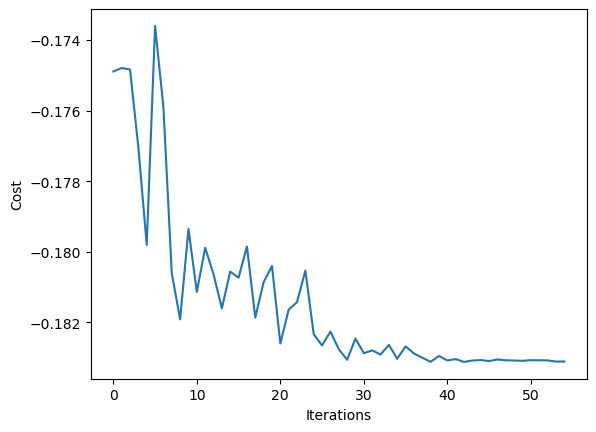

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Sequence Optimization

## Setting

In [ ]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_bare = tensor(sx, qeye(N))
sy_bare = tensor(sy, qeye(N))
sz_bare = tensor(sz, qeye(N))
sp_bare = tensor(sp, qeye(N))
number_bare = tensor(qeye(2), a.dag()*a)


H0 = -0.5*omega_q*sz_bare + omega_r*number_bare + g*(tensor(sp, a) + tensor(sm, a.dag()))

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1)*H0.eigenstates()[1][4]*(-1)*H0.eigenstates()[1][5].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*(-1)*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][3].dag() \
+ (-1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][5].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][7].dag() \
+ (-1)*(-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][9].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][4].dag() + (+1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][6].dag() \
+ (-1)*(+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][8].dag() \


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
- H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


number_dressed = 0*H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + 0*H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() \
+ 1*H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + 1*H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() \
+ 2*H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() + 2*H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ 3*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 3*H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() \
+ 4*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 4*H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \


psi0 = H0.eigenstates()[1][0]
psi1 = (-1)*H0.eigenstates()[1][1]
psis = (psi0 + psi1)/np.sqrt(2)


H1 = tensor(qeye(2), a + a.dag())
H2 = sx_bare

op_list = [sx_dressed, sy_dressed, sz_dressed, number_dressed]

omega_qd0 = 2 * np.pi * 5.9901545

## XY4 Pulse Sequence Setting

Change sequences

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Func (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def Func_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    N = args['N_seq']
    B = args['B']
    Time_Seq = args['Time_seq']
    T = args['Total_time']

    # T_cent
    pulse = 0
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[0], 0.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Time_Seq[3], 1.0*np.pi)


    return pulse

def cost_func(params, N_seq, A, T, kappa):

  tlist = np.linspace(0, T, T*10)

  B = 2 * np.pi * 0.05
  omega_rd = omega_r

  result = mesolve(
        [H0, [H1, Hrd_lab_frame], [H2, Func_lab_frame]],
        psis,
        tlist,
        c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
        args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd,
                'B': B, 'T_srt_q': 0, 'T_end_q': T, 'N_seq': N_seq, 'Omega_qd': omega_qd0,
                'Time_seq': 10*params, 'Omega_qd': omega_qd0, 'Total_time': T},
        e_ops = op_list,
  )

  print(params)
  print(np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2))
  print()


  return -np.sqrt(result.expect[0][-1]**2 + result.expect[1][-1]**2)

def build_callback(N_seq, A, T, kappa, callback_dict):

  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func(current_vector, N_seq, A, T, kappa)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.8461193184217569

[2.25 3.75 6.25 8.75]
0.8479420463595494

[2.25 3.75 6.25 8.75]nt cost: -0.8479420463595494]
0.8479420463595494

[2.25 4.75 6.25 8.75]
0.8475202337411939

[2.25 4.75 6.25 8.75]nt cost: -0.8475202337411939]
0.8475202337411939

[2.25 3.75 7.25 8.75]
0.8488266046106903

[2.25 3.75 7.25 8.75]nt cost: -0.8488266046106903]
0.8488266046106903

[2.25 3.75 7.25 9.75]
0.8443607538622572

[2.25 3.75 7.25 9.75]nt cost: -0.8443607538622572]
0.8443607538622572

[2.62031922 3.66430135 7.42971356 7.84268393]
0.6282302415175782

[2.62031922 3.66430135 7.42971356 7.84268393]5782]
0.6282302415175782

[1.75001418 3.74965265 7.25072842 8.74632246]
0.8482852166331891

[1.75001418 3.74965265 7.25072842 8.74632246]1891]
0.8482852166331891

[2.25017368 3.50000006 7.25       8.75      ]
0.848571293964876

[2.25017368 3.50000006 7.25       8.75      ]876]
0.848571293964876

[2.36633295 3.85651396 7.34218798 8.28457246]
0.8473814653796786

[2.3663329

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8504595008808409
       x: [ 2.528e+00  3.808e+00  7.523e+00  8.773e+00]
    nfev: 47
   maxcv: 0.0

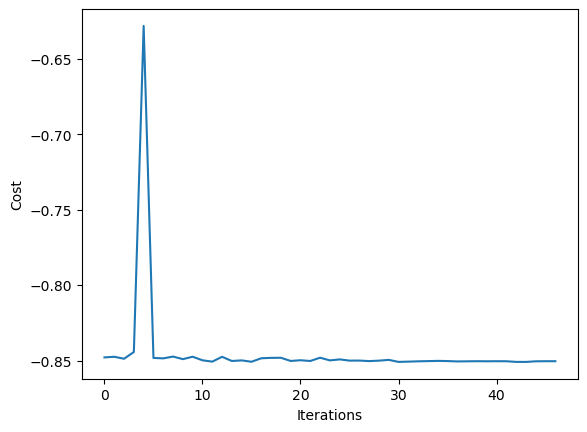

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.8508623475748047

[5.  5.5 7.  8.5]
0.8227930718334828

[5.  5.5 7.  8.5]urrent cost: -0.8227930718334828]
0.8227930718334828

[4.  6.5 7.  8.5]
0.8403423896590752

[4.  6.5 7.  8.5]urrent cost: -0.8403423896590752]
0.8403423896590752

[4.  5.5 8.  8.5]
0.7559985222828489

[4.  5.5 8.  8.5]urrent cost: -0.7559985222828489]
0.7559985222828489

[4.  5.5 7.  9.5]
0.8480924919630759

[4.  5.5 7.  9.5]urrent cost: -0.8480924919630759]
0.8480924919630759

[3.71796966 5.39429911 6.04684121 8.47216945]
0.8441446520127842

[3.71796966 5.39429911 6.04684121 8.47216945]7842]
0.8441446520127842

[3.85898483 5.44714956 6.52342061 8.48608473]
0.8485139997551834

[3.85898483 5.44714956 6.52342061 8.48608473]1834]
0.8485139997551834

[4.24076428 5.49258266 6.93311404 8.49804705]
0.8520558919568877

[4.24076428 5.49258266 6.93311404 8.49804705]8877]
0.8520558919568877

[4.24076428 5.36834425 6.9468915  8.49804705]
0.8515699009406492

[4.24076428 5.36834425 6.946891

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8524783433110804
       x: [ 4.241e+00  5.493e+00  6.932e+00  8.498e+00]
    nfev: 46
   maxcv: 0.0

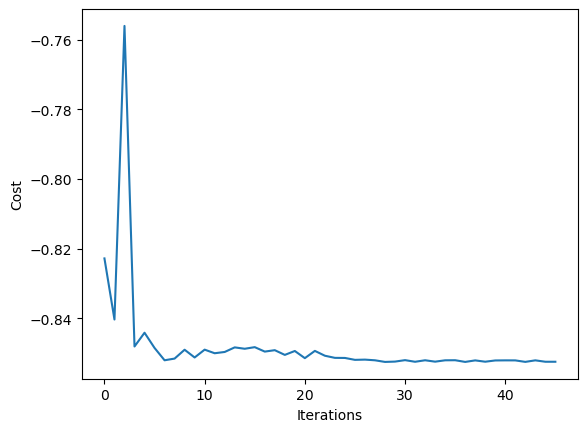

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 500
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 6.25 18.75 31.25 43.75]
[ 6.25 18.75 31.25 43.75]
0.41463604192404474

[ 7.25 18.75 31.25 43.75]
0.41414315985272826

[ 7.25 18.75 31.25 43.75]ost: -0.41414315985272826]
0.41414315985272826

[ 6.25 19.75 31.25 43.75]
0.4143965251595668

[ 6.25 19.75 31.25 43.75]ost: -0.4143965251595668]
0.4143965251595668

[ 6.25 18.75 32.25 43.75]
0.4154315135040432

[ 6.25 18.75 32.25 43.75]ost: -0.4154315135040432]
0.4154315135040432

[ 6.25 18.75 32.25 44.75]
0.4148642438779352

[ 6.25 18.75 32.25 44.75]ost: -0.4148642438779352]
0.4148642438779352

[ 5.8100093  18.53618587 32.96010921 43.2436043 ]
0.4156094773747984

[ 5.8100093  18.53618587 32.96010921 43.2436043 ]]
0.4156094773747984

[ 6.66364711 18.41216756 33.37199287 42.9498803 ]
0.41439281133235173

[ 6.66364711 18.41216756 33.37199287 42.9498803 ]3]
0.41439281133235173

[ 5.83779894 19.02972722 33.01323488 43.19047864]
0.4135862299384051

[ 5.83779894 19.02972722 33.01323488 43.19047864]]
0.4135862299384051

[ 5.41038748 17.62723213 32.90

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4160760975160528
       x: [ 5.792e+00  1.856e+01  3.297e+01  4.323e+01]
    nfev: 48
   maxcv: 0.0

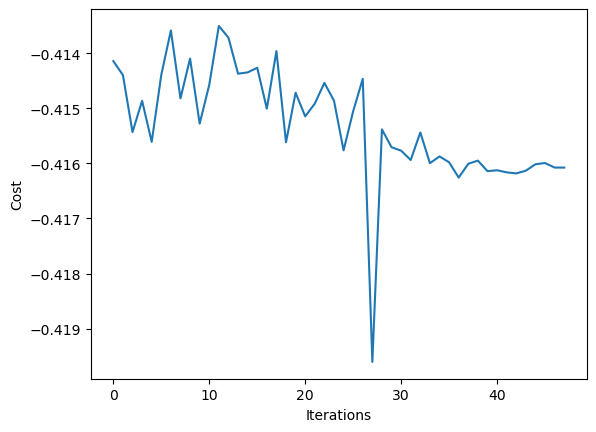

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.01/photon_list[24])
T     = 500
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 15.5, 27, 38.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[ 4.  15.5 27.  38.5]
[ 4.  15.5 27.  38.5]
0.4155484313376564

[ 5.  15.5 27.  38.5]
0.4135418199698995

[ 5.  15.5 27.  38.5]nt cost: -0.4135418199698995]
0.4135418199698995

[ 4.  16.5 27.  38.5]
0.4157465161633112

[ 4.  16.5 27.  38.5]nt cost: -0.4157465161633112]
0.4157465161633112

[ 4.  16.5 28.  38.5]
0.4161697400727478

[ 4.  16.5 28.  38.5]nt cost: -0.4161697400727478]
0.4161697400727478

[ 4.  16.5 28.  39.5]
0.41539218458280186

[ 4.  16.5 28.  39.5]nt cost: -0.41539218458280186]
0.41539218458280186

[ 3.0887919  16.5899509  28.19218722 38.14690977]
0.41252997654691104

[ 3.0887919  16.5899509  28.19218722 38.14690977]4]
0.41252997654691104

[ 4.48972095 16.52202408 28.04705619 38.41354742]
0.4146621054390946

[ 4.48972095 16.52202408 28.04705619 38.41354742]]
0.4146621054390946

[ 3.98876817 16.74974756 28.         38.5       ]
0.4141467499825514

[ 3.98876817 16.74974756 28.         38.5       ]]
0.4141467499825514

[ 3.83537016 16.03058821 28.02413944 38.45565054]
0.412

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.41394446695460496
       x: [ 4.000e+00  1.650e+01  2.800e+01  3.850e+01]
    nfev: 40
   maxcv: 0.0

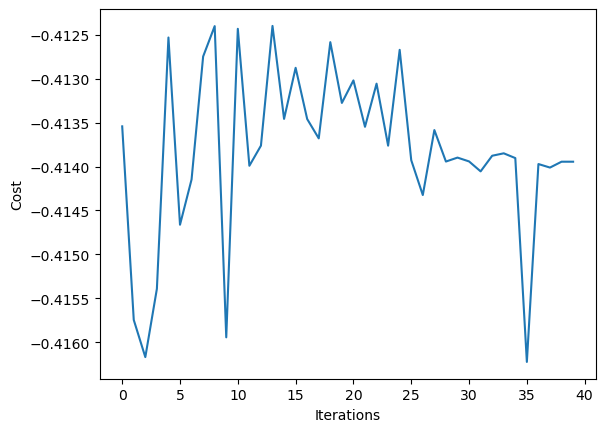

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.5732000798223357

[2.25 3.75 6.25 8.75]
0.5901605509556331

[2.25 3.75 6.25 8.75]nt cost: -0.5901605509556331]
0.5901605509556331

[2.25 4.75 6.25 8.75]
0.5886110139698724

[2.25 4.75 6.25 8.75]nt cost: -0.5886110139698724]
0.5886110139698724

[2.25 3.75 7.25 8.75]
0.5902815197133114

[2.25 3.75 7.25 8.75]nt cost: -0.5902815197133114]
0.5902815197133114

[2.25 3.75 7.25 9.75]
0.5624942368117333

[2.25 3.75 7.25 9.75]nt cost: -0.5624942368117333]
0.5624942368117333

[2.77039541 3.70245581 7.25371166 7.89740726]
0.5671207076349516

[2.77039541 3.70245581 7.25371166 7.89740726]9516]
0.5671207076349516

[1.77223704 3.7417902  7.25064092 8.60277657]
0.5860250833351295

[1.77223704 3.7417902  7.25064092 8.60277657]1295]
0.5860250833351295

[2.25429533 3.5000369  7.25       8.75      ]
0.5866062134562771

[2.25429533 3.5000369  7.25       8.75      ]2771]
0.5866062134562771

[2.48932156 3.95852727 7.25168178 8.3636857 ]
0.5886286368239846

[2.4893

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6005501798615517
       x: [ 2.741e+00  4.413e+00  7.211e+00  8.886e+00]
    nfev: 56
   maxcv: 0.0

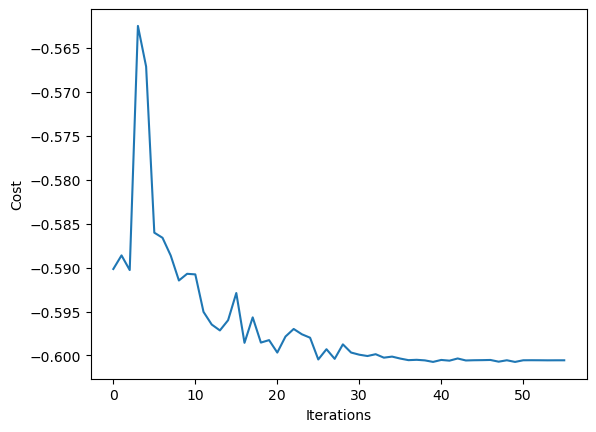

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[49])
T     = 100
kappa = 2 * np.pi * 0.050

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.6042610943699251

[5.  5.5 7.  8.5]
0.5601090379059487

[5.  5.5 7.  8.5]urrent cost: -0.5601090379059487]
0.5601090379059487

[4.  6.5 7.  8.5]
0.5612133194859916

[4.  6.5 7.  8.5]urrent cost: -0.5612133194859916]
0.5612133194859916

[4.  5.5 8.  8.5]
0.5417137736493293

[4.  5.5 8.  8.5]urrent cost: -0.5417137736493293]
0.5417137736493293

[4.  5.5 7.  9.5]
0.5848030001434079

[4.  5.5 7.  9.5]urrent cost: -0.5848030001434079]
0.5848030001434079

[3.50921857 5.02149344 6.30474216 8.28370948]
0.5987482294361649

[3.50921857 5.02149344 6.30474216 8.28370948]1649]
0.5987482294361649

[3.75460928 5.26074672 6.65237108 8.39185474]
0.6027158820467673

[3.75460928 5.26074672 6.65237108 8.39185474]7673]
0.6027158820467673

[4.2200775  5.43486529 6.90536093 8.47055836]
0.5996841981800327

[4.2200775  5.43486529 6.90536093 8.47055836]0327]
0.5996841981800327

[4.         5.6029695  6.92913193 8.5       ]
0.6038901177619547

[4.         5.6029695  6.929131

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6053491923585383
       x: [ 4.040e+00  5.502e+00  7.015e+00  8.492e+00]
    nfev: 54
   maxcv: 0.0

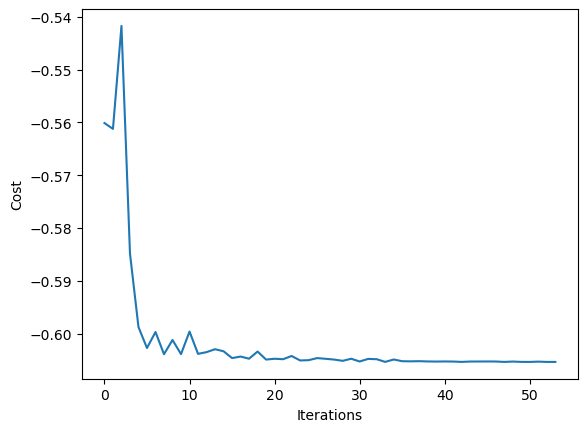

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 100
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array(x0)

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[1.25 3.75 6.25 8.75]
[1.25 3.75 6.25 8.75]
0.5898671550414152

[2.25 3.75 6.25 8.75]
0.610728529909005

[2.25 3.75 6.25 8.75]nt cost: -0.610728529909005]
0.610728529909005

[2.25 4.75 6.25 8.75]
0.6136741945199186

[2.25 4.75 6.25 8.75]nt cost: -0.6136741945199186]
0.6136741945199186

[2.25 4.75 7.25 8.75]
0.607551448311332

[2.25 4.75 7.25 8.75]nt cost: -0.607551448311332]
0.607551448311332

[2.25 4.75 6.25 9.75]
0.5165058405721389

[2.25 4.75 6.25 9.75]nt cost: -0.5165058405721389]
0.5165058405721389

[2.45942104 4.77957064 6.1885356  7.77455624]
0.600650290340891

[2.45942104 4.77957064 6.1885356  7.77455624]891]
0.600650290340891

[2.35471052 4.76478532 6.2192678  8.26227812]
0.6167305891913634

[2.35471052 4.76478532 6.2192678  8.26227812]3634]
0.6167305891913634

[2.59914071 4.76478532 6.2192678  8.31475559]
0.6247126655516435

[2.59914071 4.76478532 6.2192678  8.31475559]6435]
0.6247126655516435

[3.08819692 4.80924048 6.126865   8.33234777]
0.624375986122756

[3.08819692 4.809

[2.73419393 4.70268088 6.51942719 8.66890423]
0.6389564853890225

[2.73419393 4.70268088 6.51942719 8.66890423]90225]
0.6389564853890225

[2.73422852 4.70272577 6.51935511 8.66883636]
0.6389103608828632

[2.73422852 4.70272577 6.51935511 8.66883636]28632]
0.6389103608828632

[2.7340748  4.70269602 6.51940498 8.66891083]
0.6389974709183216

[2.7340748  4.70269602 6.51940498 8.66891083]83216]
0.6389974709183216

[2.73400767 4.70269089 6.51947795 8.66889888]
0.6389906727202573

[2.73400767 4.70269089 6.51947795 8.66889888]02573]
0.6389906727202573

[2.73401261 4.702707   6.51932746 8.66891125]
0.6389901746041622

[2.73401261 4.702707   6.51932746 8.66891125]41622]
0.6389901746041622

[2.73401261 4.702707   6.51932746 8.66891125]
0.6389901746041622



In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6389901746041622
       x: [ 2.734e+00  4.703e+00  6.519e+00  8.669e+00]
    nfev: 66
   maxcv: 0.0

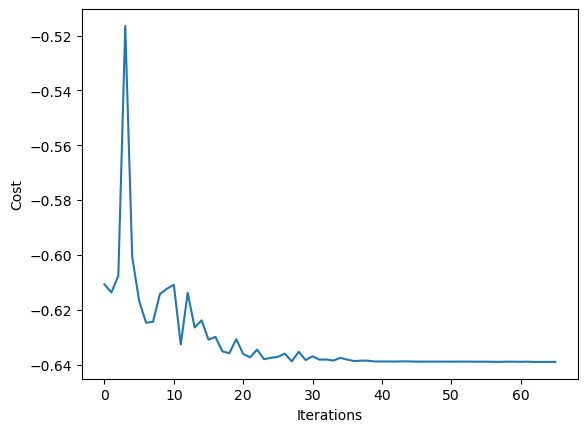

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}


N_seq = 4
A     = 2 * np.pi * 0.001 * np.sqrt(0.1/photon_list[24])
T     = 100
kappa = 2 * np.pi * 0.025

x0 = []
for i in range(N_seq):
  x0.append(0.1*Pulse_Timing(0, T, N_seq)[i])

x0 = np.array([4, 5.5, 7, 8.5])

print(x0)

callback = build_callback(N_seq, A, T, kappa, callback_dict)
res = minimize(
  cost_func,
  x0,
  args=(N_seq, A, T, kappa),
  method="cobyla",
  callback=callback,
)

[4.  5.5 7.  8.5]
[4.  5.5 7.  8.5]
0.6159416721860969

[5.  5.5 7.  8.5]
0.52033207599961

[5.  5.5 7.  8.5]urrent cost: -0.52033207599961]
0.52033207599961

[4.  6.5 7.  8.5]
0.5438082005771163

[4.  6.5 7.  8.5]urrent cost: -0.5438082005771163]
0.5438082005771163

[4.  5.5 8.  8.5]
0.4805429224551762

[4.  5.5 8.  8.5]urrent cost: -0.4805429224551762]
0.4805429224551762

[4.  5.5 7.  9.5]
0.5861527869535363

[4.  5.5 7.  9.5]urrent cost: -0.5861527869535363]
0.5861527869535363

[3.47813215 5.10627237 6.26095019 8.33740271]
0.6177311456230724

[3.47813215 5.10627237 6.26095019 8.33740271]0724]
0.6177311456230724

[3.18905961 4.88817914 6.59375729 8.24733697]
0.6222111379777012

[3.18905961 4.88817914 6.59375729 8.24733697]7012]
0.6222111379777012

[3.33962847 4.68860705 6.59375729 8.24733697]
0.6088622158520001

[3.33962847 4.68860705 6.59375729 8.24733697]0001]
0.6088622158520001

[2.92268621 5.23254916 6.63208224 8.00446725]
0.6024999785158233

[2.92268621 5.23254916 6.63208224 8.0

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6405399740927956
       x: [ 2.925e+00  4.903e+00  6.712e+00  8.785e+00]
    nfev: 55
   maxcv: 0.0

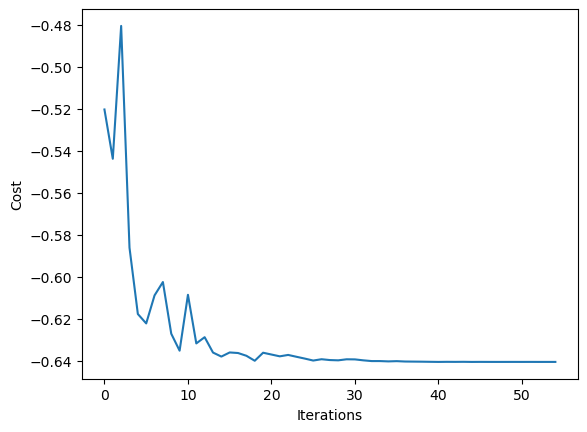

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# Power Spectral Density

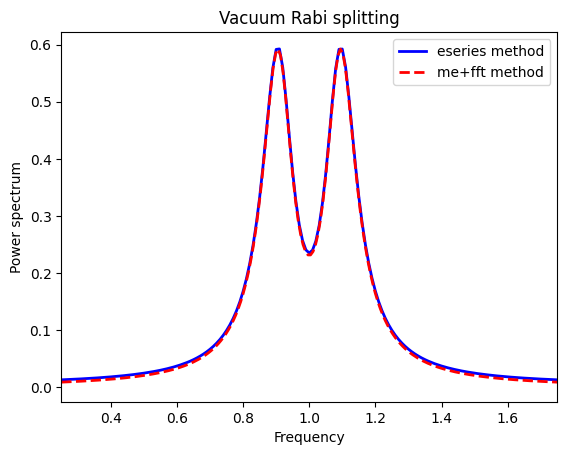

In [ ]:
N = 4                      # number of cavity fock states
wc = wa = 1.0 * 2 * np.pi  # cavity and atom frequency
g  = 0.1 * 2 * np.pi       # coupling strength
kappa = 0.75               # cavity dissipation rate
gamma = 0.25               # atom dissipation rate

# Jaynes-Cummings Hamiltonian
a  = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
sm = qutip.tensor(qutip.qeye(N), qutip.destroy(2))
H = wc*a.dag()*a + wa*sm.dag()*sm + g*(a.dag()*sm + a*sm.dag())

# collapse operators
n_th = 0.25
c_ops = [
    np.sqrt(kappa * (1 + n_th)) * a,
    np.sqrt(kappa * n_th) * a.dag(),
    np.sqrt(gamma) * sm,
]

# calculate the correlation function using the mesolve solver, and then fft to
# obtain the spectrum. Here we need to make sure to evaluate the correlation
# function for a sufficient long time and sufficiently high sampling rate so
# that the discrete Fourier transform (FFT) captures all the features in the
# resulting spectrum.
tlist = np.linspace(0, 100, 5000)
corr = qutip.correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a)
wlist1, spec1 = qutip.spectrum_correlation_fft(tlist, corr)


# calculate the power spectrum using spectrum, which internally uses essolve
# to solve for the dynamics (by default)
wlist2 = np.linspace(0.25, 1.75, 200) * 2 * np.pi
spec2 = qutip.spectrum(H, wlist2, c_ops, a.dag(), a)

# plot the spectra
plt.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=2, label='eseries method')
plt.plot(wlist2 / (2 * np.pi), spec2, 'r--', lw=2, label='me+fft method')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Power spectrum')
plt.title('Vacuum Rabi splitting')
plt.xlim(wlist2[0]/(2*np.pi), wlist2[-1]/(2*np.pi))
plt.show()